Figures index:

Peak count maps: feats_3d_bgsub.ipynb (3d data); feature_extraction.ipynb (2d data)


In [435]:
from xrdc.datasets import d2d
from xrdc import source_separation as sep
from xrdc import visualization as vis
from xrdc import peak_fitting as pf
from xrdc import featurization as feat

def norm(arr):
    return arr / arr.mean()

from ipywidgets import interactive
import nibabel as nib
import k3d
import math
import numpy as np
from k3d.helpers import download
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
from xrdc.datasets import d3d
import matplotlib

def plot_summary(activations_n1, straightened_heatmap, truncate = True):
    if truncate:
        istart, iend = 1, -1
    else:
        istart, iend = 0, len(activations_n1)
    matplotlib.rcParams.update({'font.size': 18})

    fig = plt.figure(figsize=(12, 23), constrained_layout=False)
    spec = fig.add_gridspec(7, 2)

    vis.imargs = {'cmap': 'jet', 'aspect': 1.5}

    ax0 = fig.add_subplot(spec[0, :])
    vis.heatmap(ax0, np.log(1 + norm(patterns)), label = 'Log raw signal')
    # annotate_axes(ax0, 'ax0')

    ax1 = fig.add_subplot(spec[1, :])
    vis.heatmap(ax1, np.log10(np.abs(fast_T / patterns) ), "Log noise magnitude (relative)")
    #annotate_axes(ax10, 'ax10')


    ax2 = fig.add_subplot(spec[2, :])
    vis.heatmap(ax2, background, 'Extracted background')
    # plt.title("Log signal")

    ax3 = fig.add_subplot(spec[3, :])
    #heatmap(ax3, np.log(1 + norm(fast_q - fast_q.min())))
    vis.heatmap(ax3, np.log(1 + norm((slow_T - background) -\
                                     (slow_T - background).min())),
                "Log extracted signal")
    # annotate_axes(ax11, 'ax11')

    ax4 = fig.add_subplot(spec[4, :])
    vis.heatmap(ax4, np.log(1 + straightened_heatmap), interpolation = 'none',
            label = 'Featurization (peak shift-corrected)')

    imargs = {'cmap': 'jet', 'aspect': 1}

    ax50 = fig.add_subplot(spec[5:7, 0])
    img = ax50.imshow(feat.csim_pairs(patterns), cmap = 'jet')
    print(istart, iend)
    plt.title('Cos similarity (raw)')
    plt.colorbar(img, ax = ax50)

    ax51 = fig.add_subplot(spec[5:7, 1])
    img = ax51.imshow(feat.csim_pairs(activations_n1.T)[istart: iend, istart: iend], cmap = 'jet')
    plt.title('Cos similarity (featurized)')
    plt.colorbar(img, ax = ax51)


In [2]:
def get_coords(dgrid):
    coords = np.array([dgrid.coord(ii + 1) for ii in range(177)])
    return coords

swap3d = lambda arr: np.einsum("ijk->kij", arr)

def csim3d(activations_n1):
    #activations_n1 = swap3d(activations_n1)
    tmp = np.einsum("kij, klm->ijlm", activations_n1, activations_n1)

    norm = np.linalg.norm(activations_n1, axis = 0)

    norm4d = np.einsum("ij, kl->ijkl", norm, norm)

    tmp_csim = tmp / (norm4d + 1e-30)
    return tmp_csim

def gridstack(arr4d):
    return np.vstack(np.dstack(np.transpose(arr4d, (1, 0, 2, 3))))

def plot_clusters_grid(coords, clust, nclust):
    import matplotlib
    dim = coords.max()
    coordi = coords - 1
    hues = [float(float(x)/float(nclust)) for x in range(1,nclust+1)]
    cg = cluster_grid = np.zeros(shape = (dim,dim,3))
    for k, (x, y) in enumerate(coordi):
        cluster = clust[k]
        cluster_grid[x, y] = matplotlib.colors.hsv_to_rgb([hues[cluster],1,1])
#     if debug:
#         print(coords)

#     fig = plt.figure()
#     fig.tight_layout()
    start, end = nclust - 1, nclust
    Big_labels = []
    Big_labels.append(clust)
    plt.imshow(cg)
    
def rmap(arr):
    """
    Map feature indices to random floats for visualization (temporary hack)
    """
    imax = arr.max()
    arr = arr.copy().astype(float)

    for i in range(1, imax + 1):
        new = np.random.random()
        arr[arr == i] = new
    return arr
 
# merge eventually into featurization.peakfit_featurize, needs to be more general to handle both 2 and 3-d arrays
def peakfit_featurize(patterns_pp, fitlists, size_thresh = 5, thicken_ax0 = 1, normf = feat.norm3d):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
        smooth_ax1 = 1,
        smooth_ax0 = thicken_ax0, threshold_percentile = 50, thicken = True, size_thresh = size_thresh, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 1,
        thicken_ax1 = 0, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists,
    peakwidth = 1, normf = normf)
    return labeled, feature_masks, activations, norm_, activations_n1

# heatmap overlayed with binary mask
def overlay_mask(img, mask, **kwargs):
    grayscale = 1 - mask
    alpha = mask
    rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
    plt.imshow(np.log(1 + img), cmap = 'jet', **kwargs)
    plt.imshow(rgb_img, cmap = 'Greys', **kwargs)

In [3]:
import numpy as np

In [4]:
ls ../../slacpaper

figures/      iopart12.clo    separation.aux  separation.tex
iopams.sty    iopart.cls      separation.log  setstack.sty
iopart10.clo  paper_figures/  separation.pdf


In [5]:
path = '../../slacpaper/paper_figures/'

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(20, 10)

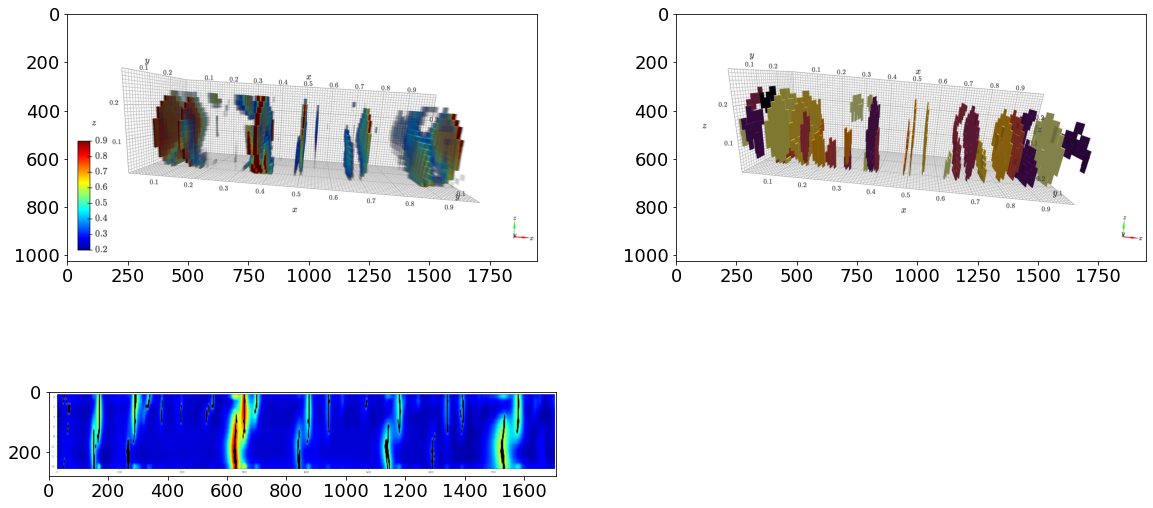

In [22]:
from PIL import Image
img1 = Image.open(path + '6/K3D-1641934967991.png')
img2 = Image.open(path + '6/K3D-1641934705480.png')
img3 = Image.open(path + '6/cut50.png')

a, b = 2, 2
plt.subplot(a, b, 1)
plt.imshow(img2)

plt.subplot(a, b, 2)
plt.imshow(img1)

plt.subplot(a, b, 3)
plt.imshow(img3)

In [54]:
import matplotlib

def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

Text(0.5, 1.0, 'Signal + features (2D cut)')

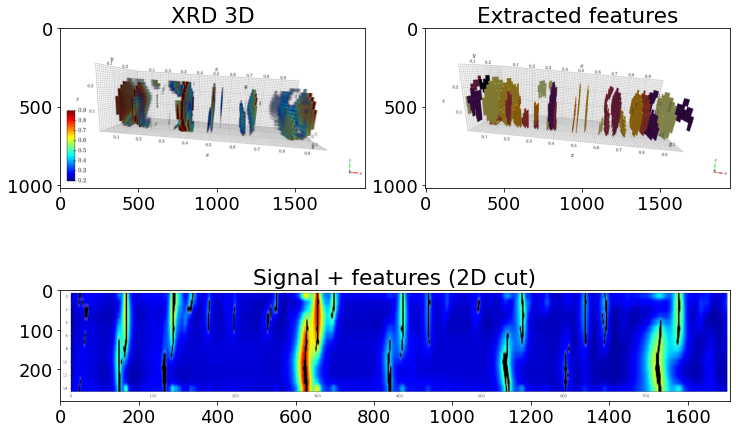

In [9]:
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(12, 8), constrained_layout=False)
spec = fig.add_gridspec(2, 2)

imargs = {'cmap': 'jet', 'aspect': 8}

ax0 = fig.add_subplot(spec[0, 0])
plt.imshow(img2)
plt.title('XRD 3D')

ax1 = fig.add_subplot(spec[0, 1])
plt.imshow(img1)
plt.title('Extracted features')
#annotate_axes(ax10, 'ax10')


ax2 = fig.add_subplot(spec[1, :])
plt.imshow(img3)
plt.title('Signal + features (2D cut)')
# plt.title("Log signal")

# ax3 = fig.add_subplot(spec[3, :])
# #heatmap(ax3, np.log(1 + norm(fast_q - fast_q.min())))
# heatmap(ax3, np.log(1 + norm((slow_T - background) - (slow_T - background).min())), "Log extracted signal")
# # annotate_axes(ax11, 'ax11')

# ax4 = fig.add_subplot(spec[4, :])
# heatmap(ax4, np.log(1 + straightened_heatmap), interpolation = 'none',
#         label = 'Featurization (peak shift-corrected)')

# imargs = {'cmap': 'jet', 'aspect': 1}

# ax50 = fig.add_subplot(spec[5:7, 0])
# img = ax50.imshow(feat.csim_pairs(patterns), cmap = 'jet')
# plt.title('Cos similarity (raw)')
# plt.colorbar(img, ax = ax50)

# ax51 = fig.add_subplot(spec[5:7, 1])
# img = ax51.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
# plt.title('Cos similarity (featurized)')
# plt.colorbar(img, ax = ax51)

# # fig.suptitle('Manually added subplots, spanning a column')

Fig. 2

In [8]:
patterns = d2d.patterns

In [9]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7)
background = slow_q

(0, 0)


(0, 0)
Peak at 69, start iteration with error = 0.19922903790355762
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229

Peak at 276, iteration 0: error = 0.601485765101419
bounds ([-29.8, -5.668151751846711, 0, 0, 0], [625.8, inf, inf, 596.0, 596.0])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 2

/home/ollie/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


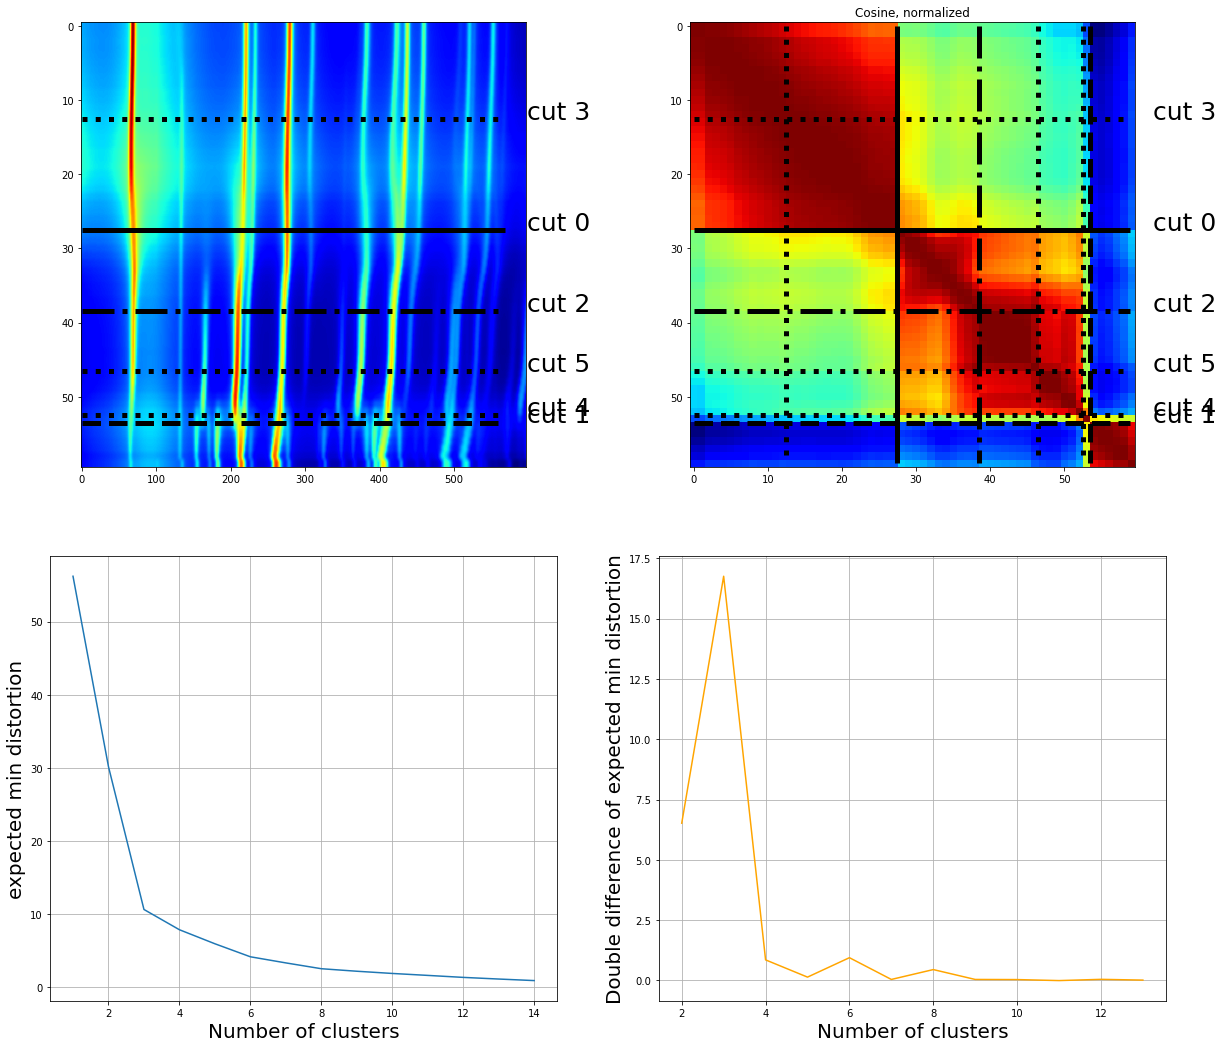

In [7]:
import xrdc.recipes.T_progression

(0, 0)
Peak at 69, start iteration with error = 0.5832013032160881
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

Peak at 210, iteration 0: error = 332.4738980545248
bounds ([-29.8, -6361.548129227516, 0, 0, 0], [625.8, inf, inf, 149.0, 149.0])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 2

<module 'xrdc.recipes.T_progression' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/recipes/T_progression.py'>

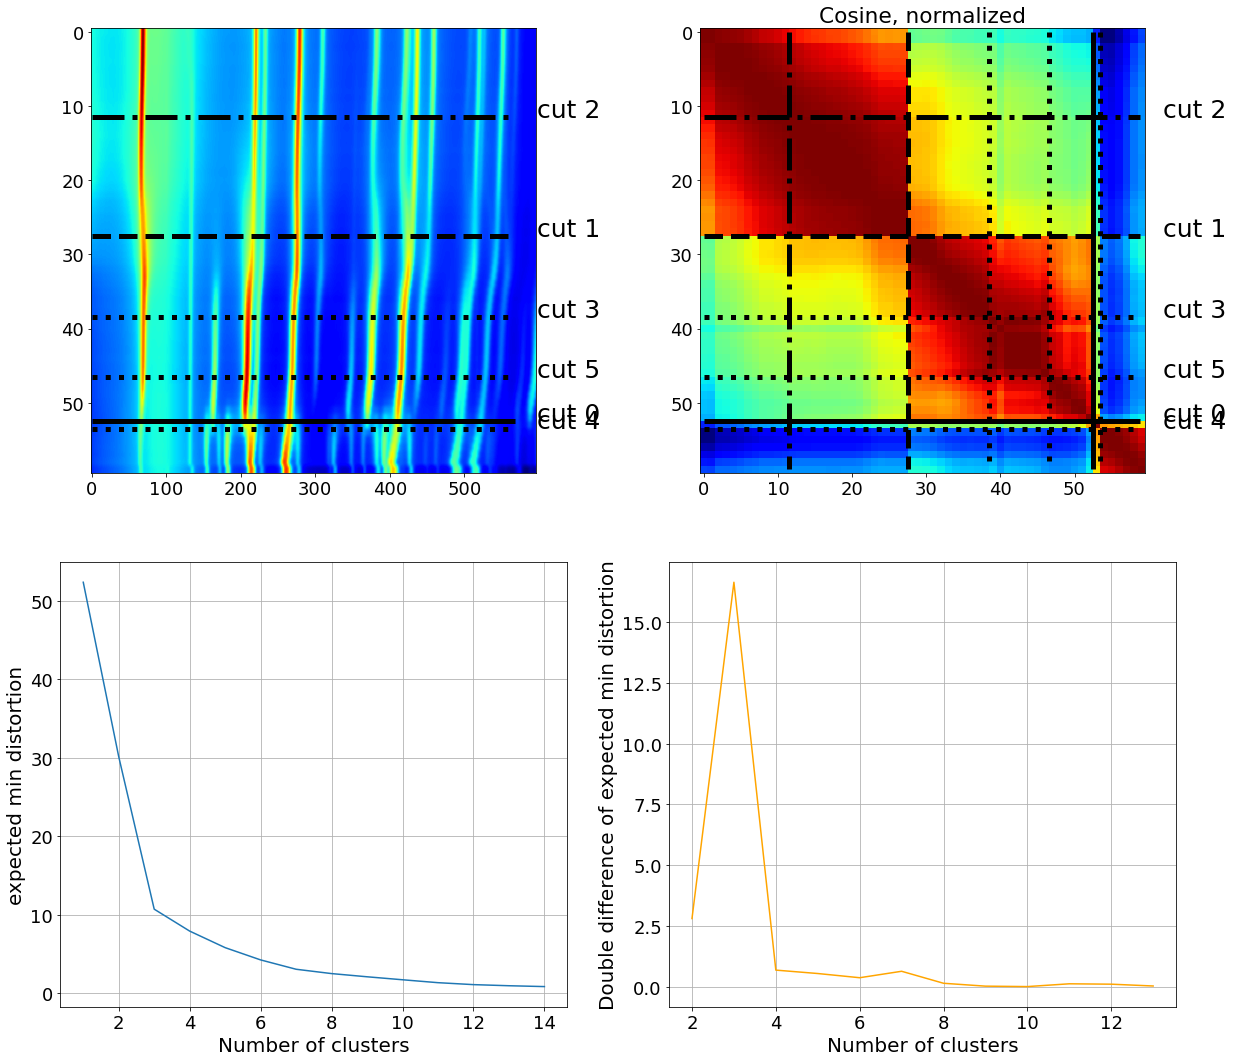

In [114]:
reload(xrdc.recipes.T_progression)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);


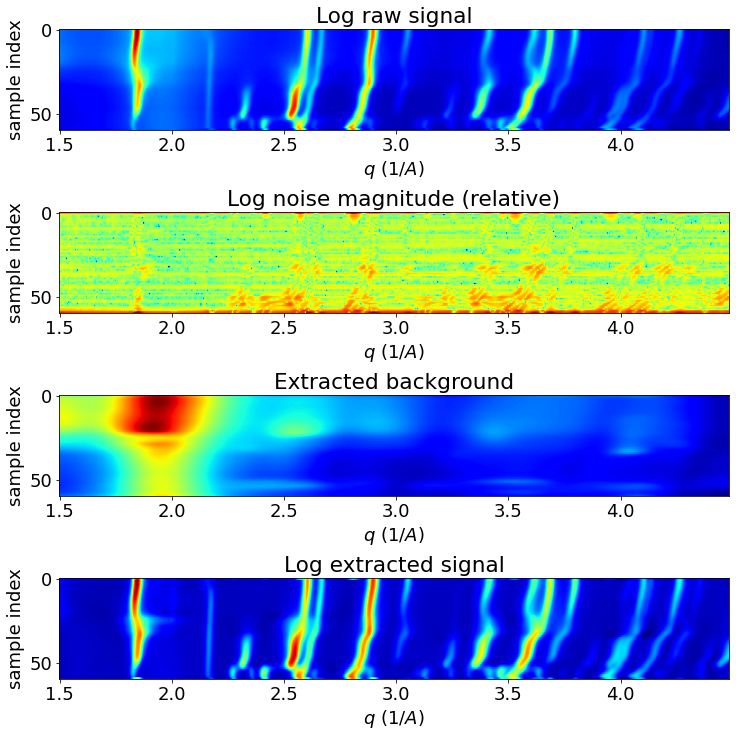

In [57]:
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(12, 23), constrained_layout=False)
spec = fig.add_gridspec(7, 2)

vis.imargs = {'cmap': 'jet', 'aspect': 1.5}

ax0 = fig.add_subplot(spec[0, :])
vis.heatmap(ax0, np.log(1 + norm(patterns)), label = 'Log raw signal')
# annotate_axes(ax0, 'ax0')

ax1 = fig.add_subplot(spec[1, :])
vis.heatmap(ax1, np.log10(np.abs(fast_T / patterns) ), "Log noise magnitude (relative)")
#annotate_axes(ax10, 'ax10')


ax2 = fig.add_subplot(spec[2, :])
vis.heatmap(ax2, background, 'Extracted background')
# plt.title("Log signal")

ax3 = fig.add_subplot(spec[3, :])
#heatmap(ax3, np.log(1 + norm(fast_q - fast_q.min())))
vis.heatmap(ax3, np.log(1 + norm((slow_T - background) - (slow_T - background).min())), "Log extracted signal")
# annotate_axes(ax11, 'ax11')

# ax4 = fig.add_subplot(spec[4, :])
# heatmap(ax4, np.log(1 + straightened_heatmap), interpolation = 'none',
#         label = 'Featurization (peak shift-corrected)')

# imargs = {'cmap': 'jet', 'aspect': 1}

# ax50 = fig.add_subplot(spec[5:7, 0])
# img = ax50.imshow(feat.csim_pairs(patterns), cmap = 'jet')
# plt.title('Cos similarity (raw)')
# plt.colorbar(img, ax = ax50)

# ax51 = fig.add_subplot(spec[5:7, 1])
# img = ax51.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
# plt.title('Cos similarity (featurized)')
# plt.colorbar(img, ax = ax51)

# fig.suptitle('Manually added subplots, spanning a column')

In [8]:
from importlib import reload
reload(feat)
reload(pf.hitp)
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [61]:
fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 2, noise_estimate = fast_T,
                   background = background, bg_shift_pos = False)



numBlocks: 357, dataPts/Block: 1.6722689075630253
[  0.  34. 126. 182. 229. 262. 296. 341. 407. 429. 447. 500. 511. 538.
 566. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 126.0], [126.0, 182.0], [182.0, 229.0], [229.0, 262.0], [262.0, 296.0], [296.0, 341.0], [341.0, 407.0], [407.0, 429.0], [429.0, 447.0], [447.0, 500.0], [500.0, 511.0], [511.0, 538.0], [538.0, 566.0], [566.0, 596.0]]}
running a single process
Peak at 1, start iteration with error = 0.405102059239611
0.4481095909584606
Peak at 70, start iteration with error = 0.5708371891781829
4.631350798179307
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125]
Peak at 70, iteration

Peak at 133, start iteration with error = 0.5577958665490299
31.758596146354847
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184]
Peak at 133, iteration 0: error = 1.2988126151998254
1.4292323792836048
bounds ([123.1, -126.44004983317313, 0, 0, 0], [186.9, inf, inf, 14.5, 14.5])
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184]
Peak at 222, start iteration with error = 0.9354609245926422
171.68595804988678
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228]
Peak at 222, iteration 0: er

Peak at 460, start iteration with error = 0.5590222480399517
143.24091000663398
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499]
Peak at 460, iteration 0: error = 13.059337526184372
9.992524634904633
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499]
Peak at 460, iteration 1: error = 6.680571773822768
3.2900789544663236
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499]
Peak at 460, iteration 2: error = 7.895731929000978
2.7013788200702
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 4

Peak at 133, start iteration with error = 0.26554610313845334
32.13091815662113
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Peak at 133, iteration 0: error = 2.2133547167708243
2.265593057529672
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Peak at 133, iteration 1: error = 2.2133545638921825
2.265593057529671
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Peak at 133, iteration 2: error = 2.213354550982117
2.2655930575298546
[126 127 128 129 130

Peak at 460, start iteration with error = 0.7051486005977157
247.45367867760385
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 0: error = 16.80009241309303
18.232067479400786
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 1: error = 5.129257990134382
5.163485498878636
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 2: error = 6.438303615981814
3.7041622403627033
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 3: error = 0.7534113826864004

Peak at 134, start iteration with error = 0.25699086614165967
65.80411487214319
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183]
Peak at 134, iteration 0: error = 2.49294385822975
5.907342571476623
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183]
Peak at 134, iteration 1: error = 4.197167182434536
4.495982216995278
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183]
Peak at 134, iteration 2: error = 4.197167180269248
4.495982216997968


Peak at 424, iteration 1: error = 3.998069122595787
6.458386326660994
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 424, iteration 2: error = 8.186716026406375
4.652664866044042
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 424, iteration 3: error = 9.908457149938306
bounds ([404.85, -1066.751518827226, 0, 0, 0, 404.85, -1066.751518827226, 0, 0, 0, 404.85, -1066.751518827226, 0, 0, 0, 404.85, -1066.751518827226, 0, 0, 0], [430.15, inf, inf, 5.75, 5.75, 430.15, inf, inf, 5.75, 5.75, 430.15, inf, inf, 5.75, 5.75, 430.15, inf, inf, 5.75, 5.75])
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 438, start iteration with error = 0.6499981533983386
576.1044928420425
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446]
Peak at 438, iteration 0: error = 0.3040242710891426
81.14255047136683
[430 431 43

Peak at 70, iteration 0: error = 26.631353179783297
7.990528409731749
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126]
Peak at 70, iteration 1: error = 15.709368524585845
6.528389173386444
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126]
Peak at 70, iteration 2: error = 15.709368668590246
6.5283891733864445
[ 34  35  36  37  38  39  40  4

Peak at 423, start iteration with error = 0.8155101720664928
153.80443474272593
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428]
Peak at 423, iteration 0: error = 0.8630293534645795
20.080763992636175
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428]
Peak at 423, iteration 1: error = 18.441039235216184
11.730158841562805
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428]
Peak at 423, iteration 2: error = 25.09390244640161
10.622724333104301
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428]
Peak at 423, iteration 3: error = 1.6946250489025716
bounds ([404.9, -1038.5925355937864, 0, 0, 0, 404.9, -1038.5925355937864, 0, 0, 0, 404.9, -1038.5925355937864, 0, 0, 0, 404.9, -1038.5925355937864, 0, 0, 0], [429.1, inf, inf, 5.5, 5.5, 429.1, inf, inf, 5.5, 5.5, 429.1, inf, inf, 5.5, 5.5, 429.1, inf, inf, 5.5, 5.5])
[406

numBlocks: 363, dataPts/Block: 1.6446280991735538
[  0.  34. 128. 195. 228. 261. 296. 338. 396. 429. 446. 499. 509. 537.
 562. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 128.0], [128.0, 195.0], [195.0, 228.0], [228.0, 261.0], [261.0, 296.0], [296.0, 338.0], [338.0, 396.0], [396.0, 429.0], [429.0, 446.0], [446.0, 499.0], [499.0, 509.0], [509.0, 537.0], [537.0, 562.0], [562.0, 596.0]]}
running a single process
Peak at 1, start iteration with error = 0.3240316682812472
7.908949993123184
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 1, iteration 0: error = 0.2269829496996274
0.719982190701282
bounds ([-0.6000000000000001, -55.047410562160735, 0, 0, 0], [34.6, inf, inf, 8.0, 8.0])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 70, start iteration with error = 0.547559654431666
307.69709123297383
[ 34  35  36  37  38  39  40  41  

Peak at 311, iteration 1: error = 4.076677683896033
3.0575206352094875
[296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337]
Peak at 311, iteration 2: error = 4.076651844121743
3.0575206350619055
[296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337]
Peak at 311, iteration 3: error = 4.076651844120345
bounds ([293.95, -585.0026753183198, 0, 0, 0, 293.95, -585.0026753183198, 0, 0, 0, 293.95, -585.0026753183198, 0, 0, 0, 293.95, -585.0026753183198, 0, 0, 0], [339.05, inf, inf, 10.25, 10.25, 339.05, inf, inf, 10.25, 10.25, 339.05, inf, inf, 10.25, 10.25, 339.05, inf, inf, 10.25, 10.25])
[296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337]
Pe

Peak at 571, start iteration with error = 0.4898231348810366
54.689038896604906
[562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 571, iteration 0: error = 4.63321334025865
11.257978638291345
[562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 571, iteration 1: error = 4.2590394983662305
4.650146636932999
[562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 571, iteration 2: error = 4.739000430961276
3.8534287239786
[562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 571, iteration 3: error = 1.832430578744981
bounds ([560.35, -102.33611824753223, 0, 0, 0, 560.35, -102.33611824753223, 0, 0, 0, 560.35, -102.33611

Peak at 280, start iteration with error = 0.8755692884885529
411.0392394286375
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 0: error = 4.355502345822606
5.049611268592903
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 1: error = 6.522265957183912
3.9660242972319297
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 2: error = 6.522264964661558
3.966024306961932
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 3: error = 6.5222655823707045
bounds ([259.3, -5177.67596259032, 0, 0, 0, 259.3, -5177.67596259032, 0, 0, 0, 259.3,

Peak at 521, start iteration with error = 0.8244197945538676
380.9607801543159
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541]
Peak at 521, iteration 0: error = 0.7117729358185009
66.51460150495168
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541]
Peak at 521, iteration 1: error = 0.24909083331060086
42.99754197375068
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541]
Peak at 521, iteration 2: error = 0.34950265174378964
35.27736471085016
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541]
Peak at 521, iteration 3: error = 0.48711573046982004
bounds ([507.4, -619.4428733485234, 0, 0, 0, 507.4, -619.4428733485234, 0, 0, 0, 507.4, -619.4428733485234, 0, 0

Peak at 222, start iteration with error = 0.5137428312673672
515.9616570071325
[181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226]
Peak at 222, iteration 0: error = 4.629487708182449
2.0569030074881107
[181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226]
Peak at 222, iteration 1: error = 5.095661532322486
1.5023203551876279
bounds ([178.75, -3308.368017873353, 0, 0, 0, 178.75, -3308.368017873353, 0, 0, 0], [228.25, inf, inf, 11.25, 11.25, 228.25, inf, inf, 11.25, 11.25])
[181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226]
Peak at 234, start iteration with error = 0.6057047038940926
183.

Peak at 438, iteration 3: error = 0.07908837347430776
bounds ([426.95, -2048.828309085947, 0, 0, 0, 426.95, -2048.828309085947, 0, 0, 0, 426.95, -2048.828309085947, 0, 0, 0, 426.95, -2048.828309085947, 0, 0, 0], [450.05, inf, inf, 5.25, 5.25, 450.05, inf, inf, 5.25, 5.25, 450.05, inf, inf, 5.25, 5.25, 450.05, inf, inf, 5.25, 5.25])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449]
Peak at 460, start iteration with error = 0.677418754155107
215.88061872469694
[450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484]
Peak at 460, iteration 0: error = 4.588777448281278
15.809492620824596
[450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484]
Peak at 460, iteration 1: error = 14.413463342853529
9.627314272925632
[450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466

Peak at 221, start iteration with error = 0.5104312660260996
492.6825841044123
[179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226]
Peak at 221, iteration 0: error = 4.370119789859314
1.9337697005014796
bounds ([176.65, -3222.48986418983, 0, 0, 0], [228.35, inf, inf, 11.75, 11.75])
[179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226]
Peak at 234, start iteration with error = 0.6102007896207131
230.52450970416407
[227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260]
Peak at 234, iteration 0: error = 5.059412297470748
27.42763191043783
[227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248

Peak at 459, iteration 3: error = 0.2552873477103855
bounds ([444.1, -1079.6630633084835, 0, 0, 0, 444.1, -1079.6630633084835, 0, 0, 0, 444.1, -1079.6630633084835, 0, 0, 0, 444.1, -1079.6630633084835, 0, 0, 0], [485.9, inf, inf, 9.5, 9.5, 485.9, inf, inf, 9.5, 9.5, 485.9, inf, inf, 9.5, 9.5, 485.9, inf, inf, 9.5, 9.5])
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484]
Peak at 506, start iteration with error = 0.30127767445187
18.168918434702544
[485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507]
Peak at 506, iteration 0: error = 0.9802717775846612
0.5590414716311856
bounds ([483.9, -85.02433711490619, 0, 0, 0], [508.1, inf, inf, 5.5, 5.5])
[485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507]
Peak at 520, start iteration with error = 0.7483652095328482
129.66366063085295
[508 509 510 511 512 513

Peak at 221, start iteration with error = 0.7019896701632854
381.8666446449287
[193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227]
Peak at 221, iteration 0: error = 2.707293716170102
1.7371636717192829
bounds ([191.3, -3170.8654038728014, 0, 0, 0], [228.7, inf, inf, 8.5, 8.5])
[193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227]
Peak at 234, start iteration with error = 0.567125965357547
130.59629782858883
[228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260]
Peak at 234, iteration 0: error = 5.930757539967253
9.167774744640155
[228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260]
Peak at 234, iteration 1: error = 11.792641545492636
5.10065584945269

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 459, iteration 2: error = 9.452283254948963
5.967181431212076
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495]
Peak at 459, iteration 3: error = 11.21211155108066
bounds ([443.55, -1051.0032040302874, 0, 0, 0, 443.55, -1051.0032040302874, 0, 0, 0, 443.55, -1051.0032040302874, 0, 0, 0, 443.55, -1051.0032040302874, 0, 0, 0], [497.45, inf, inf, 12.25, 12.25, 497.45, inf, inf, 12.25, 12.25, 497.45, inf, inf, 12.25, 12.25, 497.45, inf, inf, 12.25, 12.25])
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495]
Peak at 506, start iteration with error = 0.5780118542266027
26.17102409625775
[496 497 498 

Peak at 136, start iteration with error = 0.22027571398889947
36.516029670044354
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191]
Peak at 136, iteration 0: error = 2.9992292731295547
2.1242505796325872
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191]
Peak at 136, iteration 1: error = 3.984813189741484
1.5159752818600492
bounds ([125.9, -263.1981776808427, 0, 0, 0, 125.9, -263.1981776808427, 0, 0, 0], [194.1, inf, inf, 15.5, 15.5, 194.1, inf, inf, 15.5, 15.5])
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 15

Peak at 437, iteration 3: error = 0.045487078325677756
bounds ([426.1, -2027.0985111666018, 0, 0, 0, 426.1, -2027.0985111666018, 0, 0, 0, 426.1, -2027.0985111666018, 0, 0, 0, 426.1, -2027.0985111666018, 0, 0, 0], [445.9, inf, inf, 4.5, 4.5, 445.9, inf, inf, 4.5, 4.5, 445.9, inf, inf, 4.5, 4.5, 445.9, inf, inf, 4.5, 4.5])
[427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445]
Peak at 459, start iteration with error = 0.5732135714838337
206.41155395459526
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495]
Peak at 459, iteration 0: error = 13.20031154921519
20.332124061387173
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495]
Peak at 459, iteration 1: error = 8.606

Peak at 221, start iteration with error = 0.7131285690791992
377.72679848927544
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226]
Peak at 221, iteration 0: error = 1.8873853604251758
1.7145232298686504
bounds ([189.25, -3000.921963859001, 0, 0, 0], [227.75, inf, inf, 8.75, 8.75])
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226]
Peak at 233, start iteration with error = 0.6008847164404229
334.2149284691753
[227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259]
Peak at 233, iteration 0: error = 5.92430036144678
29.45286739915199
[227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259]
Peak at 233, iteration 1: error = 10.474419224504032
14.2

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 458, iteration 3: error = 10.407601394932358
bounds ([442.55, -960.6280917920695, 0, 0, 0, 442.55, -960.6280917920695, 0, 0, 0, 442.55, -960.6280917920695, 0, 0, 0, 442.55, -960.6280917920695, 0, 0, 0], [496.45, inf, inf, 12.25, 12.25, 496.45, inf, inf, 12.25, 12.25, 496.45, inf, inf, 12.25, 12.25, 496.45, inf, inf, 12.25, 12.25])
[445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494]
Peak at 505, start iteration with error = 0.6616184747304016
58.59076249358122
[495 496 497 498 499 500 501 502 503 504 505 506 507 508 509]
Peak at 505, iteration 0: error = 3.574775271416599
5.3167889664332915
[495 496 497 498 499 500 501 502 503 504 505 506 507 508 509]
Peak at 505, iteration 1: error = 3.726854361405324
4.456418701435495
[495 496 497 498 499 500 

Peak at 136, start iteration with error = 0.21170147121607288
71.05049586904522
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189]
Peak at 136, iteration 0: error = 1.9904554099738103
2.3028463541194704
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189]
Peak at 136, iteration 1: error = 2.6401118200640714
1.698034795397315
bounds ([126.0, -294.23647991726966, 0, 0, 0, 126.0, -294.23647991726966, 0, 0, 0], [192.0, inf, inf, 15.0, 15.0, 192.0, inf, inf, 15.0, 15.0])
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 1

Peak at 436, iteration 2: error = 0.06878829869422141
12.360194405166276
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448]
Peak at 436, iteration 3: error = 0.07456156378600959
bounds ([427.0, -1938.322182645226, 0, 0, 0, 427.0, -1938.322182645226, 0, 0, 0, 427.0, -1938.322182645226, 0, 0, 0, 427.0, -1938.322182645226, 0, 0, 0], [449.0, inf, inf, 5.0, 5.0, 449.0, inf, inf, 5.0, 5.0, 449.0, inf, inf, 5.0, 5.0, 449.0, inf, inf, 5.0, 5.0])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448]
Peak at 458, start iteration with error = 0.5159365595556397
203.88407490737455
[449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494]
Peak at 458, iteration 0: error = 6.8428415407538585
13.350103472812071
[449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 4

Peak at 68, start iteration with error = 0.6702981293521146
530.6601922553139
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 0: error = 22.190094501666128
18.71944099160202
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 1: error = 15.450009057863832
15.8088500

Peak at 419, start iteration with error = 0.8534176538245518
233.47392189599503
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 0: error = 2.9873889684287858
36.83926295517736
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 1: error = 20.292126276304064
19.92653978542189
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 2: error = 3.000528977814902
16.19215337096012
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 3: error = 1.2876556092522151
bounds ([402.95, -792.204487538497, 0, 0, 0, 402.95, -792.204487538497, 0, 0, 0, 402.95, -792.204487538497, 0, 0, 0, 402.95, -792.204487538497, 0, 0, 0], [426.05, inf, inf, 5.25, 5.25, 426.05, inf, inf, 5.25, 5.25, 426.05, inf, inf, 5.25, 5.25, 426.05, inf, inf, 5.25, 5.25])
[404 405 406 40

Peak at 68, iteration 0: error = 22.53248046929409
8.875229963498606
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 1: error = 17.071420522601134
7.620225515863561
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 2: error = 17.071420537338508
7.620225515863561
[

Peak at 379, start iteration with error = 0.6114482083322943
140.1849312250013
[349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402]
Peak at 379, iteration 0: error = 4.990241878608312
8.62689025256329
[349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402]
Peak at 379, iteration 1: error = 5.322880752134072
6.578592875514325
[349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402]
Peak at 379, iteration 2: error = 5.322880750833414
6.578592875514324
[349 350 351 352 353 354 355 356 357 358 359 360 361

Peak at 1, iteration 0: error = 0.5259096642840911
2.461635094205035
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 1, iteration 1: error = 0.561998565858174
2.461966313996334
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 1, iteration 2: error = 0.5620828463548267
2.461971031279067
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 1, iteration 3: error = 0.5621623305761341
bounds ([-0.5, -92.76370066048344, 0, 0, 0, -0.5, -92.76370066048344, 0, 0, 0, -0.5, -92.76370066048344, 0, 0, 0, -0.5, -92.76370066048344, 0, 0, 0], [32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 68, start iteration with error = 0.6543474623459193
356.17393512492436
[ 32  33  34  35  36  37

Peak at 277, iteration 2: error = 29.558055879253498
10.43722155864689
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 277, iteration 3: error = 27.13763224722637
bounds ([257.0, -4374.906737555837, 0, 0, 0, 257.0, -4374.906737555837, 0, 0, 0, 257.0, -4374.906737555837, 0, 0, 0, 257.0, -4374.906737555837, 0, 0, 0], [301.0, inf, inf, 10.0, 10.0, 301.0, inf, inf, 10.0, 10.0, 301.0, inf, inf, 10.0, 10.0, 301.0, inf, inf, 10.0, 10.0])
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 308, start iteration with error = 0.38919749333921727
97.0809265883541
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346

    ----Saving data for block between 1.00 - 31.00
    ----Saving data for block between 32.00 - 128.00
    ----Saving data for block between 129.00 - 185.00
    ----Saving data for block between 186.00 - 224.00
    ----Saving data for block between 225.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 346.00
    ----Saving data for block between 347.00 - 403.00
    ----Saving data for block between 404.00 - 426.00
    ----Saving data for block between 427.00 - 444.00
    ----Saving data for block between 445.00 - 492.00
    ----Saving data for block between 493.00 - 538.00
    ----Saving data for block between 539.00 - 595.00
done
numBlocks: 377, dataPts/Block: 1.5835543766578248
[  0.  31. 129. 185. 226. 259. 296. 348. 404. 425. 448. 493. 533. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 129.0], [129.0, 185.0], [185.0, 226.0], [226.0, 259.0], [259.0, 296.0], [296.0, 348.0], [348.0, 404.0

Peak at 232, iteration 0: error = 6.897287573552516
20.985919219738193
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 232, iteration 1: error = 12.161653404977363
10.59742507578928
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 232, iteration 2: error = 13.58897497765537
9.476705421616266
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 232, iteration 3: error = 13.588947286764668
bounds ([224.4, -798.8274076785036, 0, 0, 0, 224.4, -798.8274076785036, 0, 0, 0, 224.4, -798.8274076785036, 0, 0, 0, 224.4, -798.8274076785036, 0, 0, 0], [259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0])
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 2

Peak at 518, iteration 0: error = 3.207422968444022
16.337368170641856
[493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532]
Peak at 518, iteration 1: error = 3.213198665002918
10.952128576797806
[493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532]
Peak at 518, iteration 2: error = 5.305686987137928
9.205906612743837
[493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532]
Peak at 518, iteration 3: error = 6.587265156257155
bounds ([491.05, -474.60915567055974, 0, 0, 0, 491.05, -474.60915567055974, 0, 0, 0, 491.05, -474.60915567055974, 0, 0, 0, 491.05, -474.60915567055974, 0, 0, 0], [533.95, inf, inf, 9.75, 9.75, 533.95, inf, inf, 9.75, 9.75, 533.95, inf, inf, 9.7

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 220, iteration 2: error = 2.8702543275485572
5.800221493707226
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225]
Peak at 220, iteration 3: error = 3.896588402305255
bounds ([183.0, -2375.135066970804, 0, 0, 0, 183.0, -2375.135066970804, 0, 0, 0, 183.0, -2375.135066970804, 0, 0, 0, 183.0, -2375.135066970804, 0, 0, 0], [227.0, inf, inf, 10.0, 10.0, 227.0, inf, inf, 10.0, 10.0, 227.0, inf, inf, 10.0, 10.0, 227.0, inf, inf, 10.0, 10.0])
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225]
Peak at 232, start iteration with error = 0.594533225386682
376.7214306311211
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251

Peak at 435, iteration 3: error = 0.012680565196881767
bounds ([423.9, -1932.3736967285324, 0, 0, 0, 423.9, -1932.3736967285324, 0, 0, 0, 423.9, -1932.3736967285324, 0, 0, 0, 423.9, -1932.3736967285324, 0, 0, 0], [448.1, inf, inf, 5.5, 5.5, 448.1, inf, inf, 5.5, 5.5, 448.1, inf, inf, 5.5, 5.5, 448.1, inf, inf, 5.5, 5.5])
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447]
Peak at 457, start iteration with error = 0.4993611119464349
143.92207051150277
[448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492]
Peak at 457, iteration 0: error = 8.276689319536311
13.71917423256264
[448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492]
Peak at 457, iteration 1: error = 14.318609650254851
7.087336099

Peak at 68, iteration 3: error = 12.881840490847434
bounds ([26.15, -4627.531658900578, 0, 0, 0, 26.15, -4627.531658900578, 0, 0, 0, 26.15, -4627.531658900578, 0, 0, 0, 26.15, -4627.531658900578, 0, 0, 0], [132.85, inf, inf, 24.25, 24.25, 132.85, inf, inf, 24.25, 24.25, 132.85, inf, inf, 24.25, 24.25, 132.85, inf, inf, 24.25, 24.25])
[ 31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128]
Peak at 136, start iteration with error = 0.23409042324634313
214.2588911032463
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 17

Peak at 379, start iteration with error = 0.5679794999989909
118.91830442948468
[347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403]
Peak at 379, iteration 0: error = 5.423516716524293
9.98943554995215
[347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403]
Peak at 379, iteration 1: error = 6.054863081850132
7.796290060124313
[347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403]
Peak at 379, iteration 2: error = 6.054863090733023
7.796290060124312
[347 348 349

    ----Saving data for block between 1.00 - 30.00
    ----Saving data for block between 31.00 - 128.00
    ----Saving data for block between 129.00 - 183.00
    ----Saving data for block between 184.00 - 224.00
    ----Saving data for block between 225.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 346.00
    ----Saving data for block between 347.00 - 403.00
    ----Saving data for block between 404.00 - 425.00
    ----Saving data for block between 426.00 - 447.00
    ----Saving data for block between 448.00 - 491.00
    ----Saving data for block between 492.00 - 531.00
    ----Saving data for block between 532.00 - 595.00
done
numBlocks: 392, dataPts/Block: 1.5229591836734695
[  0.  22. 129. 184. 225. 259. 300. 346. 405. 426. 444. 491. 538. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 22.0], [22.0, 129.0], [129.0, 184.0], [184.0, 225.0], [225.0, 259.0], [259.0, 300.0], [300.0, 346.0], [346.0, 405.0

Peak at 307, start iteration with error = 0.35694633813129856
34.80275023142002
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 0: error = 1.648181433763644
2.002354472418144
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 1: error = 2.9772216602865806
1.4224741851663554
bounds ([297.75, -219.10597140006723, 0, 0, 0, 297.75, -219.10597140006723, 0, 0, 0], [347.25, inf, inf, 11.25, 11.25, 347.25, inf, inf, 11.25, 11.25])
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 379, start iteration with error = 0.49523141776801083


    ----Saving data for block between 1.00 - 21.00
    ----Saving data for block between 22.00 - 128.00
    ----Saving data for block between 129.00 - 183.00
    ----Saving data for block between 184.00 - 224.00
    ----Saving data for block between 225.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 345.00
    ----Saving data for block between 346.00 - 404.00
    ----Saving data for block between 405.00 - 425.00
    ----Saving data for block between 426.00 - 443.00
    ----Saving data for block between 444.00 - 490.00
    ----Saving data for block between 491.00 - 537.00
    ----Saving data for block between 538.00 - 595.00
done
numBlocks: 391, dataPts/Block: 1.526854219948849
[  0.  31. 125. 170. 226. 259. 300. 346. 405. 424. 444. 490. 532. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 125.0], [125.0, 170.0], [170.0, 226.0], [226.0, 259.0], [259.0, 300.0], [300.0, 346.0], [346.0, 405.0]

Peak at 307, start iteration with error = 0.44517160072761675
37.047874738231414
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 0: error = 1.326624493634716
2.0813760702579382
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 1: error = 2.131467634128812
1.6655787983012142
bounds ([297.75, -207.34670727543232, 0, 0, 0, 297.75, -207.34670727543232, 0, 0, 0], [347.25, inf, inf, 11.25, 11.25, 347.25, inf, inf, 11.25, 11.25])
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 379, start iteration with error = 0.5642104541150065


Peak at 548, iteration 3: error = 7.771647856383922
bounds ([528.85, -451.92731190163715, 0, 0, 0, 528.85, -451.92731190163715, 0, 0, 0, 528.85, -451.92731190163715, 0, 0, 0, 528.85, -451.92731190163715, 0, 0, 0], [598.15, inf, inf, 15.75, 15.75, 598.15, inf, inf, 15.75, 15.75, 598.15, inf, inf, 15.75, 15.75, 598.15, inf, inf, 15.75, 15.75])
[532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595]
    ----Saving data for block between 1.00 - 30.00
    ----Saving data for block between 31.00 - 124.00
    ----Saving data for block between 125.00 - 169.00
    ----Saving data for block between 170.00 - 225.00
    ----Saving data for block between 226.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 345.00
    ----Saving data f

Peak at 232, iteration 3: error = 14.628701420863191
bounds ([224.4, -746.6443202709569, 0, 0, 0, 224.4, -746.6443202709569, 0, 0, 0, 224.4, -746.6443202709569, 0, 0, 0, 224.4, -746.6443202709569, 0, 0, 0], [259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0])
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 277, start iteration with error = 0.893217983119335
429.0229668735571
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 277, iteration 0: error = 5.436496959608243
10.432959694471474
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 277, iteration 1: error = 2.8531253852829233
8.20361551

Peak at 516, start iteration with error = 0.7505040504580491
95.22571724457416
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531]
Peak at 516, iteration 0: error = 3.083631658862553
15.060195749531932
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531]
Peak at 516, iteration 1: error = 6.2498118445229185
8.291015290155508
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 516, iteration 2: error = 6.122157470065777
8.48274971735545
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 51

Peak at 219, start iteration with error = 0.6390910130205801
184.50186280231674
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 0: error = 33.26928687929761
11.161796693597122
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 1: error = 8.816460780680247
6.374075692920352
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 2: error = 10.759252052927545
4.482373725807037
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 3: error = 11.524942324550446
bounds ([183.1,

Peak at 455, start iteration with error = 0.5710911622553231
122.91896747968089
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487]
Peak at 455, iteration 0: error = 17.5242271811773
28.84540744599914
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487]
Peak at 455, iteration 1: error = 14.600959120280185
13.116461614685186
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487]
Peak at 455, iteration 2: error = 19.192679379206062
9.339877902050288
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 4

Peak at 135, start iteration with error = 0.27326746192297413
59.29840448010651
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185]
Peak at 135, iteration 0: error = 0.9335596126345788
1.2137428001038164
bounds ([122.0, -323.6130317073406, 0, 0, 0], [188.0, inf, inf, 15.0, 15.0])
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185]
Peak at 219, start iteration with error = 0.6940893586575889
149.4213605968917
[186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223]
Peak at 219, iteration 0: error = 51.8

Peak at 424, iteration 0: error = 8.653153227368206
1.9554186220244318
bounds ([405.1, -904.5330163128857, 0, 0, 0], [424.9, inf, inf, 4.5, 4.5])
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424]
Peak at 433, start iteration with error = 0.5561874647702957
99.46179149957749
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 0: error = 0.30151135328813083
36.589591727915256
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 1: error = 0.13741008842337968
9.126029009909553
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 2: error = 0.13133430548953334
7.0981665787125925
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 3: error = 0.06333800762339788
bounds ([424.0, -1509.2464261511595, 0, 0, 0, 424.0, -1509.2464261511595, 0,

Peak at 135, start iteration with error = 0.37907544913656216
98.17852099571628
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 135, iteration 0: error = 2.3138226193805003
2.650274515914379
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 135, iteration 1: error = 2.9142512010626684
1.855950209929481
bounds ([126.35, -326.5894123545305, 0, 0, 0, 126.35, -326.5894123545305, 0, 0, 0], [162.65, inf, inf, 8.25, 8.25, 162.65, inf, inf, 8.25, 8.25])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 170, start iteration with error = 0.43492439289965273
3.3575552966848234
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185]
Peak at 170, iteration 0: error = 0

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 433, start iteration with error = 0.5444428121736943
197.99952714856806
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 0: error = 0.3422039267542813
87.43767588228553
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 1: error = 0.21160654940400722
24.0481005607032
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 2: error = 0.10616385127468801
20.344655480350585
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 3: error = 0.108071930640501
bounds ([424.0, -1422.133809565381, 0, 0, 0, 424.0, -1422.133809565381, 0, 0, 0, 424.0, -1422.133809565381, 0, 0, 0, 424.0, -1422.133809565381, 0, 0, 0], [446.0, inf, inf, 5.0, 5.0, 446.0, inf, inf, 5.0, 5.0, 446.0, inf

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, start iteration with error = 0.37766393466872533
60.02256459416373
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 135, iteration 0: error = 1.6655248349637695
1.605456972499828
bounds ([126.35, -321.4861222451319, 0, 0, 0], [162.65, inf, inf, 8.25, 8.25])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 170, start iteration with error = 0.4297410102192221
3.642459825959206
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185]
Peak at 170, iteration 0: error = 0.8673137473381601
0.6449069820647422
bounds ([160.85, -12.620869441324999, 0, 0, 0], [186.15, inf, inf, 5.75, 5.75])
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 18

Peak at 454, start iteration with error = 0.5820578925635541
84.31806695624664
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485]
Peak at 454, iteration 0: error = 26.353152101255876
25.56146115175606
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485]
Peak at 454, iteration 1: error = 20.504124778333104
11.496176701872688
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485]
Peak at 454, iteration 2: error = 24.92574490088378
8.866520395384773
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 47

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, start iteration with error = 0.402162125139689
151.525071132591
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 0: error = 1.930848959657847
4.171444926759971
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 1: error = 2.605585426820653
2.9575956411929933
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 2: error = 3.0070384122042935
2.7695825322945207
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 3: error = 3.158450810358115
bounds ([126.45, -324.8286792317167, 0, 0, 0, 12

Peak at 432, start iteration with error = 0.9192813047641263
325.4772975153599
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 0: error = 17.936892172808882
120.52305440495947
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 1: error = 64.94053825084163
61.10676297192834
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 2: error = 3.789465086694472
45.599172412187315
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 3: error = 8.766636350389293
bounds ([404.15, -1387.301824853

Peak at 135, start iteration with error = 0.4136474462839352
74.37227440318819
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 135, iteration 0: error = 1.3301298570148676
1.7460634600994067
bounds ([126.5, -328.96940669918547, 0, 0, 0], [159.5, inf, inf, 7.5, 7.5])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 169, start iteration with error = 0.38413696328236346
5.420644090468675
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
Peak at 169, iteration 0: error = 1.6881614832543117
0.5681726984053488
bounds ([157.65, -21.283241531562112, 0, 0, 0], [187.35, inf, inf, 6.75, 6.75])
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
Peak at 218, start iteration with error = 0.8370947809765

Peak at 454, start iteration with error = 0.5444982653078935
68.52292096628831
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration 0: error = 19.52418749651152
18.48134849959582
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration 1: error = 32.633070624781126
9.040719273525038
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration 2: error = 8.381583754868261
6.536830066199963
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration

Peak at 135, start iteration with error = 0.4156459326089304
82.98230681219836
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 135, iteration 0: error = 2.2152992754462635
2.2742430879240567
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 135, iteration 1: error = 2.8184251183860143
1.5096796533127994
bounds ([126.5, -335.4261951999929, 0, 0, 0, 126.5, -335.4261951999929, 0, 0, 0], [159.5, inf, inf, 7.5, 7.5, 159.5, inf, inf, 7.5, 7.5])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 169, start iteration with error = 0.48046490918853507
9.966093044865163
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
Peak at 169, iteration 0: error = 2.167414805002657
0.936601253

Peak at 453, start iteration with error = 0.5769815871337144
115.1847163345715
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Peak at 453, iteration 0: error = 16.593340589740937
26.490495300215997
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Peak at 453, iteration 1: error = 27.292140376496587
14.251677727653956
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Peak at 453, iteration 2: error = 30.29862122241825
13.191844853766487
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Pe

Peak at 135, start iteration with error = 0.4047042747610603
162.06165393744854
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 0: error = 2.115820623208647
4.538062870559683
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 1: error = 2.671368932240281
3.1574834064471844
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 2: error = 2.925319638005518
3.0542865426199035
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 3: error = 2.9253195557656646
bounds ([122.35, -342.32969418264827, 0, 0, 0, 122.35, -342.32969418264827, 0, 0, 0, 122.35, -342.3

Peak at 427, start iteration with error = 0.9332491159533748
127.7932885971767
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 0: error = 5.8071909131241535
8.801916049442449
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 1: error = 1.5265743136726782
6.272828549448937
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 2: error = 2.99754592935959
3.9809638273952532
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 3: error = 4.119924349704578
bounds ([404.45, -1744.8692129172355, 0, 0, 0, 404.45, -1744.8692129172355, 0, 0, 0, 404.45, -1744.8692129172355, 0, 0, 0, 404.45, -1

Peak at 135, start iteration with error = 0.4410527063176783
147.06685768734678
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 0: error = 2.6382083699304895
4.4237992411108635
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 1: error = 3.3631647164292717
2.801659304115828
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 2: error = 1.7064991583183688
2.442316653483262
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 3: error = 2.0728160718892945
bounds ([122.35, -349.01856328594806, 0, 0, 0, 122.35, -349.01856328594806, 0, 0, 0, 122.35, -349

Peak at 427, start iteration with error = 0.9388542454292581
113.04637704353522
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 0: error = 6.32166089722621
5.540398734520365
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 1: error = 4.493797951851102
4.774171932988106
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 2: error = 0.955010137254393
3.1804639793307574
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 3: error = 0.9322083395680938
bounds ([404.35, -2004.62818552563, 0, 0, 0, 404.35, -2004.62818552563, 0, 0, 0, 404.35, -2004.628185

Peak at 135, start iteration with error = 0.4473306016949773
87.30737639976024
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 0: error = 2.575868406384766
3.6351883115283967
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 1: error = 4.667402706635189
2.3180010557275836
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 2: error = 5.126256457787516
2.1703524173782682
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 3: error = 2.2981161650250663
bounds ([122.35, -353.4857699438255, 0, 0, 0, 122.35, -353.4857699438255, 0, 0, 0, 122.35, -353.485

Peak at 451, iteration 1: error = 22.35882378606574
7.877886388359477
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483]
Peak at 451, iteration 2: error = 25.80609750505763
6.840402905491035
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483]
Peak at 451, iteration 3: error = 6.06065026999082
bounds ([437.85, -469.1786342541756, 0, 0, 0, 437.85, -469.1786342541756, 0, 0, 0, 437.85, -469.1786342541756, 0, 0, 0, 437.85, -469.1786342541756, 0, 0, 0], [485.15, inf, inf, 10.75, 10.75, 485.15, inf, inf, 10.75, 10.75, 485.15, inf, inf, 10.75, 10.75, 485.15, inf, inf, 10.75, 10.75])
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 47

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, start iteration with error = 0.42630658475135214
132.8672525913203
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 0: error = 3.517199836888591
10.345633121631513
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 1: error = 7.071878203510861
7.818427049073739
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 2: error = 10.020098835505413
6.5304695254179865
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 3: error = 5.131118862474657
bounds ([125.55, -349.0471902741522, 0, 0, 0, 125.55, -349.0471902741522, 0, 

Peak at 514, start iteration with error = 0.473875490621403
34.69757332338592
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteration 0: error = 18.372493340015538
5.848931750572291
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteration 1: error = 25.50181078076754
4.1484282780395585
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteration 2: error = 26.530362373465366
4.013973404587548
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteratio

Peak at 169, start iteration with error = 0.44496952507859566
38.05276411248964
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187]
Peak at 169, iteration 0: error = 5.245711455115052
1.4852130407318413
bounds ([148.15, -185.93991544581195, 0, 0, 0], [188.85, inf, inf, 9.25, 9.25])
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187]
Peak at 215, start iteration with error = 0.8545361502142174
72.33730376320143
[188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222]
Peak at 215, iteration 0: error = 12.83724018837742
5.9955706836712315
[188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222]
Peak at 215, iteratio

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 541, start iteration with error = 0.5535870113601097
21.35455737735675
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549]
Peak at 541, iteration 0: error = 8.443515052592213
1.747407132264644
bounds ([521.7, -385.0532067134393, 0, 0, 0], [550.3, inf, inf, 6.5, 6.5])
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549]
Peak at 559, start iteration with error = 0.465629069713719
20.715002740741163
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581]
Peak at 559, iteration 0: error = 4.3465712144015285
0.745880314434593
bounds ([548.45, -182.18243313890736, 0, 0, 0], [582.55, inf, inf, 7.75, 7.75])
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 5

Peak at 227, start iteration with error = 0.5222146788992515
94.4955254003547
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 0: error = 7.680520745108602
20.418458908186054
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 1: error = 47.786516301149405
10.55418641297668
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 2: error = 59.610274317520506
9.793526517767287
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 3: error = 28.717679791737886
bounds ([219.45, -1046.1735718036716, 0, 0, 0, 219.45, -1046.1735718036716, 0, 0, 0, 219.45, -1046.1735718036716, 0, 0, 0, 219.45, -

Peak at 511, iteration 1: error = 34.85377379781751
6.241836982816719
[473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526]
Peak at 511, iteration 2: error = 34.853774218626015
6.241836982816719
[473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526]
Peak at 511, iteration 3: error = 34.853774150946705
bounds ([470.35, -385.91896546938426, 0, 0, 0, 470.35, -385.91896546938426, 0, 0, 0, 470.35, -385.91896546938426, 0, 0, 0, 470.35, -385.91896546938426, 0, 0, 0], [528.65, inf, inf, 13.25, 13.25, 528.65, inf, inf, 13.25, 13.25, 528.65, inf, inf, 13.25, 13.25, 528.65, inf, inf, 13.25, 13.25])
[473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 

Peak at 213, start iteration with error = 0.8147797809267552
114.72787372581071
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219]
Peak at 213, iteration 0: error = 12.737631715360697
2.0955210248460427
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219]
Peak at 213, iteration 1: error = 18.18490435685213
1.7379258425940582
bounds ([185.4, -4475.39749624033, 0, 0, 0, 185.4, -4475.39749624033, 0, 0, 0], [220.6, inf, inf, 8.0, 8.0, 220.6, inf, inf, 8.0, 8.0])
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219]
Peak at 226, start iteration with error = 0.48314959338099056
75.47079112486004
[220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 226, iteratio

Peak at 537, start iteration with error = 0.7208113044299379
26.64526991324263
[525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546]
Peak at 537, iteration 0: error = 4.505564085549332
0.7878424517509652
bounds ([523.95, -356.3719194195219, 0, 0, 0], [547.05, inf, inf, 5.25, 5.25])
[525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546]
Peak at 557, start iteration with error = 0.46364509623615674
34.77321079877021
[547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576]
Peak at 557, iteration 0: error = 4.698562852247812
2.4889173311268165
[547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576]
Peak at 557, iteration 1: error = 6.843541501800657
1.6008095635999147
bounds ([545.55, -170.91784673203597, 0, 0, 0, 545.55, -170.91784673203597, 0, 0, 0], [577.45, inf, inf, 7.25, 7.25, 577.

Peak at 274, iteration 0: error = 8.67516463285489
2.0753131670812115
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288]
Peak at 274, iteration 1: error = 13.433933283096959
1.6078042911890287
bounds ([250.2, -3618.9542899107273, 0, 0, 0, 250.2, -3618.9542899107273, 0, 0, 0], [289.8, inf, inf, 9.0, 9.0, 289.8, inf, inf, 9.0, 9.0])
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288]
Peak at 306, start iteration with error = 0.46693257229845614
27.168674071753237
[289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322]
Peak at 306, iteration 0: error = 1.901414110283353
0.43171875219726247
bounds ([287.35, -253.7087855176777, 0, 0, 0], [323.65, inf, inf, 8.25, 8.25])
[289 290 291 292 293 294 295 296 297 298 29

Peak at 71, iteration 2: error = 15.23084483447121
5.148504706024418
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126]
Peak at 71, iteration 3: error = 15.230844828826557
bounds ([-5.25, -3994.5081201784974, 0, 0, 0, -5.25, -3994.5081201784974, 0, 0, 0, -5.25, -3994.5081201784974, 0, 0, 0, -5.25, -3994.5081201784974, 0, 0, 0], [132.25, inf, inf, 31.25, 31.25, 132.25, inf, inf, 31.25, 31.25, 132.25, inf, inf, 31.25, 31.25, 132.25, inf, inf, 31.25, 31.25])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  

Peak at 444, start iteration with error = 0.6622033402120425
76.17160190674322
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 0: error = 6.332158858381793
4.390704459207833
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 1: error = 7.767526070866518
2.8884083316337956
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 2: error = 9.010754907734652
2.3190633106369596
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 3: error = 2.005530255459263
bounds ([432.35, -469.4792617392582, 0, 0, 0, 432.35, -469.4792617392582, 0, 0, 0, 432.35, -469.47926

Peak at 134, start iteration with error = 0.4243391396342431
116.73501719538662
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.1282854090914172
1.6492843524844079
bounds ([125.65, -348.6682509491093, 0, 0, 0], [155.35, inf, inf, 6.75, 6.75])
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 168, start iteration with error = 0.6510073190513663
168.83909197903628
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186]
Peak at 168, iteration 0: error = 4.651584275977289
3.593515372396131
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186]
Peak at 168, iteration 1: error = 5.622050681709034
2.3065536779181617
[155 156 157 158 159 160 161 162 163 164 165 166 167 168

Peak at 444, start iteration with error = 0.6431274390182751
102.49095480871337
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 0: error = 6.885186809366935
7.553249268002755
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 1: error = 10.982532027164257
3.98405164159625
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 2: error = 2.4223146913569367
2.661186206027678
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 3: error = 4.538321511983878
bounds ([431.35, -461.00540559926856, 0, 0, 0, 431.35, -461.00540559926856, 0, 0, 0, 431.35, -461.005

Peak at 134, start iteration with error = 0.4241501353564877
150.61320373680707
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.2730262634403378
1.7986100642341796
bounds ([125.65, -346.312474568443, 0, 0, 0], [155.35, inf, inf, 6.75, 6.75])
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 168, start iteration with error = 0.6697493468694252
344.78263801376306
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 168, iteration 0: error = 4.699219577043137
17.706800340214624
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 168, iteration 1: error = 10.745148714837516
11.022960383571455
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 17

Peak at 443, start iteration with error = 0.6133968013195498
116.35599258382119
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 0: error = 5.564695434875387
5.7575744574055205
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 1: error = 6.734085661425564
3.91698965298872
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 2: error = 7.834456069725682
3.1020689131815216
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 3: error = 2.1329744104394326
bounds ([431.35, -457.37852401670585, 0, 0, 0, 431.35, -457.37852401670585, 0, 0, 0, 431.35, -457.37

Peak at 167, iteration 1: error = 5.1299825920482665
3.398936334769473
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 167, iteration 2: error = 5.720823748364461
3.02059860267224
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 167, iteration 3: error = 1.5285303569480366
bounds ([153.5, -830.3946654523404, 0, 0, 0, 153.5, -830.3946654523404, 0, 0, 0, 153.5, -830.3946654523404, 0, 0, 0, 153.5, -830.3946654523404, 0, 0, 0], [186.5, inf, inf, 7.5, 7.5, 186.5, inf, inf, 7.5, 7.5, 186.5, inf, inf, 7.5, 7.5, 186.5, inf, inf, 7.5, 7.5])
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 211, start iteration with error = 0.8018932812138584
448.73969977166064
[186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 

Peak at 501, start iteration with error = 0.8035013484089152
238.74709795659828
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 0: error = 10.43366553506172
41.164578604483786
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 1: error = 21.10061397425237
21.219424845343063
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 2: error = 9.824172673293058
18.61750385283148
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 3: error = 9.635719738105923


Peak at 134, start iteration with error = 0.38416928490749847
187.2987890524853
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.789116067683536
2.6024776566001524
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 1: error = 2.046901632205755
1.8710030734398422
bounds ([122.5, -344.4910523588002, 0, 0, 0, 122.5, -344.4910523588002, 0, 0, 0], [155.5, inf, inf, 7.5, 7.5, 155.5, inf, inf, 7.5, 7.5])
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154]
Peak at 167, start iteration with error = 0.6421978577495008
445.83404209589065
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186]
Peak at 167, iteration 0: error = 5.725978244570

Peak at 442, start iteration with error = 0.6272335168039284
266.6996607812111
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 442, iteration 0: error = 8.63707698900139
18.639934882654106
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 442, iteration 1: error = 4.96865563004697
8.695273632808481
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 442, iteration 2: error = 5.532407919015145
6.726649514157186
[429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466]
Peak at 442, iteration 3: error = 5.963046160584063
bounds ([427.15, -459.99823113008296

numBlocks: 412, dataPts/Block: 1.4490291262135921
[  0.  87. 124. 155. 187. 218. 253. 294. 329. 357. 398. 429. 467. 482.
 518. 539. 570. 584. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 87.0], [87.0, 124.0], [124.0, 155.0], [155.0, 187.0], [187.0, 218.0], [218.0, 253.0], [253.0, 294.0], [294.0, 329.0], [329.0, 357.0], [357.0, 398.0], [398.0, 429.0], [429.0, 467.0], [467.0, 482.0], [482.0, 518.0], [518.0, 539.0], [539.0, 570.0], [570.0, 584.0], [584.0, 596.0]]}
running a single process
Peak at 71, start iteration with error = 0.32423218377987556
695.0681483794633
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
Peak at 71, iteration 0: error = 16.648834253411515
10.056826346133507
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 2

Peak at 304, start iteration with error = 0.4230172400942384
188.7606507293052
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328]
Peak at 304, iteration 0: error = 0.6963645891427918
5.55831260124501
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328]
Peak at 304, iteration 1: error = 1.8916160998860907
3.8764682121029588
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328]
Peak at 304, iteration 2: error = 1.8916160946361178
3.8764682121029628
[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328]
Peak at 304, iteration 3: error = 1.891616093408835
bounds ([292.3, -211.67469365351639, 0, 0, 0, 292.3, -211.67469365351639, 0, 0, 0, 

Peak at 499, iteration 3: error = 19.65526310662103
bounds ([480.25, -621.7547314572355, 0, 0, 0, 480.25, -621.7547314572355, 0, 0, 0, 480.25, -621.7547314572355, 0, 0, 0, 480.25, -621.7547314572355, 0, 0, 0], [518.75, inf, inf, 8.75, 8.75, 518.75, inf, inf, 8.75, 8.75, 518.75, inf, inf, 8.75, 8.75, 518.75, inf, inf, 8.75, 8.75])
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517]
Peak at 532, start iteration with error = 0.8451005770849369
174.57019315034677
[518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538]
Peak at 532, iteration 0: error = 1.684663428464472
6.625763374197566
[518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538]
Peak at 532, iteration 1: error = 1.0616784828919545
5.0614673268529575
[518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538]
Peak at 532, iteration 2: error = 0.51

Peak at 167, iteration 0: error = 5.926434714905799
1.441702405157907
bounds ([153.45, -1028.010532174766, 0, 0, 0], [187.55, inf, inf, 7.75, 7.75])
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186]
Peak at 211, start iteration with error = 0.7923882934462513
278.01713503533864
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216]
Peak at 211, iteration 0: error = 8.320515665026178
18.792955924110526
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216]
Peak at 211, iteration 1: error = 64.51200108575388
12.092251605741628
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216]
Peak at 211, iteration 2: error = 28.873816724791766
9.335476459168026
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 2

Peak at 477, start iteration with error = 0.4688227763244992
19.87548902501281
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485]
Peak at 477, iteration 0: error = 3.439560386871019
1.4338323003079685
bounds ([466.1, -56.90252304239198, 0, 0, 0], [485.9, inf, inf, 4.5, 4.5])
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485]
Peak at 499, start iteration with error = 0.8864172367951109
229.14291356650148
[486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512]
Peak at 499, iteration 0: error = 14.239471965430688
66.16580135236937
[486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512]
Peak at 499, iteration 1: error = 37.136235738905576
28.285330096626602
[486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512]
Peak at 499, iteration 2: error = 3.0644691949789684
22.13543

Peak at 95, start iteration with error = 0.890343594754523
7.8104485290603565
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123]
Peak at 95, iteration 0: error = 0.2972299815046123
0.6603817091598446
bounds ([84.15, -34.92015491627478, 0, 0, 0], [124.85, inf, inf, 9.25, 9.25])
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123]
Peak at 134, start iteration with error = 0.49534398805664004
40.1820295570489
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.7136706341332868
0.7103863343250826
bounds ([122.5, -343.4891279153288, 0, 0, 0], [155.5, inf, inf, 7.5, 7.5])
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 15

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/operations/hitp.py:712: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 418, start iteration with error = 0.8739306678395584
190.79459577289828
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 0: error = 1.0585623151671388
3.402410064097548
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 1: error = 1.019043336310167
3.198572450096749
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 2: error = 1.01904472003984
3.1985724500877697
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 3: error = 1.0190447200396189
bounds ([395.3

Peak at 84, start iteration with error = 0.7247367270951893
9.550897447131627
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122]
Peak at 84, iteration 0: error = 4.257820797658596
2.6056259330538647
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122]
Peak at 84, iteration 1: error = 1.240220691466084
0.6835459930430428
bounds ([82.1, -29.291663384655863, 0, 0, 0, 82.1, -29.291663384655863, 0, 0, 0], [123.9, inf, inf, 9.5, 9.5, 123.9, inf, inf, 9.5, 9.5])
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122]
Peak at 134, start iteration with error = 0.3719557442535254
73.4088588067321
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 441, iteration 3: error = 5.36019515602633
bounds ([426.15, -442.08726640148603, 0, 0, 0, 426.15, -442.08726640148603, 0, 0, 0, 426.15, -442.08726640148603, 0, 0, 0, 426.15, -442.08726640148603, 0, 0, 0], [466.85, inf, inf, 9.25, 9.25, 466.85, inf, inf, 9.25, 9.25, 466.85, inf, inf, 9.25, 9.25, 466.85, inf, inf, 9.25, 9.25])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465]
Peak at 476, start iteration with error = 0.5134788812774832
23.09766920648312
[466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484]
Peak at 476, iteration 0: error = 3.49888096783527
1.6023697635713319
bounds ([465.1, -70.08597180231732, 0, 0, 0], [484.9, inf, inf, 4.5, 4.5])
[466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484]
Peak at 498, start iteration with error =

Peak at 166, start iteration with error = 0.5715500994779193
111.15528424555771
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 0: error = 5.75420145119926
3.6480381660079115
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 1: error = 8.214964308544184
2.6806525010799462
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 2: error = 10.65135946460073
2.4345984540428174
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 3: error = 2.751202177254812
bounds ([153.4, -1248.4979432218493, 0, 0, 0, 153.4, -1248.4979432218493, 0, 0, 0, 153.4, -1248.4979432218493, 0, 0,

[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
Peak at 530, iteration 1: error = 2.3539551518439077
2.581176474392152
[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
Peak at 530, iteration 2: error = 1.9970589296452417
1.8536189299324872
bounds ([514.85, -365.64895237176745, 0, 0, 0, 514.85, -365.64895237176745, 0, 0, 0, 514.85, -365.64895237176745, 0, 0, 0], [540.15, inf, inf, 5.75, 5.75, 540.15, inf, inf, 5.75, 5.75, 540.15, inf, inf, 5.75, 5.75])
[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
Peak at 549, start iteration with error = 0.47618536935061023
27.74035101555248
[540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567]
Peak at 549, iteration 0: error = 2.802432789359753
1.0668096818156463
bounds ([538.65, -137.45426816372134, 0, 0, 0], [568.35, inf, inf, 6.75, 6.75]

Peak at 270, start iteration with error = 0.7694247304798449
124.47777535334383
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286]
Peak at 270, iteration 0: error = 3.432734773767306
1.986331256542264
bounds ([249.25, -3345.3035945678926, 0, 0, 0], [287.75, inf, inf, 8.75, 8.75])
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286]
Peak at 302, start iteration with error = 0.2963096961247045
42.36530732628006
[287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326]
Peak at 302, iteration 0: error = 1.7620293566914413
1.1102682591196487
bounds ([285.05, -146.71895435663112, 0, 0, 0], [327.95, inf, inf, 9.75, 9.75])
[287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306

Peak at 134, start iteration with error = 0.45732699577090147
249.48298948296792
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 0: error = 1.2567973069238916
3.9430032462058513
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 1: error = 1.8860673945843465
2.64267429781242
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 2: error = 2.022512644038564
2.5549283689776554
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 3: error = 1.2832460183517147
bounds ([121.75, -320.03456881635134, 0, 0, 0, 121.75, -320.03456881635134, 0, 0, 0, 121.75, -320.03456881635134, 0, 0, 0, 121.75, -320.03456881635134, 0, 0, 0], [149.25, inf, inf, 6.25, 6.25, 149.25, inf, inf, 6.25, 6.25, 14

Peak at 528, start iteration with error = 0.7846856555724608
45.292997091170065
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]
Peak at 528, iteration 0: error = 3.858442751950168
2.4117633696109033
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]
Peak at 528, iteration 1: error = 2.7275618426251422
2.1924725514407877
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]
Peak at 528, iteration 2: error = 3.5545288123284315
1.313624470308006
bounds ([513.85, -345.5799233110532, 0, 0, 0, 513.85, -345.5799233110532, 0, 0, 0, 513.85, -345.5799233110532, 0, 0, 0], [539.15, inf, inf, 5.75, 5.75, 539.15, inf, inf, 5.75, 5.75, 539.15, inf, inf, 5.75, 5.75])
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]
Peak at 547, start iteration with error = 0.4013802265931607
22.343767912453664
[539 540 541 542 

Peak at 472, start iteration with error = 0.43734813835569625
20.056956499577797
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477]
Peak at 472, iteration 0: error = 3.375970923386776
1.4423727875190588
bounds ([451.8, -106.47826445827428, 0, 0, 0], [478.2, inf, inf, 6.0, 6.0])
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477]
Peak at 495, start iteration with error = 0.7720950500563506
63.414180066130584
[478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514]
Peak at 495, iteration 0: error = 18.466811983224364
14.386036233409921
[478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514]
Peak at 495, iteration 1: error = 37.824679686228976
7.687768840673999
[478 479 480 481 482 483 484 485 486 48

Peak at 165, start iteration with error = 0.6949199605651543
32.38563868113842
[152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178]
Peak at 165, iteration 0: error = 5.844180813814886
1.6898993178028847
bounds ([150.7, -1603.1399234450569, 0, 0, 0], [179.3, inf, inf, 6.5, 6.5])
[152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178]
Peak at 208, start iteration with error = 0.5807951804541593
33.74575308453005
[179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214]
Peak at 208, iteration 0: error = 16.510304228022527
0.8586471510270107
bounds ([177.25, -6470.292798035227, 0, 0, 0], [215.75, inf, inf, 8.75, 8.75])
[179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214]
Peak at 221, start iteration

numBlocks: 410, dataPts/Block: 1.4560975609756097
[  0.  78. 123. 149. 177. 189. 214. 249. 294. 314. 353. 385. 427. 459.
 480. 494. 508. 533. 557. 577. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 78.0], [78.0, 123.0], [123.0, 149.0], [149.0, 177.0], [177.0, 189.0], [189.0, 214.0], [214.0, 249.0], [249.0, 294.0], [294.0, 314.0], [314.0, 353.0], [353.0, 385.0], [385.0, 427.0], [427.0, 459.0], [459.0, 480.0], [480.0, 494.0], [494.0, 508.0], [508.0, 533.0], [533.0, 557.0], [557.0, 577.0], [577.0, 596.0]]}
running a single process
Peak at 69, start iteration with error = 0.23218004137127357
31.800337204982405
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77]
Peak at 69, iteration 0: error = 5.638069959966895
0.5902827321611626
bounds ([-2.8000000000000003, -1221.2310316209819, 0, 0, 0],

Peak at 471, start iteration with error = 0.5218910810750357
14.06414132331613
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479]
Peak at 471, iteration 0: error = 3.1207447090822082
0.9183668682426656
bounds ([458.0, -96.35934232253061, 0, 0, 0], [480.0, inf, inf, 5.0, 5.0])
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479]
Peak at 492, start iteration with error = 0.8389710268389597
28.730542794383773
[480 481 482 483 484 485 486 487 488 489 490 491 492 493]
Peak at 492, iteration 0: error = 2.290326686765011
0.5257809582849207
bounds ([479.35, -528.3583258348791, 0, 0, 0], [493.65, inf, inf, 3.25, 3.25])
[480 481 482 483 484 485 486 487 488 489 490 491 492 493]
Peak at 498, start iteration with error = 0.8404408899676951
49.222256077785026
[494 495 496 497 498 499 500 501 502 503 504 505 506 507]
Peak at 498, iteration 0: error = 0.1290904566182963
5.2783053790691
[494 495 496 497 498 499 500 501 502 503 504 50

Peak at 207, start iteration with error = 0.6277614716351604
63.42402008485058
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 0: error = 0.4526542986262516
7.411948601918201
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 1: error = 0.3736140279058681
3.49250091186102
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 2: error = 0.09005598358982579
2.2561572689750906
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 3: error = 0.10727598178343238
bounds ([189.9, -4019.073453272163, 0, 0, 0, 189.9, -4019.073453272163, 0, 0, 0, 189.9, -4019.073453272163, 0, 0, 0, 189.9, -4019.073453272163, 0, 0, 0], [214.1, inf, inf, 5.5, 5.5, 214.1, inf, inf, 5.5, 5.5, 214.1, inf, inf, 5.5, 5.5, 214.1, inf, inf, 5.5, 5.5])
[191 192 

Peak at 524, start iteration with error = 0.37519396969655644
27.425980894806997
[508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562]
Peak at 524, iteration 0: error = 2.4499874311673993
1.3680350542404418
bounds ([505.3, -362.6522797971645, 0, 0, 0], [564.7, inf, inf, 13.5, 13.5])
[508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562]
Peak at 572, start iteration with error = 0.5220234798165996
19.614017560634885
[563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579]
Peak at 572, iteration 0: error = 2.9253709379522523
1.5289282002192779
bounds ([562.2, -77.59808927159901, 0, 0, 0], [579.8, inf, inf, 4.0, 4.0])
[563 564 565 566 567 56

Peak at 219, iteration 0: error = 18.119244073339377
14.931192997702702
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 1: error = 40.05694346642846
8.023307304469036
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 2: error = 72.31992926053817
7.1912349819859
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 3: error = 74.70191233876726
bounds ([212.35, -1928.9901578496476, 0, 0, 0, 212.35, -1928.9901578496476, 0, 0, 0, 212.35, -1928.9901578496476, 0, 0, 0, 212.35, -1928.9901578496476, 0, 0, 0], [248.65, inf, inf, 8.25, 8.25, 248.65, inf, inf, 8.25, 8.25, 248.65, inf, inf, 8.25, 8.25, 248.65, inf, inf, 8.25, 8.25])
[214 215 216 217 218 219 220 221 222 

Peak at 523, iteration 0: error = 6.742885213129503
1.9772655231213534
bounds ([504.55, -365.4489405371053, 0, 0, 0], [558.45, inf, inf, 12.25, 12.25])
[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546 547 548 549 550 551 552 553 554 555 556]
Peak at 573, start iteration with error = 0.4115937021066522
10.74460666977751
[557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580]
Peak at 573, iteration 0: error = 2.471508264623903
0.8260856732001808
bounds ([555.85, -62.30558273601275, 0, 0, 0], [581.15, inf, inf, 5.75, 5.75])
[557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580]
Peak at 589, start iteration with error = 0.7886719989179701
8.464609635143873
[581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 589, iteration 0: error = 1.123389162587803
0.35572219808508415
boun

Peak at 265, iteration 1: error = 49.811197162471345
3.2609002047339106
[247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309]
Peak at 265, iteration 2: error = 58.02352386088035
2.6395476702562766
[247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309]
Peak at 265, iteration 3: error = 8.143794160211508
bounds ([243.9, -2948.4238488299616, 0, 0, 0, 243.9, -2948.4238488299616, 0, 0, 0, 243.9, -2948.4238488299616, 0, 0, 0, 243.9, -2948.4238488299616, 0, 0, 0], [312.1, inf, inf, 15.5, 15.5, 312.1, inf, inf, 15.5, 15.5, 312.1, inf, inf, 15.5, 15.5, 312.1, inf, inf, 15.5, 15.5])
[247 248 249 25

numBlocks: 423, dataPts/Block: 1.4113475177304964
[  0.  75. 123. 146. 165. 175. 194. 224. 246. 310. 336. 355. 372. 386.
 399. 420. 443. 457. 475. 506. 529. 563. 584. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 75.0], [75.0, 123.0], [123.0, 146.0], [146.0, 165.0], [165.0, 175.0], [175.0, 194.0], [194.0, 224.0], [224.0, 246.0], [246.0, 310.0], [310.0, 336.0], [336.0, 355.0], [355.0, 372.0], [372.0, 386.0], [386.0, 399.0], [399.0, 420.0], [420.0, 443.0], [443.0, 457.0], [457.0, 475.0], [475.0, 506.0], [506.0, 529.0], [529.0, 563.0], [563.0, 584.0], [584.0, 596.0]]}
running a single process
Peak at 67, start iteration with error = 0.22680916424300646
32.73053566167997
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]
Peak at 67, iteration 0: error = 3.2229946398425176
0.9930818807446115
bounds

Peak at 350, start iteration with error = 0.5243255819148228
21.3821381856243
[336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354]
Peak at 350, iteration 0: error = 3.1531286125761615
0.8083573373262257
bounds ([335.1, -199.01143140815066, 0, 0, 0], [354.9, inf, inf, 4.5, 4.5])
[336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354]
Peak at 366, start iteration with error = 0.6997209854514864
12.086406218251131
[355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371]
Peak at 366, iteration 0: error = 2.365636444921362
0.8554116126567983
bounds ([354.2, -193.19661308798442, 0, 0, 0], [371.8, inf, inf, 4.0, 4.0])
[355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371]
Peak at 384, start iteration with error = 0.6488893070569162
29.282882209468845
[372 373 374 375 376 377 378 379 380 381 382 383 384 385]
Peak at 384, iteration 0: error = 0.3494756004722285
3.1063791392039195
[372 373 374 375 376 377 378 379 380 38

Peak at 155, start iteration with error = 0.6341787982274603
59.112366953405385
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 0: error = 2.9155847075773007
4.775596972972422
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 1: error = 18.9419671077115
2.8335479377358026
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 2: error = 5.9378400547239245
2.2376106057474705
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 3: error = 6.794956815495413
bounds ([141.05, -728.4369977134124, 0, 0, 0, 141.05, -728.4369977134124, 0, 0, 0, 141.05, -728.4369977134124, 0, 0, 0, 141.05, -728.4369977134124, 0, 0, 0], [161.95, inf, inf, 4.75, 4.75, 161.95, inf, inf, 4.75, 4.75, 161.95, inf, inf, 4.75, 4.75, 161.95, inf, inf, 4.75, 4.75])
[142 143 144 145 146 147 148 149 150 151 15

Peak at 428, start iteration with error = 0.7540950155878003
53.35081976619651
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 428, iteration 0: error = 19.164783520370516
7.729469905825932
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 428, iteration 1: error = 4.962879617859108
2.7043337106869245
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 428, iteration 2: error = 4.991548565897955
1.531256103701322
bounds ([416.8, -455.4317410276375, 0, 0, 0, 416.8, -455.4317410276375, 0, 0, 0, 416.8, -455.4317410276375, 0, 0, 0], [443.2, inf, inf, 6.0, 6.0, 443.2, inf, inf, 6.0, 6.0, 443.2, inf, inf, 6.0, 6.0])
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 449, start iteration with error = 0.5921360329458016
13.014829894515293
[443 444 445 446

Peak at 155, iteration 2: error = 2.7575685142897806
1.7109132074792457
bounds ([142.1, -676.0681734851207, 0, 0, 0, 142.1, -676.0681734851207, 0, 0, 0, 142.1, -676.0681734851207, 0, 0, 0], [161.9, inf, inf, 4.5, 4.5, 161.9, inf, inf, 4.5, 4.5, 161.9, inf, inf, 4.5, 4.5])
[143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161]
Peak at 172, start iteration with error = 0.5364154118190739
48.5736589367647
[162 163 164 165 166 167 168 169 170 171 172 173 174]
Peak at 172, iteration 0: error = 3.912441308863109
2.5323322340658736
[162 163 164 165 166 167 168 169 170 171 172 173 174]
Peak at 172, iteration 1: error = 6.955878191355816
1.3509617227325657
bounds ([161.4, -281.2792330081977, 0, 0, 0, 161.4, -281.2792330081977, 0, 0, 0], [174.6, inf, inf, 3.0, 3.0, 174.6, inf, inf, 3.0, 3.0])
[162 163 164 165 166 167 168 169 170 171 172 173 174]
Peak at 183, start iteration with error = 0.7061084887820527
73.77385598177587
[175 176 177 178 179 180 181 182 183 184 185 186 

Peak at 428, iteration 0: error = 5.4314323197023295
1.795900798545632
bounds ([418.9, -416.3161888212552, 0, 0, 0], [443.1, inf, inf, 5.5, 5.5])
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442]
Peak at 449, start iteration with error = 0.656665847159855
25.300351565887805
[443 444 445 446 447 448 449 450 451]
Peak at 449, iteration 0: error = 1.4461679176169902
1.6592783322714213
bounds ([442.6, -41.090580643567876, 0, 0, 0], [451.4, inf, inf, 2.0, 2.0])
[443 444 445 446 447 448 449 450 451]
Peak at 463, start iteration with error = 0.41937808605156024
12.761148534239123
[452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472]
Peak at 463, iteration 0: error = 1.6649063955952916
1.2170897496595066
bounds ([451.0, -71.80119842739458, 0, 0, 0], [473.0, inf, inf, 5.0, 5.0])
[452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472]
Peak at 490, start iteration with error = 0.8231838697

Peak at 183, iteration 0: error = 3.654099001350526
0.34420614753679046
bounds ([173.85, -1229.2914883876274, 0, 0, 0], [199.15, inf, inf, 5.75, 5.75])
[175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198]
Peak at 214, start iteration with error = 0.8710092099832508
8.327376133120742
[199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222]
Peak at 214, iteration 0: error = 0.27024863719811903
0.23221624581371011
bounds ([197.85, -4532.922436824199, 0, 0, 0], [223.15, inf, inf, 5.75, 5.75])
[199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222]
Peak at 228, start iteration with error = 0.6130027065681355
6.5926532778733655
[223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243]
Peak at 228, iteration 0: error = 4.242949961954073
0.8685850010752061
bounds ([222.0, -294.6975866700272, 0, 0, 0], [244.0, inf, inf, 5.0, 5.0])
[223 2

Peak at 406, start iteration with error = 0.8809573531229808
3.8479943606374083
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419]
Peak at 406, iteration 0: error = 0.939761894958817
0.4913091873340441
bounds ([395.9, -2874.4189519997426, 0, 0, 0], [420.1, inf, inf, 5.5, 5.5])
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419]
Peak at 430, start iteration with error = 0.37796432329631163
0.5370830960912678
Peak at 446, start iteration with error = 0.0
0.0
Peak at 459, start iteration with error = 0.0
0.0
Peak at 491, start iteration with error = 0.6650863325331623
3.6833111052013443
[475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501]
Peak at 491, iteration 0: error = 29.62470567531728
0.2417897398784829
bounds ([473.7, -975.3913220053894, 0, 0, 0], [502.3, inf, inf, 6.5, 6.5])
[475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 

Peak at 69, start iteration with error = 0.28303189093840975
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 23

36
0.7453669907537542


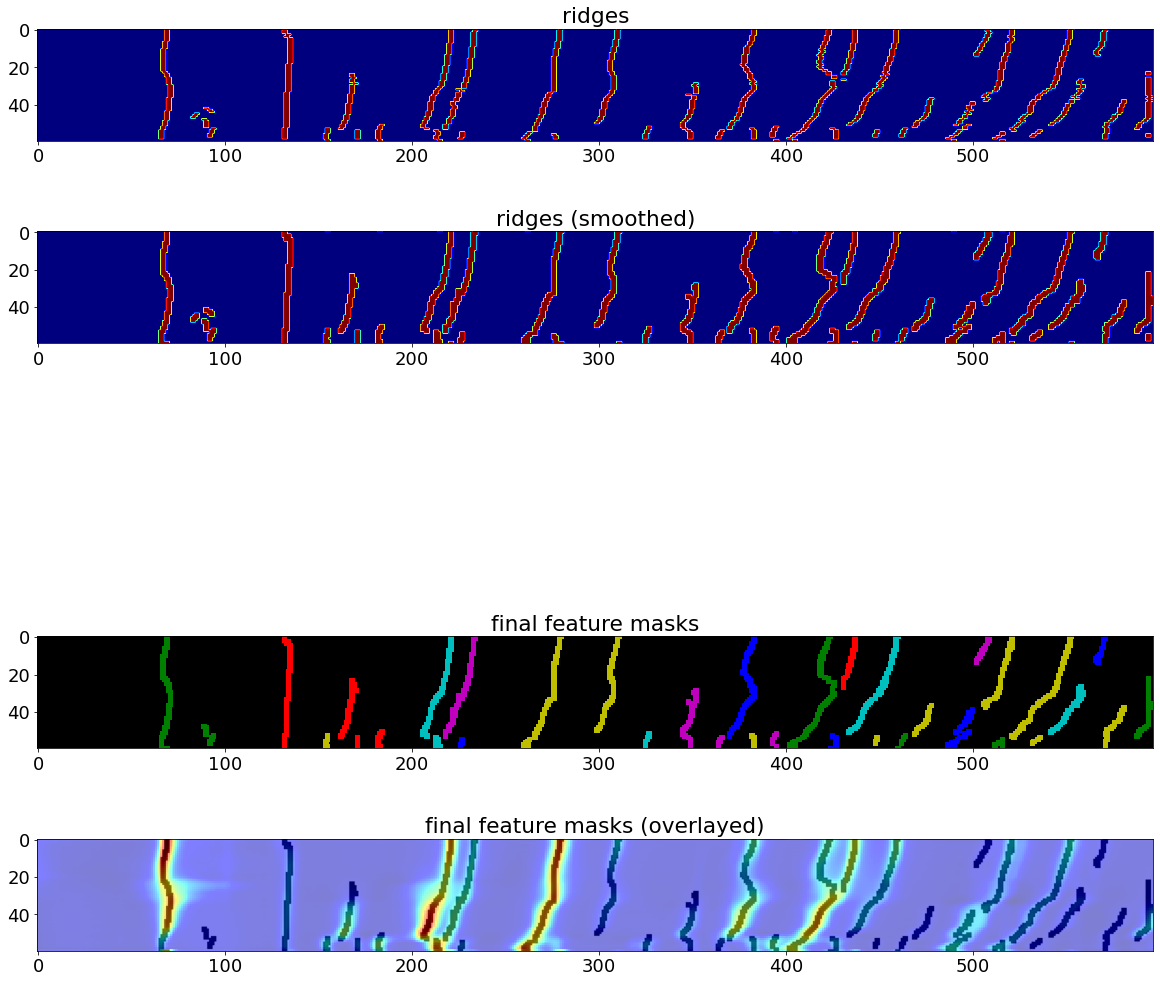

In [68]:
patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]

labeled, feature_masks, activations, norm_, activations_n1 = feat.peakfit_featurize(patterns_pp, fitlists,
                                                                    size_thresh = 5, peakwidth = 1.5)

straightened_heatmap = feat.get_peakshift_corrected_heatmap(patterns, activations, labeled)

Peak at 69, start iteration with error = 0.5545020976281996
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231

25
25.16454159500381


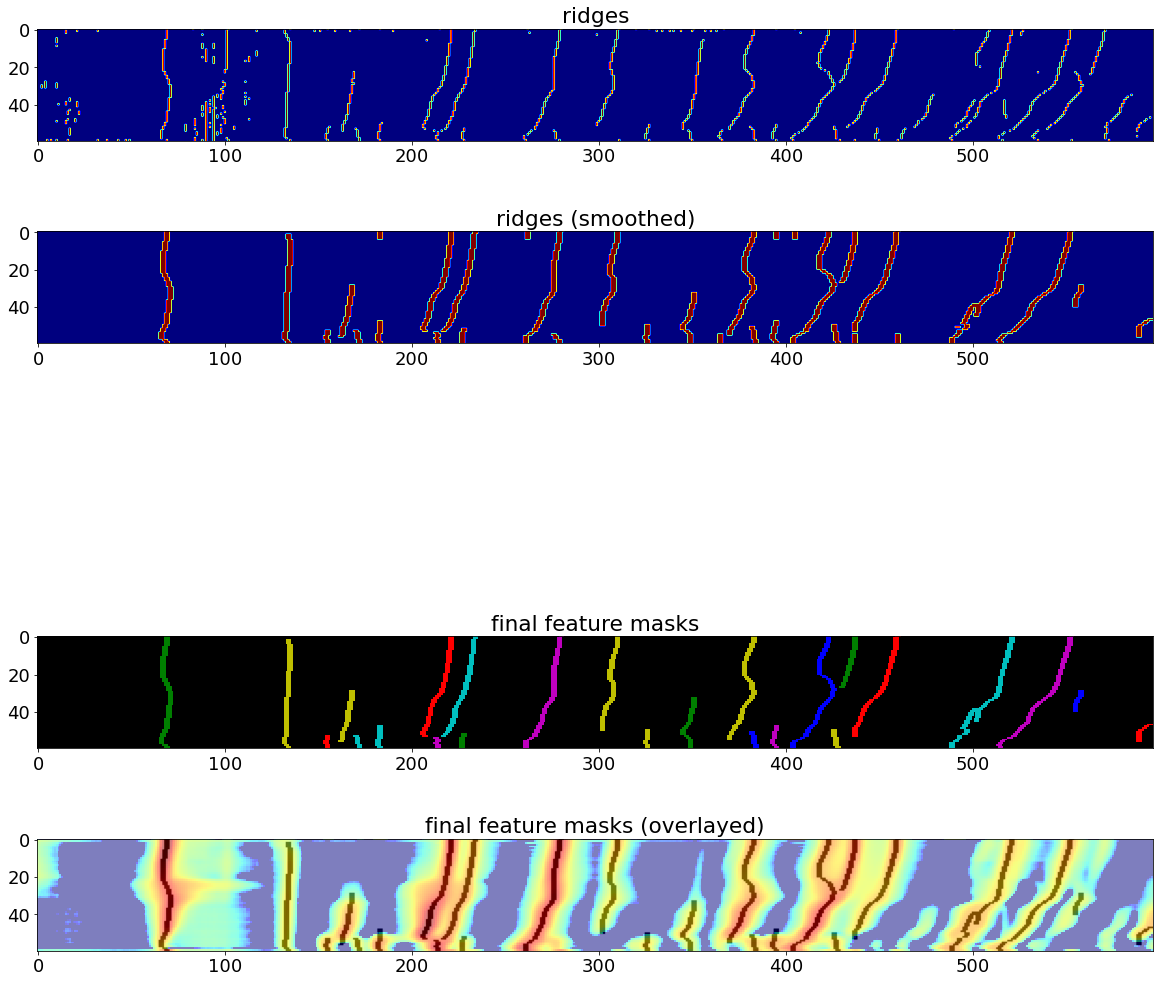

In [62]:
def default_featurize(patterns_pp):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
       smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 0, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)
    return labeled, feature_masks, activations, norm_, activations_n1


patterns_pp_simple = fast_q * (fast_q > 0)
labeled_simple, feature_masks_simple, activations_simple, _norm, activations_n1_simple =\
    default_featurize(patterns_pp_simple);
straightened_heatmap_simple = feat.get_peakshift_corrected_heatmap(patterns, activations_simple, labeled_simple)

Fig. 5

Text(0.5, 1.0, 'Cos similarity\n(background subtracted,\nfeaturized)')

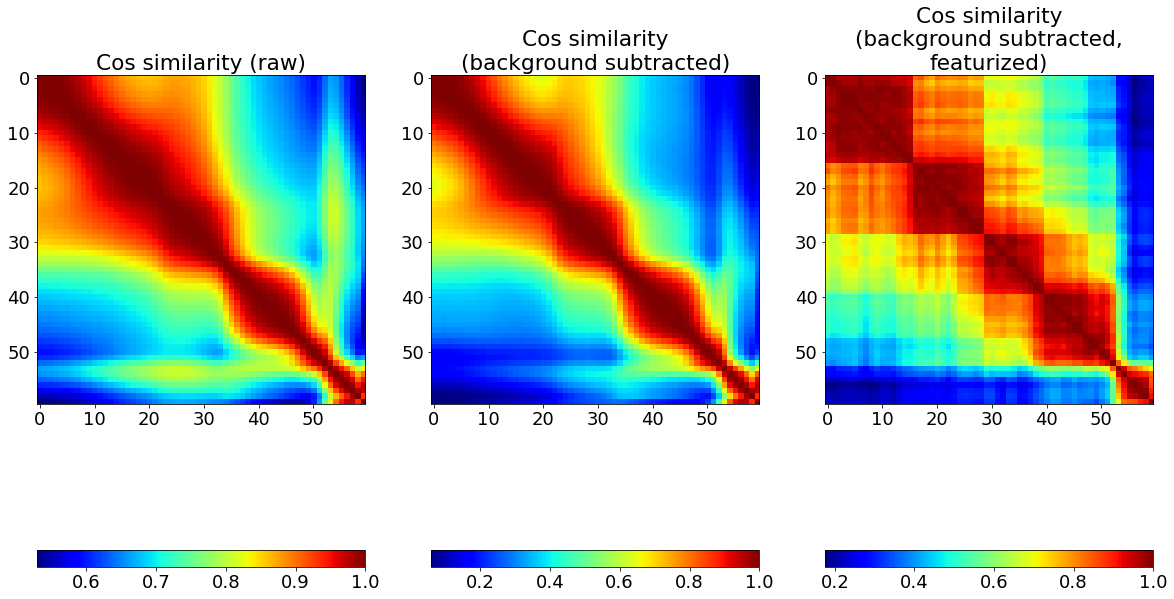

In [85]:
# a, b = 1, 3

# plt.subplot(a, b, 1)
# plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')
# plt.colorbar(orientation = 'horizontal')
# plt.title('Cos similarity (raw)')

# plt.subplot(a, b, 2)
# plt.imshow(feat.csim_pairs(patterns - background), cmap = 'jet')
# plt.colorbar(orientation = 'horizontal')
# plt.title('Cos similarity\n(background subtracted)')

# plt.subplot(a, b, 3)
# plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
# plt.colorbar(orientation = 'horizontal')
# plt.title('Cos similarity\n(background subtracted,\nfeaturized)')


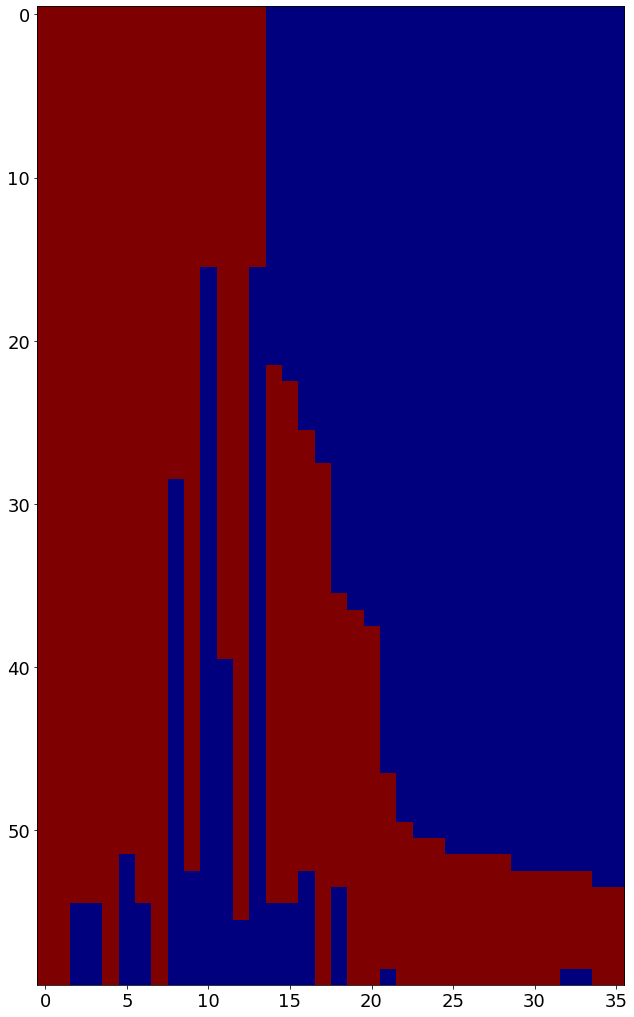

In [90]:
plt.imshow((activations != 0).T, cmap = 'jet')

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);


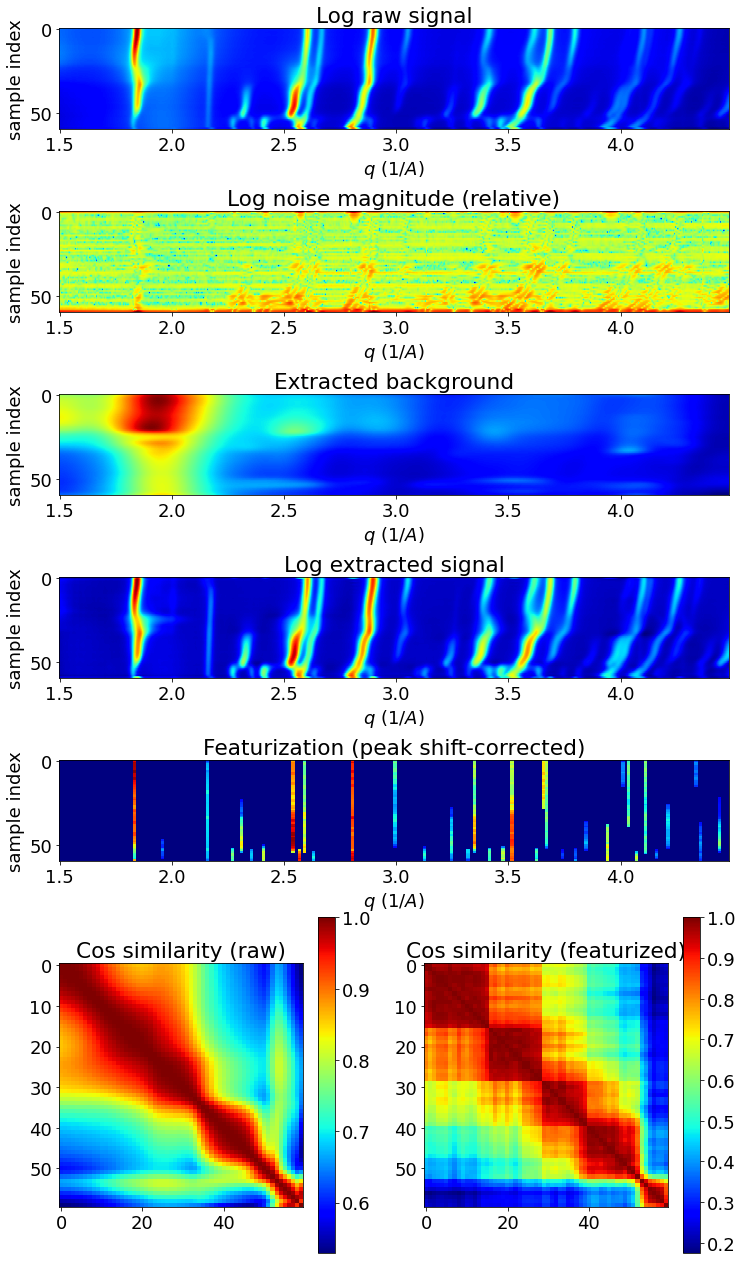

In [70]:
plot_summary(activations_n1, straightened_heatmap)

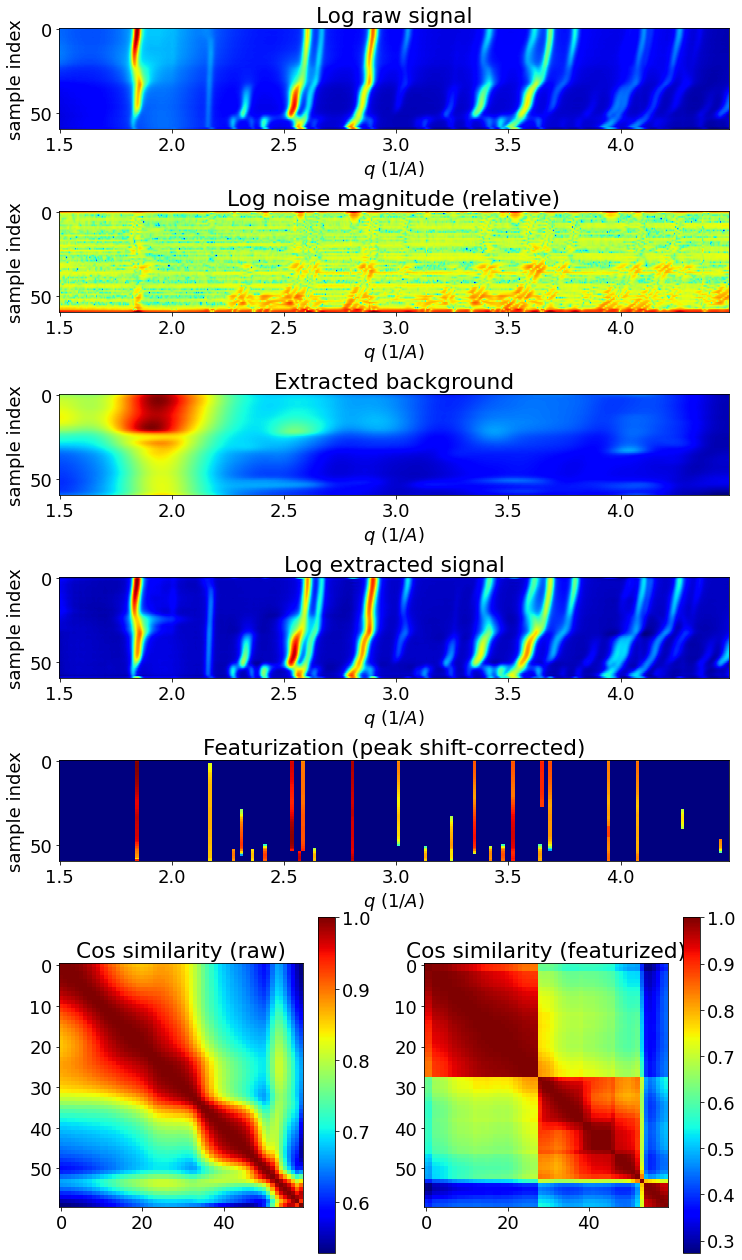

In [66]:
plot_summary(activations_n1_simple, straightened_heatmap_simple)

In [75]:
with open('data/activations_n1_simple.npy', 'wb') as f:
    np.save(f, activations_n1_simple)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);


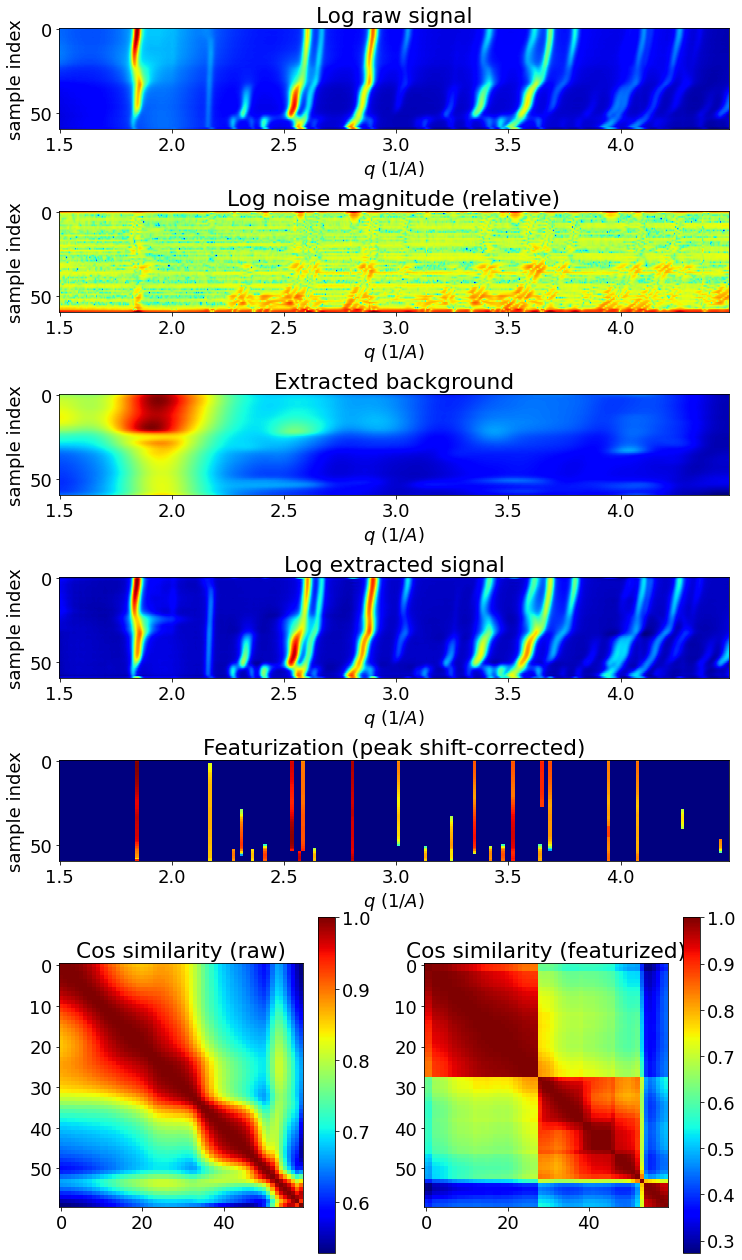

In [20]:
plot_summary(activations_n1_simple, straightened_heatmap_simple)

In [75]:
from importlib import reload
reload(vis)
reload(pf.hitp)
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [73]:
%pdb

Automatic pdb calling has been turned OFF


In [25]:
fitlists = fsub_stop_2d[1]

In [30]:
reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

## Peak fitting

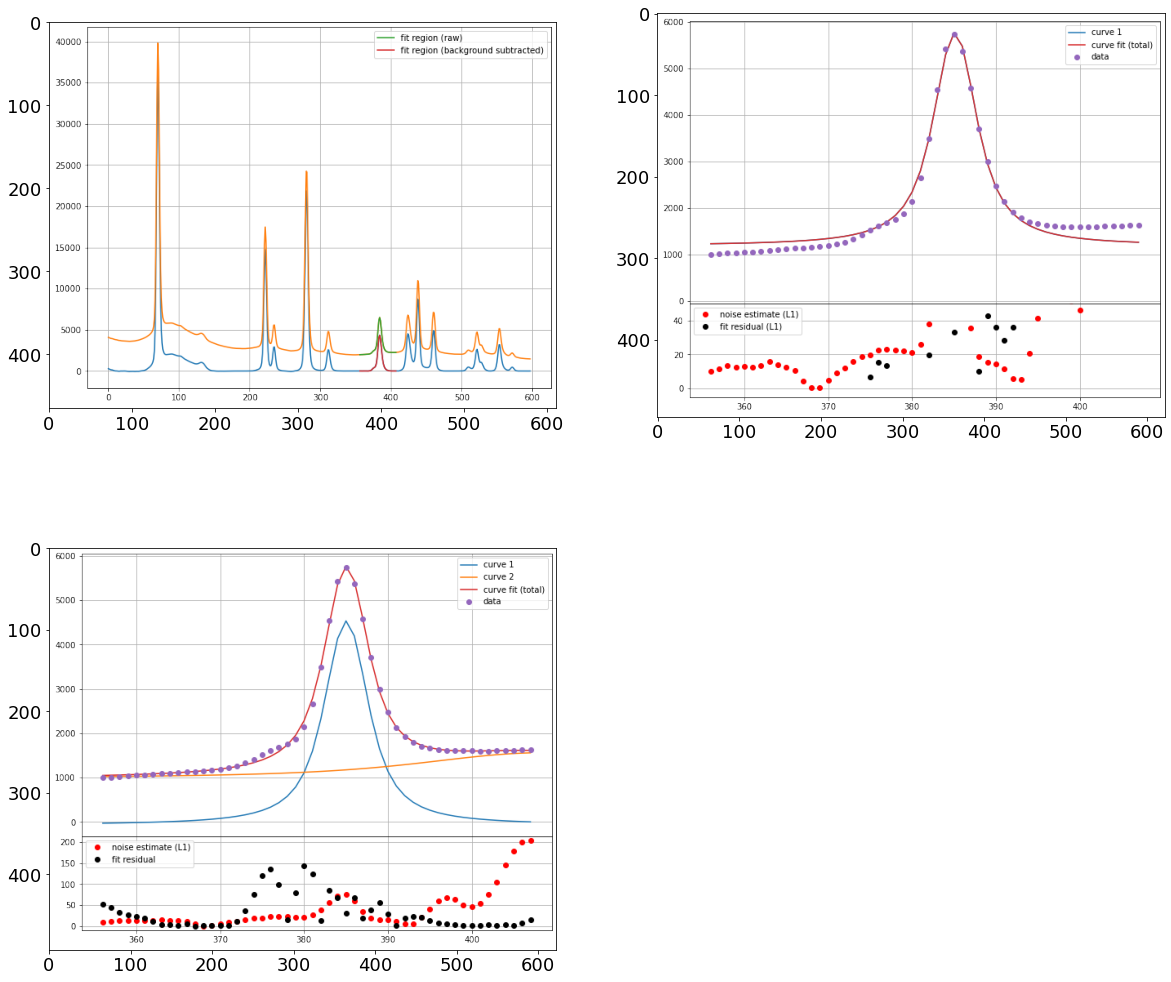

In [25]:
from PIL import Image
img1 = Image.open(path + 'BBA/context.png')
img2 = Image.open(path + 'BBA/without_bg.png')
img3 = Image.open(path + 'BBA/with_bg.png')

a, b = 2, 2
plt.subplot(a, b, 1)
plt.imshow(img1)

plt.subplot(a, b, 2)
plt.imshow(img2)

plt.subplot(a, b, 3)
plt.imshow(img3)

Peak fitting demo

In [33]:
def heatmap3d(patterns, interpolation = True, color_range = [0.2,.9], scale = True, auto_color = True, **kwargs):
    """
    Plot a 3-dimensional heatmap.
    """
    Nx = Ny = 100
    img = patterns
    dx, dy, dz = 1, 1, 1#nii_source.header.get_zooms()

    if scale:
        img = img.astype(np.float32) / img.max()#np.swapaxes(img,0,2).astype(np.float32)
        img = np.log(1 + 10 * img)

    nz, ny, nx = img.shape

    xmin, xmax, ymin, ymax = 0, 1, 0, .25
    if auto_color:
        volume = k3d.volume(img, interpolation = interpolation, bounds = np.array([0, 1, 0, .25, 0, .25]),
          color_range=color_range, color_map=np.array(k3d.basic_color_maps.Jet, dtype=np.float32), **kwargs)
    else:
        volume = k3d.volume(img, interpolation = interpolation, bounds = np.array([0, 1, 0, .25, 0, .25]),
          color_range=color_range, **kwargs)
        
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    x, y = np.meshgrid(x, y)
    heights = np.ones_like(x) / 10
        
    obj = k3d.surface(heights, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, alpha = .01)

    plot = k3d.plot()
    plot += volume
    
    plot += obj
    
    plot.display()
    return plot, volume

In [34]:
plot, volume1 = heatmap3d(d3d.m3d);

/home/ollie/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [64]:
mask = (d3d.m3d.sum(axis = 2) != 0)

In [67]:
vfeats = (mask[..., None] * rmap(labeled))
volume.volume = vfeats
vals = np.unique(vfeats.ravel())
vals.sort()
opacity_func = np.ones((len(vals), 2), dtype = np.float32)
opacity_func[:, 0] = vals
color_range = (np.min(vfeats), np.max(vfeats))

ValueError: operands could not be broadcast together with shapes (15,15,1) (60,597) 

In [97]:
activations_n1.shape

(36, 60)

Text(0.5, 1.0, '2D PCA projection')

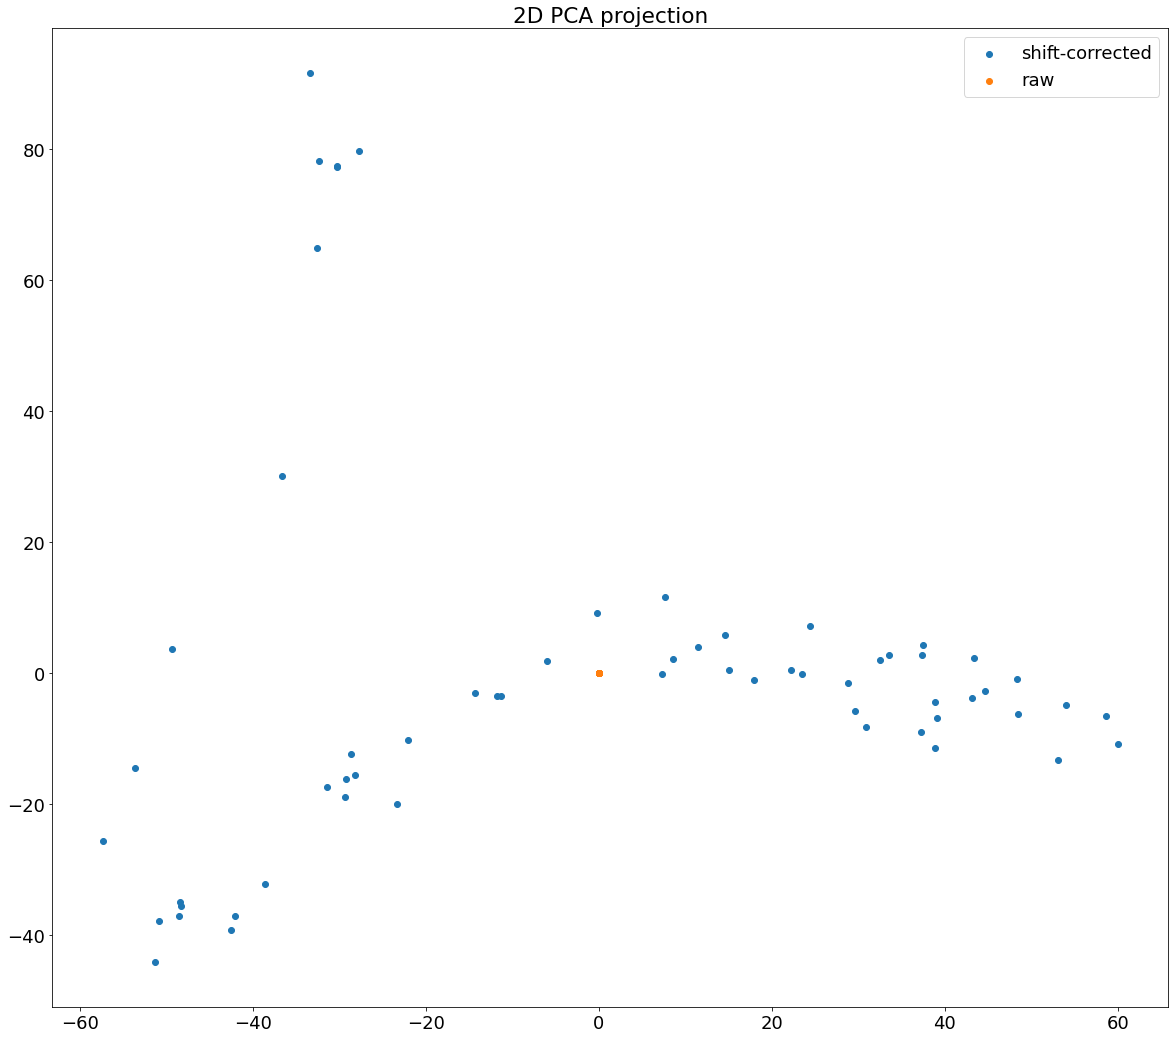

In [90]:
plt.scatter(*(vis.do_pca(activations.T, 2)[1].T), label = 'shift-corrected')
plt.scatter(*(vis.do_pca(patterns / 5000, 2)[1].T), label = 'raw')
plt.legend()
plt.title("2D PCA projection")

In [99]:
%pdb

Automatic pdb calling has been turned ON


(0, 0)
Peak at 69, start iteration with error = 0.19767781904845627
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229

Peak at 276, iteration 0: error = 0.6339725812544379
bounds ([-29.8, -4.554636942102418, 0, 0, 0], [625.8, inf, inf, 596.0, 596.0])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

<module 'xrdc.recipes.T_progression' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/recipes/T_progression.py'>

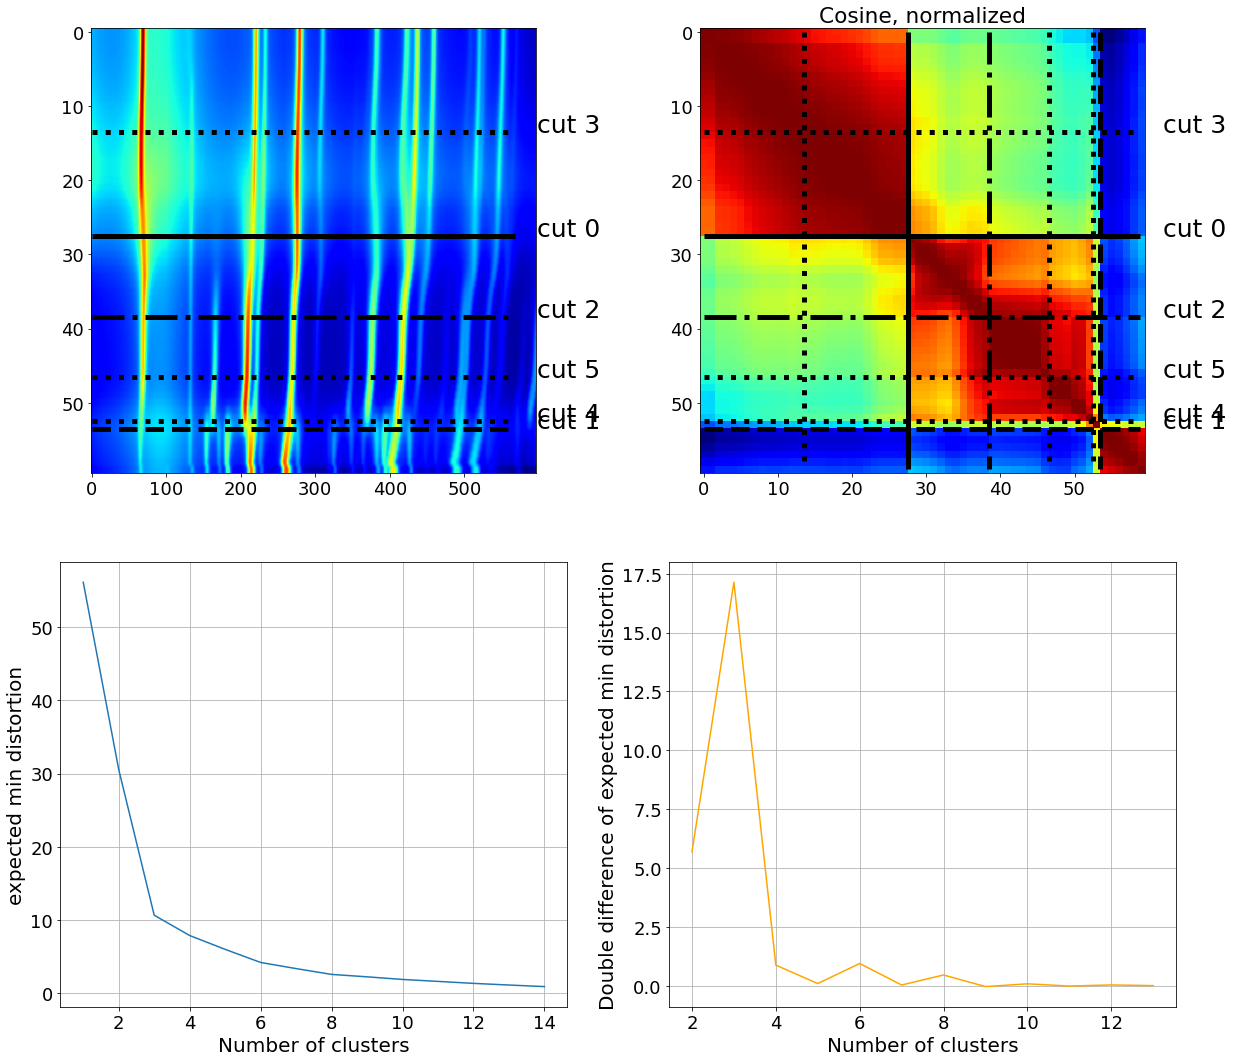

In [101]:
from importlib import reload
from xrdc.recipes import T_progression
reload(T_progression)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
(0, 0)
Peak at 69, start iteration with error = 0.25187781497745304
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 20

Peak at 276, iteration 0: error = 0.6484276597955976
bounds ([-29.8, -3.942260499059508, 0, 0, 0], [625.8, inf, inf, 596.0, 596.0])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

<module 'xrdc.recipes.T_progression' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/recipes/T_progression.py'>

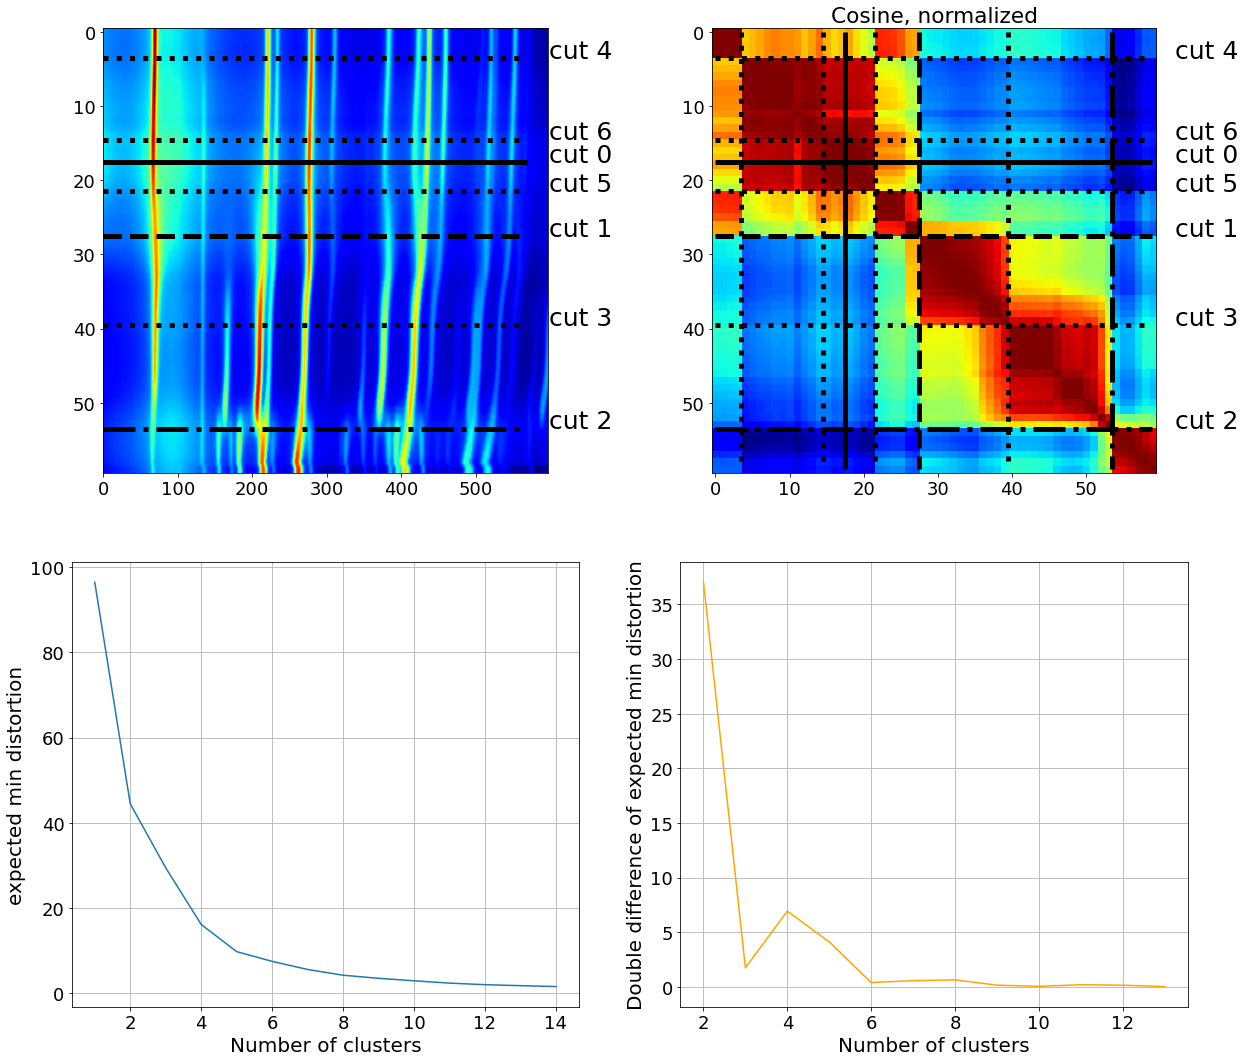

In [375]:
reload(hitp)
reload(pf)
reload(T_progression.feat)
reload(T_progression)

(0, 0)
0.003837450232307693
{'linkage': 'ward', 'affinity': 'euclidean'}
numBlocks: 56, dataPts/Block: 10.660714285714286
[  0. 153. 237. 307. 375. 417. 433. 456. 516. 528. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 153.0], [153.0, 237.0], [237.0, 307.0], [307.0, 375.0], [375.0, 417.0], [417.0, 433.0], [433.0, 456.0], [456.0, 516.0], [516.0, 528.0], [528.0, 596.0]]}
global background
[ 3.13280692e-01  2.80899731e-01  2.60953691e-01  2.49966858e-01
  2.34694233e-01  2.16059592e-01  1.84417152e-01  1.58301494e-01
  1.40875970e-01  1.30969433e-01  1.24993212e-01  9.92024132e-02
  6.88077080e-02  5.35897626e-02  5.08915861e-02  5.13655945e-02
  4.76390874e-02  3.47175230e-02  1.44191855e-02  5.72483935e-03
  2.82560946e-04  6.06284273e-04 -5.70135880e-03 -1.81859358e-02
 -2.89591868e-02 -3.25929599e-02 -3.46526638e-02 -3.56594789e-02
 -3.68853352e-02 -4.26756386e-02 -4.53712497e-02 -4.33278458e-02
 -4.13874879e-02 -4.29325029e-02 -4.31759167e-02 -3.90061428e-02
 -3.0

Peak at 222, iteration 0: error = 0.15420429092632024
bounds ([147.1, -2.905596141488814, 0, 0, 0], [276.9, inf, inf, 118.0, 118.0])
[153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 280, start iteration with error = 0.3492559007020079
302.50966864305946
[272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306]
Peak at 280, iteration 0: error = 0.0836744481285725
bounds ([270.3, -4.299278451377018, 0, 0, 0], [307.7, inf, inf, 3

Peak at 460, iteration 0: error = 0.0840438423130398
bounds ([453.05, -0.9577072763587169, 0, 0, 0], [517.95, inf, inf, 59.0, 59.0])
[456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511 512 513 514 515]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 522, start iteration with error = 0.35809614218808816
105.19583231077338
[516 517 518 519 520 521 522 523 524 525 526]
Peak at 522, iteration 0: error = 0.15436607980914482
bounds ([515.5, -0.5206241826768625, 0, 0, 0], [526.5, inf, inf, 10.0, 10.0])
[516 517 518 519 520 521 522 523 524 525 526]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 553, start iteration with error = 0.2191211896772269
168.05453435263524
[527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544
 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562
 563 56

Peak at 384, iteration 0: error = 0.1384428139159274
bounds ([375.55, -0.7996827420662433, 0, 0, 0], [385.45, inf, inf, 9.0, 9.0])
[376 377 378 379 380 381 382 383 384 385]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 424, start iteration with error = 0.23143620132523207
88.990718423853
[386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403
 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 424, iteration 0: error = 0.1329308248736555
bounds ([384.05, -0.8427219816921596, 0, 0, 0], [426.95, inf, inf, 39.0, 39.0])
[386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403
 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 438, start iteration with error = 0.35199126175481477
427.12721581182984
[426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443
 444 445 446 447 448 449 450 451 452 453 454]
Peak

Peak at 280, iteration 0: error = 0.035026149096707246
bounds ([270.35, -4.304418677107984, 0, 0, 0], [306.65, inf, inf, 33.0, 33.0])
[272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 311, start iteration with error = 0.1064230338090692
176.95549359009823
[306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375]
Peak at 311, iteration 0: error = 0.04466090054159081
bounds ([302.55, -0.49138098966397215, 0, 0, 0], [378.45, inf, inf, 69.0, 69.0])
[306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 35

Peak at 438, iteration 0: error = 0.17299467239386654
bounds ([430.9, -1.7552407591112629, 0, 0, 0], [455.1, inf, inf, 22.0, 22.0])
[432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 460, start iteration with error = 0.18099204362105212
257.30548699008835
[455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515]
Peak at 460, iteration 0: error = 0.08512831313188851
bounds ([452.0, -0.9754347868842095, 0, 0, 0], [518.0, inf, inf, 60.0, 60.0])
[455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515]
peak fit kwargs {'st

Peak at 310, iteration 0: error = 0.1375912502663863
bounds ([305.7, -0.4711661665223259, 0, 0, 0], [312.3, inf, inf, 6.0, 6.0])
[306 307 308 309 310 311 312]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 383, start iteration with error = 0.13627885400465747
222.97521597266228
[313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385]
Peak at 383, iteration 0: error = 0.19074643485971196
bounds ([309.4, -0.8012685968958725, 0, 0, 0], [388.6, inf, inf, 72.0, 72.0])
[313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 

Peak at 438, iteration 0: error = 0.18183502863632958
bounds ([430.9, -1.8023716583751876, 0, 0, 0], [455.1, inf, inf, 22.0, 22.0])
[432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 460, start iteration with error = 0.4021975859393932
203.8221602414446
[455 456 457 458 459 460 461 462 463]
Peak at 460, iteration 0: error = 0.2583032149241642
bounds ([454.6, -0.9650737856496356, 0, 0, 0], [463.4, inf, inf, 8.0, 8.0])
[455 456 457 458 459 460 461 462 463]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 521, start iteration with error = 0.1798411088270241
211.5866539331898
[464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521 522 523 524 525]
Peak at 521, iteration 0: error = 0.09247530521584248
bounds ([460.95, -0

Peak at 310, iteration 0: error = 0.1289841142717435
bounds ([304.65, -0.4716977514580768, 0, 0, 0], [312.35, inf, inf, 7.0, 7.0])
[305 306 307 308 309 310 311 312]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 382, start iteration with error = 0.1342722477393088
155.41961905579362
[313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384]
Peak at 382, iteration 0: error = 0.19446297923643996
bounds ([309.45, -0.787536430284751, 0, 0, 0], [387.55, inf, inf, 71.0, 71.0])
[313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383

Peak at 421, iteration 0: error = 0.11638713059501228
bounds ([382.1, -0.8367795748171535, 0, 0, 0], [423.9, inf, inf, 38.0, 38.0])
[384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 437, start iteration with error = 0.3546980923037803
224.89001683772415
[423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453]
Peak at 437, iteration 0: error = 0.15792715106905478
bounds ([421.5, -1.8424138263164427, 0, 0, 0], [454.5, inf, inf, 30.0, 30.0])
[423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 459, start iteration with error = 0.1909098123274803
206.1168051303149
[454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 472 4

peak fit kwargs {'stdratio_threshold': 8}
Peak at 279, start iteration with error = 0.29371054135221386
255.52225795170196
[236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303]
Peak at 279, iteration 0: error = 0.11629948033916444
bounds ([232.65, -4.385396569046445, 0, 0, 0], [306.35, inf, inf, 67.0, 67.0])
[236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 309, start iteration with error = 0.3635739932772428
176.5353447142698
[304 305 306 307 308 309 310 311]
Peak at 309, iteration 0: error = 0

peak fit kwargs {'stdratio_threshold': 8}
Peak at 458, start iteration with error = 0.1966832147786552
260.1177607871899
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513]
Peak at 458, iteration 0: error = 0.09732968749558339
bounds ([450.0, -0.887849834487716, 0, 0, 0], [516.0, inf, inf, 60.0, 60.0])
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512 513]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 520, start iteration with error = 0.36073159604904137
232.42441542090648
[514 515 516 517 518 519 520 521 522 523 524]
Peak at 520, iteration 0: error = 0.1887805145003605
bounds ([513.5, -0.554246811

peak fit kwargs {'stdratio_threshold': 8}
Peak at 420, start iteration with error = 0.23498084678062425
113.24202431129618
[383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421]
Peak at 420, iteration 0: error = 0.11338422604961473
bounds ([381.1, -0.7596090991113253, 0, 0, 0], [422.9, inf, inf, 38.0, 38.0])
[383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 436, start iteration with error = 0.3480188476583485
228.99911535793655
[422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439
 440 441 442 443 444 445 446 447 448 449 450 451 452]
Peak at 436, iteration 0: error = 0.16525727395905054
bounds ([420.5, -1.7788961384216535, 0, 0, 0], [453.5, inf, inf, 30.0, 30.0])
[422 423 424 425 426 427 428 429 430 431 432

Peak at 458, iteration 0: error = 0.09828031259129259
bounds ([450.05, -0.8541348141544058, 0, 0, 0], [514.95, inf, inf, 59.0, 59.0])
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 519, start iteration with error = 0.36203407372830426
181.65327705073244
[513 514 515 516 517 518 519 520 521 522 523]
Peak at 519, iteration 0: error = 0.1802124874234171
bounds ([512.5, -0.555876401731427, 0, 0, 0], [523.5, inf, inf, 10.0, 10.0])
[513 514 515 516 517 518 519 520 521 522 523]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 550, start iteration with error = 0.23651817228784194
251.86978952818248
[524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 56

Peak at 436, iteration 0: error = 0.18344940353845224
bounds ([420.5, -1.9980072741470791, 0, 0, 0], [453.5, inf, inf, 30.0, 30.0])
[422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439
 440 441 442 443 444 445 446 447 448 449 450 451 452]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 458, start iteration with error = 0.19372245694716428
210.32676274181026
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511 512]
Peak at 458, iteration 0: error = 0.09853428725907999
bounds ([450.05, -0.8516341572786333, 0, 0, 0], [514.95, inf, inf, 59.0, 59.0])
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508 509 510 511

Peak at 457, iteration 0: error = 0.09464999732886124
bounds ([449.05, -0.8511473584040696, 0, 0, 0], [513.95, inf, inf, 59.0, 59.0])
[452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 518, start iteration with error = 0.367893049556979
195.68538038232222
[512 513 514 515 516 517 518 519 520 521 522 523]
Peak at 518, iteration 0: error = 0.14779635343593892
bounds ([511.45, -0.5430596345585423, 0, 0, 0], [523.55, inf, inf, 11.0, 11.0])
[512 513 514 515 516 517 518 519 520 521 522 523]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 549, start iteration with error = 0.1962570663695424
232.4941082267651
[524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559

Peak at 457, iteration 0: error = 0.08793493368976837
bounds ([449.05, -0.805144882100526, 0, 0, 0], [513.95, inf, inf, 59.0, 59.0])
[452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 518, start iteration with error = 0.3522408659175849
147.49428628745417
[512 513 514 515 516 517 518 519 520 521 522 523]
Peak at 518, iteration 0: error = 0.16447359202176684
bounds ([511.45, -0.5190787765343691, 0, 0, 0], [523.55, inf, inf, 11.0, 11.0])
[512 513 514 515 516 517 518 519 520 521 522 523]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 549, start iteration with error = 0.18522530813046323
134.33202323173097
[524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 5

peak fit kwargs {'stdratio_threshold': 8}
Peak at 518, start iteration with error = 0.348782480675316
176.01861445537608
[512 513 514 515 516 517 518 519 520 521 522 523]
Peak at 518, iteration 0: error = 0.161900042913019
bounds ([511.45, -0.4922359188359622, 0, 0, 0], [523.55, inf, inf, 11.0, 11.0])
[512 513 514 515 516 517 518 519 520 521 522 523]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 549, start iteration with error = 0.1813116984371582
133.2709919433867
[524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 549, iteration 0: error = 0.09663641127070675
bounds ([520.45, -0.5406191714183776, 0, 0, 0], [598.55, inf, inf, 71.0, 71.0])
[524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 5

peak fit kwargs {'stdratio_threshold': 8}
Peak at 517, start iteration with error = 0.25559318730754466
246.10227695581517
[511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 535 536 537 538 539 540 541 542]
Peak at 517, iteration 0: error = 0.06722960851692401
bounds ([509.45, -0.48212415501904815, 0, 0, 0], [543.55, inf, inf, 31.0, 31.0])
[511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531 532 533 534 535 536 537 538 539 540 541 542]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 548, start iteration with error = 0.1802655075825945
278.8443333676361
[543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560
 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578
 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 548, iteration 0: error = 0.05619712067220621
bounds ([540.4, -0.5320758978531553, 0, 0, 0], [597.6, inf, inf, 52.0, 52.0])
[543 544 54

Peak at 517, iteration 0: error = 0.141736388650499
bounds ([510.45, -0.45987884287286973, 0, 0, 0], [522.55, inf, inf, 11.0, 11.0])
[511 512 513 514 515 516 517 518 519 520 521 522]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 548, start iteration with error = 0.1756482591023802
147.2835508848978
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595]
Peak at 548, iteration 0: error = 0.09293441607732694
bounds ([519.4, -0.5167101748334246, 0, 0, 0], [598.6, inf, inf, 72.0, 72.0])
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 58

Peak at 517, iteration 0: error = 0.05555910126872231
bounds ([508.45, -0.4248980134212882, 0, 0, 0], [542.55, inf, inf, 31.0, 31.0])
[510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527
 528 529 530 531 532 533 534 535 536 537 538 539 540 541]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 548, start iteration with error = 0.17834447895269298
170.68283547417334
[542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 548, iteration 0: error = 0.05841179730165752
bounds ([539.35, -0.4857567620649328, 0, 0, 0], [597.65, inf, inf, 53.0, 53.0])
[542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
    ----Saving data for block between 

Peak at 547, iteration 0: error = 0.056352687949822206
bounds ([539.35, -0.44409526193002596, 0, 0, 0], [597.65, inf, inf, 53.0, 53.0])
[542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595]
    ----Saving data for block between 1.00 - 200.00
    ----Saving data for block between 201.00 - 268.00
    ----Saving data for block between 269.00 - 311.00
    ----Saving data for block between 312.00 - 384.00
    ----Saving data for block between 385.00 - 509.00
    ----Saving data for block between 510.00 - 541.00
    ----Saving data for block between 542.00 - 595.00
done
numBlocks: 38, dataPts/Block: 15.710526315789474
[  0. 138. 269. 312. 386. 508. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 138.0], [138.0, 269.0], [269.0, 312.0], [312.0, 386.0], [386.0, 508.0], [508.0, 596.0]]}
global background
[ 0.958683

    ----Saving data for block between 1.00 - 137.00
    ----Saving data for block between 138.00 - 268.00
    ----Saving data for block between 269.00 - 311.00
    ----Saving data for block between 312.00 - 385.00
    ----Saving data for block between 386.00 - 507.00
    ----Saving data for block between 508.00 - 595.00
done
numBlocks: 40, dataPts/Block: 14.925
[  0. 138. 268. 313. 387. 507. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 138.0], [138.0, 268.0], [268.0, 313.0], [313.0, 387.0], [387.0, 507.0], [507.0, 596.0]]}
global background
[ 7.57783001e-01  7.14412385e-01  6.79668897e-01  6.58292819e-01
  6.37143780e-01  6.16855723e-01  5.72637092e-01  5.28594950e-01
  4.92695995e-01  4.62537254e-01  4.35379391e-01  3.92171206e-01
  3.49369871e-01  3.19284740e-01  2.98888900e-01  2.82663399e-01
  2.52283595e-01  2.21146519e-01  1.90130318e-01  1.59111376e-01
  1.35896754e-01  1.24758013e-01  1.00868977e-01  7.50142667e-02
  5.28065446e-02  3.53999761e-02  2.487929

numBlocks: 42, dataPts/Block: 14.214285714285714
[  0. 199. 267. 313. 388. 506. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 199.0], [199.0, 267.0], [267.0, 313.0], [313.0, 388.0], [388.0, 506.0], [506.0, 596.0]]}
global background
[ 6.46766586e-01  6.09855447e-01  5.85454462e-01  5.69547031e-01
  5.50171932e-01  5.28257357e-01  4.93896966e-01  4.65938134e-01
  4.34565795e-01  4.09162258e-01  3.89853346e-01  3.55699433e-01
  3.17760888e-01  2.91222792e-01  2.68213940e-01  2.52321780e-01
  2.24220912e-01  1.96226060e-01  1.62963133e-01  1.38939660e-01
  1.21389848e-01  1.08126929e-01  8.79209661e-02  6.17511168e-02
  3.91525987e-02  2.15761142e-02  1.18144155e-02  1.76032781e-03
 -8.21989601e-03 -1.85676055e-02 -3.36240027e-02 -3.78063797e-02
 -3.92311521e-02 -4.68322792e-02 -5.12246756e-02 -4.70554699e-02
 -3.85792364e-02 -3.59948189e-02 -3.52784595e-02 -3.03987603e-02
 -2.13179228e-02 -1.33868043e-02  4.06578639e-03  3.11650784e-02
  5.31496530e-02  7.78616966e-02

numBlocks: 42, dataPts/Block: 14.214285714285714
[  0. 199. 267. 314. 387. 506. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 199.0], [199.0, 267.0], [267.0, 314.0], [314.0, 387.0], [387.0, 506.0], [506.0, 596.0]]}
global background
[ 5.59440469e-01  5.19338216e-01  4.96877779e-01  4.86015955e-01
  4.75783516e-01  4.52685900e-01  4.22607227e-01  3.94386650e-01
  3.75064696e-01  3.56254773e-01  3.34620848e-01  3.00414719e-01
  2.64587366e-01  2.31269302e-01  2.15947422e-01  2.06821510e-01
  1.84694329e-01  1.54494657e-01  1.26186849e-01  1.15772665e-01
  9.89582841e-02  8.03491419e-02  5.44506706e-02  2.58412916e-02
  1.23672587e-02 -1.49647045e-03 -1.96496642e-02 -3.06909467e-02
 -4.45433494e-02 -5.91046023e-02 -6.66462655e-02 -7.42696418e-02
 -7.16272146e-02 -8.12113602e-02 -8.89513327e-02 -9.68375144e-02
 -9.85963180e-02 -9.36764465e-02 -8.62264775e-02 -7.93816633e-02
 -7.97239108e-02 -7.56502569e-02 -6.18098218e-02 -4.38290319e-02
 -2.12949836e-02 -3.03717016e-03

numBlocks: 42, dataPts/Block: 14.214285714285714
[  0. 199. 267. 314. 414. 457. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 199.0], [199.0, 267.0], [267.0, 314.0], [314.0, 414.0], [414.0, 457.0], [457.0, 596.0]]}
global background
[ 4.69358129e-01  4.48559303e-01  4.31215779e-01  4.14414822e-01
  4.04319624e-01  3.88843429e-01  3.59542403e-01  3.34315500e-01
  3.14689931e-01  2.93979913e-01  2.82971383e-01  2.55656790e-01
  2.26981034e-01  2.06592620e-01  1.84473502e-01  1.72876774e-01
  1.59666873e-01  1.36141438e-01  1.04227572e-01  9.13862345e-02
  7.64537230e-02  6.60466470e-02  3.71221739e-02  1.57247527e-02
  3.63708760e-04 -9.48660899e-03 -1.47502878e-02 -4.01142106e-02
 -5.20387939e-02 -6.56018712e-02 -7.61249523e-02 -8.63218359e-02
 -8.41625304e-02 -9.87921991e-02 -1.08572491e-01 -1.10272130e-01
 -1.06096172e-01 -1.06564368e-01 -9.46756664e-02 -8.77516295e-02
 -9.21532145e-02 -8.34202173e-02 -7.12452105e-02 -5.81440015e-02
 -4.26867225e-02 -2.95649167e-02

Peak at 71, iteration 0: error = 0.2533201303213382
bounds ([-8.850000000000001, -3.0296377449928835, 0, 0, 0], [207.85, inf, inf, 197.0, 197.0])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 

peak fit kwargs {'stdratio_threshold': 8}
Peak at 277, start iteration with error = 0.37699439976066745
455.27717019515126
[267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313]
Peak at 277, iteration 0: error = 0.11029944687366373
bounds ([264.7, -3.954803670506754, 0, 0, 0], [315.3, inf, inf, 46.0, 46.0])
[267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 384, start iteration with error = 0.24032237895588227
230.90928681985642
[314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372

peak fit kwargs {'stdratio_threshold': 8}
Peak at 427, start iteration with error = 0.4224960919170503
133.65055489074388
[391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455]
Peak at 427, iteration 0: error = 0.16254054395670536
bounds ([387.8, -1.6736542634768798, 0, 0, 0], [458.2, inf, inf, 64.0, 64.0])
[391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 515, start iteration with error = 0.3322382320227906
136.48382548104064
[456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 

Peak at 515, iteration 0: error = 0.28618859033617694
bounds ([452.0, -0.37670049256662763, 0, 0, 0], [540.0, inf, inf, 80.0, 80.0])
[456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527
 528 529 530 531 532 533 534 535 536]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 544, start iteration with error = 0.17180184950424318
86.3180252309422
[537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554
 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572
 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590
 591 592 593 594 595]
Peak at 544, iteration 0: error = 0.1329896675493651
bounds ([534.1, -0.2790524622909979, 0, 0, 0], [597.9, inf, inf, 58.0, 58.0])
[537 538 539 540 541 542 543 544 545 546 547

Peak at 514, iteration 0: error = 0.20270840726048134
bounds ([450.95, -0.4109566495094823, 0, 0, 0], [540.05, inf, inf, 81.0, 81.0])
[455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 543, start iteration with error = 0.19416908360416166
46.04502959379466
[537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554
 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572
 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590
 591 592 593 594 595]
Peak at 543, iteration 0: error = 0.13983633220292713
bounds ([534.1, -0.3129712535064916, 0, 0, 0], [597.9, inf, inf, 58.0, 58.0])
[537 538 539 540 541 542 543 544 545 

peak fit kwargs {'stdratio_threshold': 8}
Peak at 542, start iteration with error = 0.20955082852784027
35.89012341171392
[536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553
 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595]
Peak at 542, iteration 0: error = 0.14178328418152816
bounds ([533.05, -0.3462838736481541, 0, 0, 0], [597.95, inf, inf, 59.0, 59.0])
[536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553
 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595]
    ----Saving data for block between 1.00 - 136.00
    ----Saving data for block between 137.00 - 265.00
    ----Saving data for block between 266.00 - 313.00
    ----Saving data for block between 314.00 - 413.00
    ----Saving data for block between 41

peak fit kwargs {'stdratio_threshold': 8}
Peak at 449, start iteration with error = 0.17402656756679843
44.23899493941586
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499]
Peak at 449, iteration 0: error = 0.061047217822763275
bounds ([440.2, -0.41025120664715975, 0, 0, 0], [501.8, inf, inf, 56.0, 56.0])
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 513, start iteration with error = 0.3200753847475555
42.58763794652412
[500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533]
Peak at 513, itera

peak fit kwargs {'stdratio_threshold': 8}
Peak at 214, start iteration with error = 0.32766647272581584
113.01958956947274
[172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264]
Peak at 214, iteration 0: error = 0.20024847844362573
bounds ([167.4, -3.1555385220806738, 0, 0, 0], [268.6, inf, inf, 92.0, 92.0])
[172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 

peak fit kwargs {'stdratio_threshold': 8}
Peak at 510, start iteration with error = 0.22237631714648487
55.80718012647958
[450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530]
Peak at 510, iteration 0: error = 0.12892501794410838
bounds ([446.0, -0.44921766765598115, 0, 0, 0], [534.0, inf, inf, 80.0, 80.0])
[450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 537, start iteration with error = 0

Peak at 422, iteration 0: error = 0.12846291760757575
bounds ([409.65, -2.542872785378448, 0, 0, 0], [439.35, inf, inf, 27.0, 27.0])
[411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 445, start iteration with error = 0.284969119867017
62.6815041336552
[439 440 441 442 443 444 445 446 447 448]
Peak at 445, iteration 0: error = 0.23893875608458695
bounds ([438.55, -0.4022293818857146, 0, 0, 0], [448.45, inf, inf, 9.0, 9.0])
[439 440 441 442 443 444 445 446 447 448]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 508, start iteration with error = 0.2299423313807627
70.42787944859849
[449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521

peak fit kwargs {'stdratio_threshold': 8}
Peak at 379, start iteration with error = 0.2987634229901989
161.60731221589313
[345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408 409]
Peak at 379, iteration 0: error = 0.09550484922965055
bounds ([341.8, -1.5169122052128565, 0, 0, 0], [412.2, inf, inf, 64.0, 64.0])
[345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408 409]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 421, start iteration with error = 0.4563401556943835
90.2366755195675
[410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427
 428 429 430 431 432 43

peak fit kwargs {'stdratio_threshold': 8}
Peak at 595, start iteration with error = 0.10673893746869599
55.509293857160934
[557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592
 593 594 595]
Peak at 595, iteration 0: error = 0.09124872353656642
bounds ([555.1, -0.15067190208723202, 0, 0, 0], [596.9, inf, inf, 38.0, 38.0])
[557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574
 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592
 593 594 595]
    ----Saving data for block between 1.00 - 136.00
    ----Saving data for block between 137.00 - 198.00
    ----Saving data for block between 199.00 - 263.00
    ----Saving data for block between 264.00 - 343.00
    ----Saving data for block between 344.00 - 408.00
    ----Saving data for block between 409.00 - 437.00
    ----Saving data for block between 438.00 - 491.00
    ----Saving data for block between 492.00 - 5

Peak at 272, iteration 0: error = 0.10958280227696411
bounds ([223.3, -2.950216710527517, 0, 0, 0], [348.7, inf, inf, 114.0, 114.0])
[229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336
 337 338 339 340 341 342 343]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 378, start iteration with error = 0.2941515392895426
211.7455386671772
[344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408]
Peak at 378, 

Peak at 71, iteration 0: error = 0.15409055221584422
bounds ([-5.75, -3.214258861802893, 0, 0, 0], [142.75, inf, inf, 135.0, 135.0])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 167, start iteration with error = 0.247656912164947
282.24813632885633
[137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 18

Peak at 442, iteration 0: error = 0.05991432430944238
bounds ([434.35, -0.3860392034701185, 0, 0, 0], [492.65, inf, inf, 53.0, 53.0])
[437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454
 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 500, start iteration with error = 0.3113667721615801
398.7366473347275
[491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526]
Peak at 500, iteration 0: error = 0.11208953034300635
bounds ([489.25, -0.5253241910205269, 0, 0, 0], [527.75, inf, inf, 35.0, 35.0])
[491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 532, start iteration with error = 0.27235462275

Peak at 271, iteration 0: error = 0.08580021654411138
bounds ([258.95, -2.871265997385845, 0, 0, 0], [348.05, inf, inf, 81.0, 81.0])
[263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 351, start iteration with error = 0.2604717698212399
399.1772585157382
[345 346 347 348 349 350 351 352]
Peak at 351, iteration 0: error = 0.12235569435532509
bounds ([344.65, -0.25203658764486, 0, 0, 0], [352.35, inf, inf, 7.0, 7.0])
[345 346 347 348 349 350 351 352]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 377, start iteration with error = 0.27468085281370497
457.50361995539095
[353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 3

Peak at 377, iteration 0: error = 0.06055392290740558
bounds ([350.25, -1.9116756500647551, 0, 0, 0], [410.75, inf, inf, 55.0, 55.0])
[353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 418, start iteration with error = 0.44263583338862816
173.86295459213937
[409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435]
Peak at 418, iteration 0: error = 0.06825818792819467
bounds ([407.7, -3.0225015340441814, 0, 0, 0], [436.3, inf, inf, 26.0, 26.0])
[409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 442, start iteration with error = 0.17038789099052967
174.9079211592374
[436 437 438 439 440 441 442 443 444 4

Peak at 70, iteration 0: error = 0.13446786960060944
bounds ([-5.75, -3.036872285370616, 0, 0, 0], [142.75, inf, inf, 135.0, 135.0])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 167, start iteration with error = 0.18236400422474472
191.40253154853397
[137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 

peak fit kwargs {'stdratio_threshold': 8}
Peak at 210, start iteration with error = 0.6279007901132343
127.86731447976048
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218]
Peak at 210, iteration 0: error = 0.11464216410252381
bounds ([199.1, -6.039662798358898, 0, 0, 0], [218.9, inf, inf, 18.0, 18.0])
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 223, start iteration with error = 0.19168858460250496
172.49639794166504
[219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261]
Peak at 223, iteration 0: error = 0.04880926232752705
bounds ([216.9, -0.9339131254818098, 0, 0, 0], [263.1, inf, inf, 42.0, 42.0])
[219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257

peak fit kwargs {'stdratio_threshold': 8}
Peak at 349, start iteration with error = 0.3066642302747617
61.5784599303464
[344 345 346 347 348 349 350 351]
Peak at 349, iteration 0: error = 0.13441285412852047
bounds ([343.65, -0.31950249362529, 0, 0, 0], [351.35, inf, inf, 7.0, 7.0])
[344 345 346 347 348 349 350 351]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 376, start iteration with error = 0.2624374659015646
88.97545230309099
[352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405
 406 407]
Peak at 376, iteration 0: error = 0.06276424368352848
bounds ([349.25, -2.011745466679602, 0, 0, 0], [409.75, inf, inf, 55.0, 55.0])
[352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369
 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387
 388 389 390 391 392 393 394 395 396 397 398 399 400 

peak fit kwargs {'stdratio_threshold': 8}
Peak at 416, start iteration with error = 0.448069013507276
63.53069216346683
[407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433]
Peak at 416, iteration 0: error = 0.07252617729472705
bounds ([405.7, -3.0172429372592124, 0, 0, 0], [434.3, inf, inf, 26.0, 26.0])
[407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 440, start iteration with error = 0.1670543752644655
53.63936194486585
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488]
Peak at 440, iteration 0: error = 0.08164453166948615
bounds ([431.3, -0.3127513770603903, 0, 0, 0], [490.7, inf, inf, 54.0, 54.0])
[434 435 436 437 438 439 440 441 442 443 444 445

peak fit kwargs {'stdratio_threshold': 8}
Peak at 166, start iteration with error = 0.1834057708420735
83.0249483543772
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198]
Peak at 166, iteration 0: error = 0.08104975629237951
bounds ([132.9, -1.2486042141674936, 0, 0, 0], [201.1, inf, inf, 62.0, 62.0])
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 209, start iteration with error = 0.637328509219115
78.89069855434404
[199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217]
Peak at 209, iteration 0: error = 0

Peak at 347, iteration 0: error = 0.015765891106997804
bounds ([339.9, -0.4012559217007713, 0, 0, 0], [364.1, inf, inf, 22.0, 22.0])
[341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 373, start iteration with error = 0.3158061208547279
46.33365186418512
[364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404]
Peak at 373, iteration 0: error = 0.04089771841256801
bounds ([362.0, -1.857336505071215, 0, 0, 0], [406.0, inf, inf, 40.0, 40.0])
[364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 414, start iteration with error = 0.4130301467645985
54.705420029464854
[405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 4

Peak at 413, iteration 0: error = 0.0919795205950764
bounds ([402.3, -3.061707836904091, 0, 0, 0], [439.7, inf, inf, 34.0, 34.0])
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 493, start iteration with error = 0.2445087523152253
50.68989966125647
[439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519]
Peak at 493, iteration 0: error = 0.13795797677379198
bounds ([435.0, -0.5452385117576248, 0, 0, 0], [523.0, inf, inf, 80.0, 80.0])
[439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 47

Peak at 207, iteration 0: error = 0.12246033498859148
bounds ([197.15, -5.464414973353215, 0, 0, 0], [215.85, inf, inf, 17.0, 17.0])
[198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 220, start iteration with error = 0.2581918377709032
73.94688297634545
[216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257]
Peak at 220, iteration 0: error = 0.0858107329753462
bounds ([213.95, -1.462847130845245, 0, 0, 0], [259.05, inf, inf, 41.0, 41.0])
[216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 268, start iteration with error = 0.5536610158768687
58.29642745316023
[258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 2

Peak at 412, iteration 0: error = 0.24959433527510738
bounds ([389.1, -2.82508259325213, 0, 0, 0], [430.9, inf, inf, 38.0, 38.0])
[391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 498, start iteration with error = 0.24517895524192074
53.32266331366266
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501
 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516]
Peak at 498, iteration 0: error = 0.13515689370633338
bounds ([425.7, -0.5662565671921743, 0, 0, 0], [520.3, inf, inf, 86.0, 86.0])
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 

Peak at 184, iteration 0: error = 0.13506796548827876
bounds ([164.35, -0.7740634257544973, 0, 0, 0], [200.65, inf, inf, 33.0, 33.0])
[166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 208, start iteration with error = 0.5693113450087887
35.565840575118294
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231]
Peak at 208, iteration 0: error = 0.42354892632706165
bounds ([198.45, -2.2907996670728163, 0, 0, 0], [232.55, inf, inf, 31.0, 31.0])
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 267, start iteration with error = 0.2829236144333123
55.439500397614786
[232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 2

Peak at 156, iteration 0: error = 0.5504834247231417
bounds ([134.95, -0.6181946969242846, 0, 0, 0], [158.05, inf, inf, 21.0, 21.0])
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 184, start iteration with error = 0.34624576229359644
17.563772650910273
[158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202]
Peak at 184, iteration 0: error = 0.12335176221209569
bounds ([155.8, -1.1836284393476444, 0, 0, 0], [204.2, inf, inf, 44.0, 44.0])
[158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 213, start iteration with error = 0.5052399790461087
19.456430471049917
[203 204 205 206 207 208 209 21

peak fit kwargs {'stdratio_threshold': 8}
Peak at 394, start iteration with error = 0.33470231076679546
35.32290554415141
[329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395]
Peak at 394, iteration 0: error = 0.18570229505205071
bounds ([325.7, -1.208027310016866, 0, 0, 0], [398.3, inf, inf, 66.0, 66.0])
[329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 408, start iteration with error = 0.45497770032322926
29.272001442958548
[396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 

Peak at 183, iteration 0: error = 0.0835520373572819
bounds ([175.6, -1.4840384882793733, 0, 0, 0], [206.4, inf, inf, 28.0, 28.0])
[177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 215, start iteration with error = 0.5604200995271269
74.24873007109676
[206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229]
Peak at 215, iteration 0: error = 0.1334483921277194
bounds ([204.85, -3.7221669776060824, 0, 0, 0], [230.15, inf, inf, 23.0, 23.0])
[206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 263, start iteration with error = 0.30830382208542834
42.984353803886506
[230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 

Peak at 155, iteration 0: error = 0.7086937794055235
bounds ([134.0, -0.6047475358662324, 0, 0, 0], [178.0, inf, inf, 40.0, 40.0])
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 183, start iteration with error = 0.31387091934690176
65.72595280778397
[177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205]
Peak at 183, iteration 0: error = 0.1012072971935094
bounds ([175.6, -1.3841698408493341, 0, 0, 0], [206.4, inf, inf, 28.0, 28.0])
[177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205]
peak fit kwargs {'stdratio_threshold': 8}
Peak at 214, start iteration with error = 0.5474124186132171
44.34011278839842
[206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227

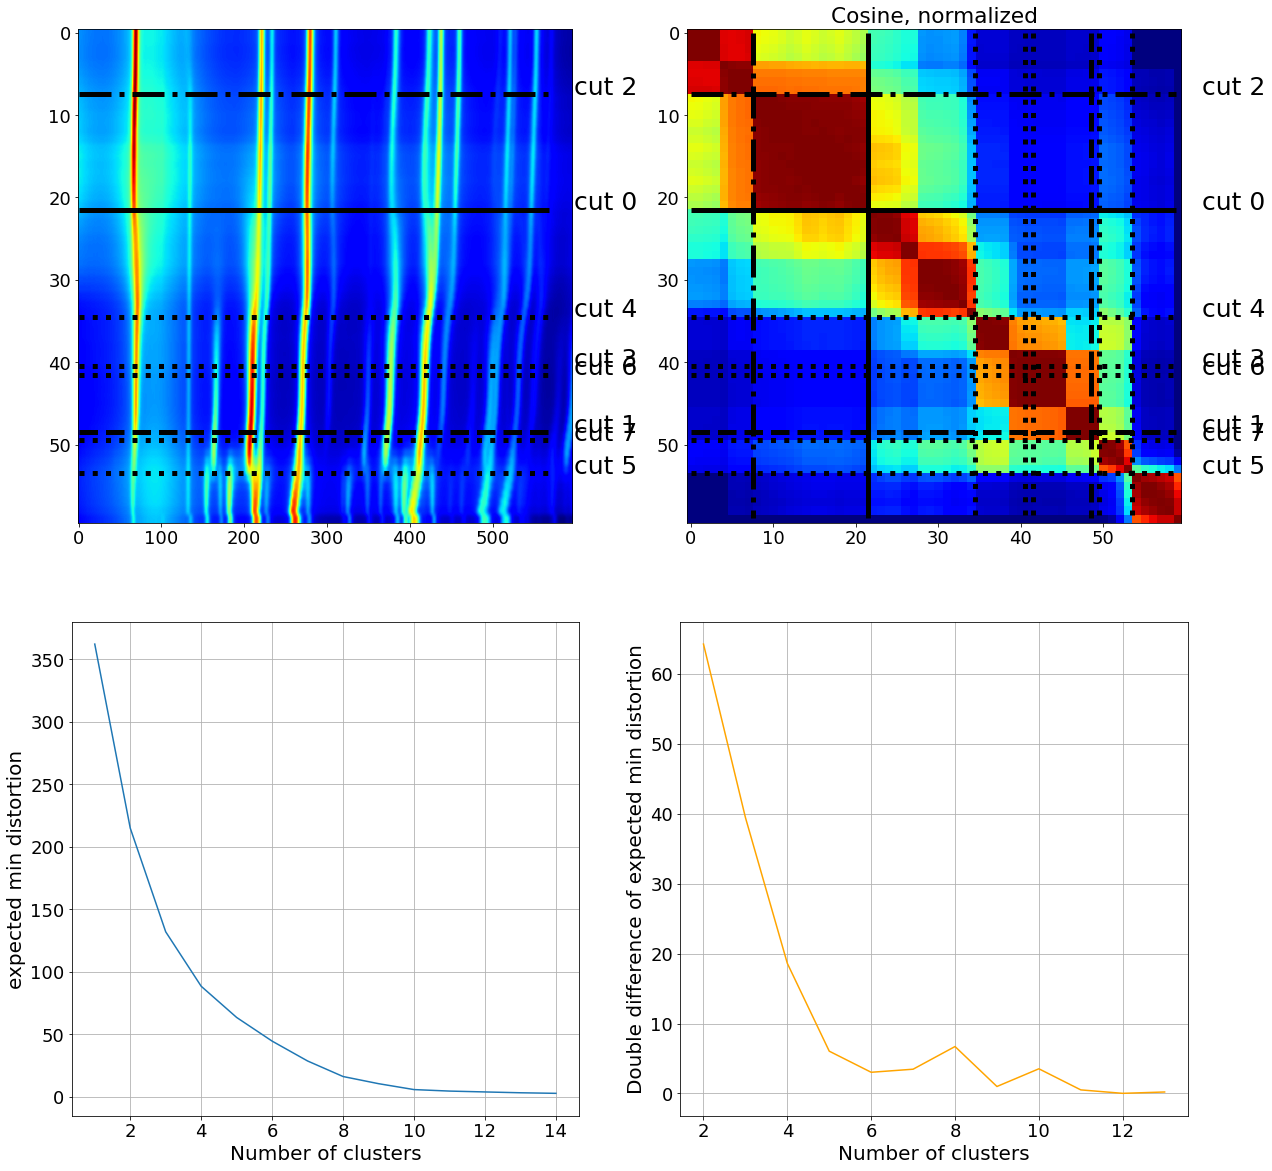

In [426]:
reload(T_progression.feat)
reload(T_progression)
reload(feat)

patterns = T_progression.patterns
background = T_progression.background
fast_q = T_progression.fast_q
fast_T = T_progression.fast_T
slow_T = T_progression.slow_T

# scale = 1 / (1 * fast_q.mean(axis = 1)[:, None])
# patterns *= scale

# background *= scale
# fast_T *= scale
# fast_q *= scale
noise = fast_T

fsub_stop_2d = T_progression.fitpeaks(8)

In [398]:
activations_n1.mean()

1.1967144148269002

In [211]:
# from xrdc.recipes.T_progression import slow_q, fast_q, slow_T, fast_T
# background = slow_q

In [414]:
from xrdc.dataproc.dataproc.operations import hitp

In [427]:
bounds = [hitp.bayesian_block_finder(np.arange(patterns.shape[-1]), p) for p in fast_q]

numBlocks: 122, dataPts/Block: 4.89344262295082
numBlocks: 120, dataPts/Block: 4.975
numBlocks: 119, dataPts/Block: 5.016806722689076
numBlocks: 121, dataPts/Block: 4.933884297520661
numBlocks: 123, dataPts/Block: 4.853658536585366
numBlocks: 122, dataPts/Block: 4.89344262295082
numBlocks: 119, dataPts/Block: 5.016806722689076
numBlocks: 119, dataPts/Block: 5.016806722689076
numBlocks: 122, dataPts/Block: 4.89344262295082
numBlocks: 121, dataPts/Block: 4.933884297520661
numBlocks: 116, dataPts/Block: 5.146551724137931
numBlocks: 110, dataPts/Block: 5.427272727272728
numBlocks: 113, dataPts/Block: 5.283185840707965
numBlocks: 109, dataPts/Block: 5.477064220183486
numBlocks: 114, dataPts/Block: 5.2368421052631575
numBlocks: 111, dataPts/Block: 5.378378378378378
numBlocks: 107, dataPts/Block: 5.579439252336448
numBlocks: 108, dataPts/Block: 5.527777777777778
numBlocks: 103, dataPts/Block: 5.796116504854369
numBlocks: 102, dataPts/Block: 5.852941176470588
numBlocks: 104, dataPts/Block: 5.7

In [405]:
reload(pf.hitp)
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [439]:
sep.iplot_rows(T_progression.patterns, background, patterns - background, fast_T, labels = ['a', 'b', 'c', 'd'])

interactive(children=(IntSlider(value=29, description='i', max=59), Output(layout=Layout(height='550px'))), _d…

In [442]:
sep.iplot_rows(patterns - background, labels = ['bg subbed'])

interactive(children=(IntSlider(value=29, description='i', max=59), Output(layout=Layout(height='550px'))), _d…

In [178]:
# fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 4, noise_estimate = fast_T,
#                    background = background, bg_shift_pos = False, bounds = None)

Peak at 69, start iteration with error = 0.2826597618054655
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231

Peak at 207, iteration 0: error = 0.6660899197858038
bounds ([-29.8, -5.960159462012577, 0, 0, 0], [625.8, inf, inf, 596.0, 596.0])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

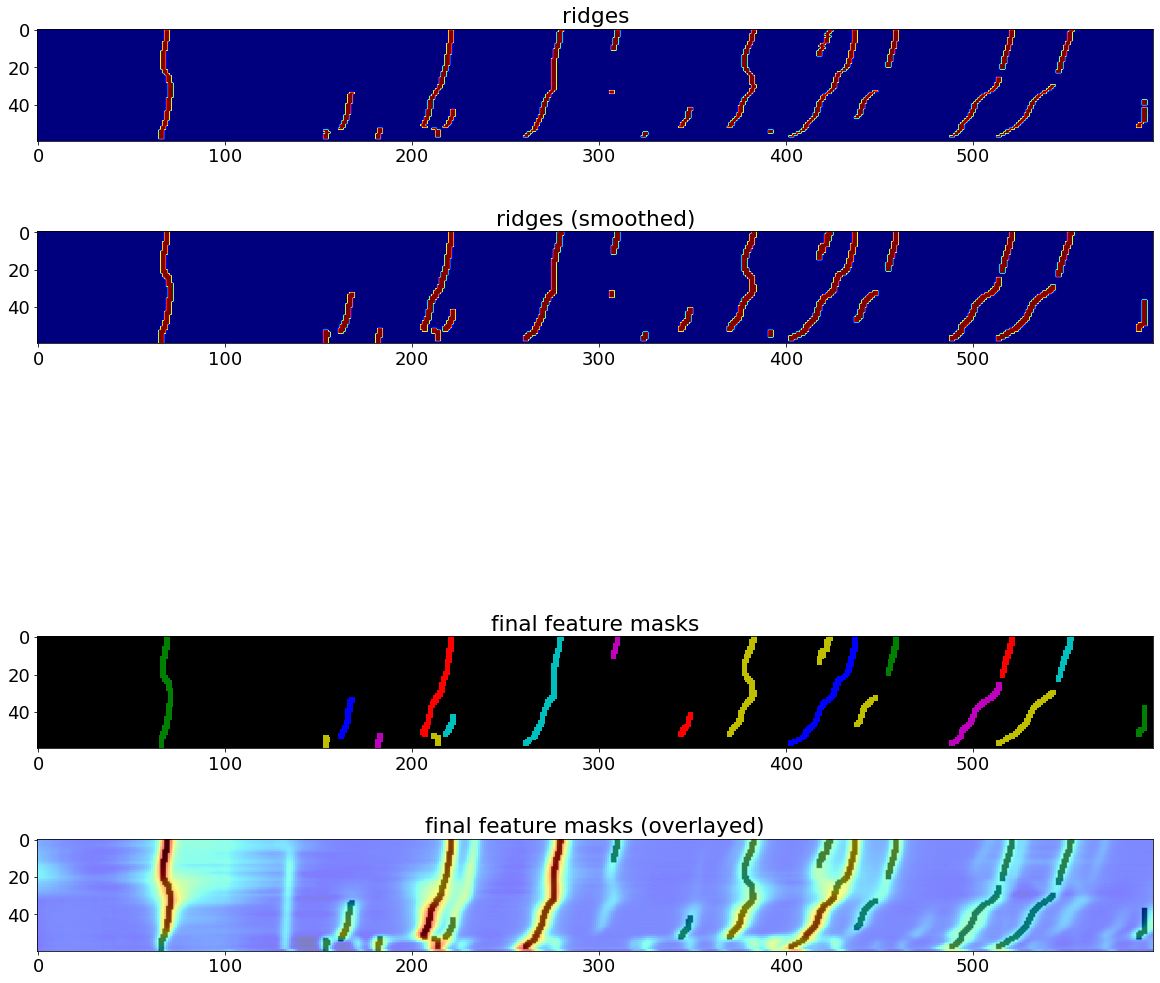

In [430]:
labeled, feature_masks, activations, norm_, activations_n1 = T_progression.featurize_fits(fsub_stop_2d,
                                                        peakwidth=1.1, log_scale_features=False)

straightened_heatmap = feat.get_peakshift_corrected_heatmap(patterns, activations, labeled)

In [431]:
activations_n1.mean()

1.1626092332884455

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);


1 -1


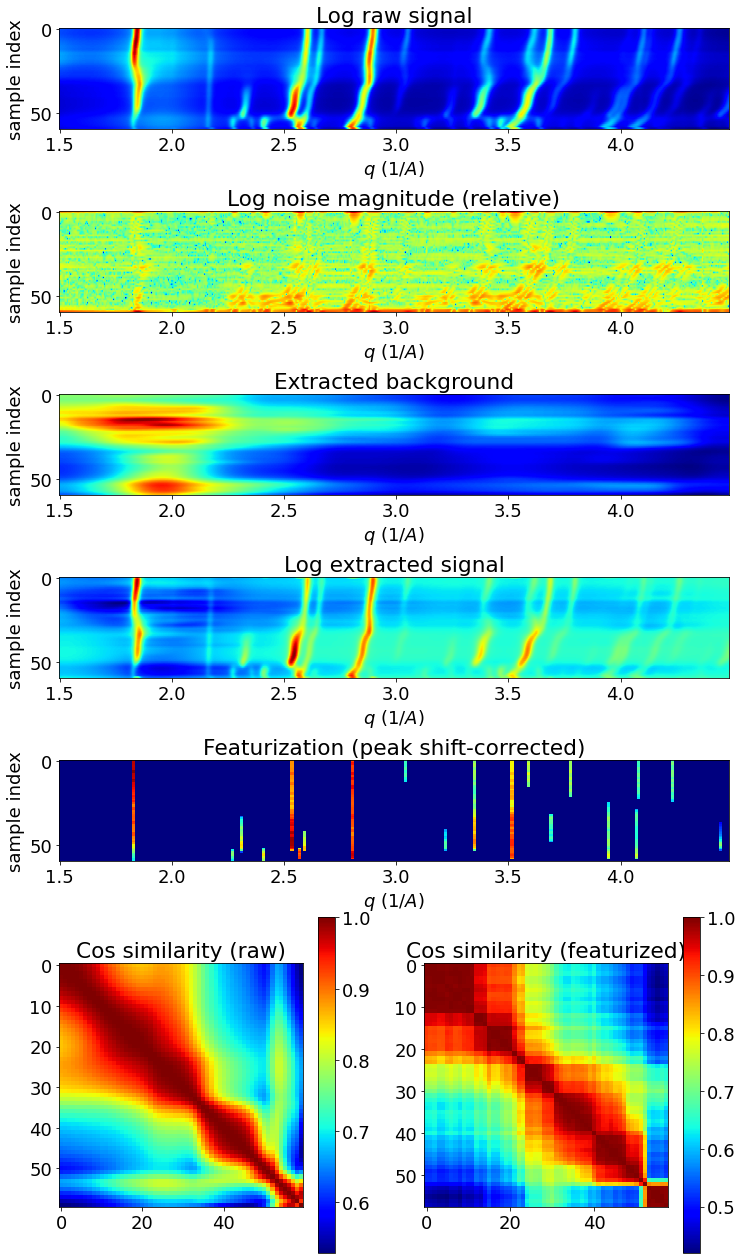

In [440]:
plot_summary(np.log(1 + activations_n1), straightened_heatmap)

In [373]:
np.abs(T_progression.fast_T).mean()

0.025363044606882063

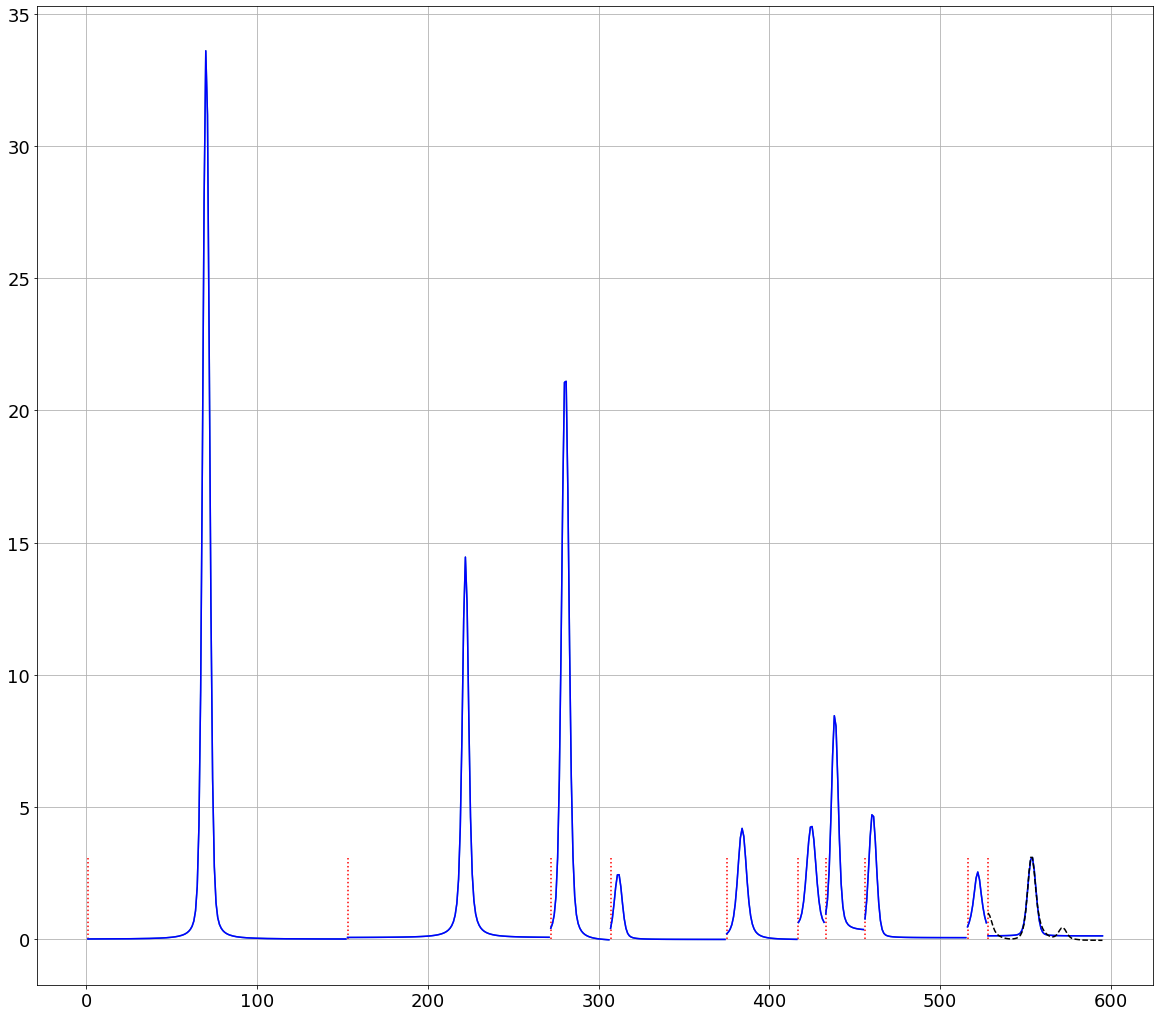

In [327]:
from xrdc import plotting

plotting.plot_all_fits(fsub_stop_2d, 1);
#plt.plot(mean2d(patterns - background)[0], 'k--')
# plt.plot((patterns - background)[i], 'k--')

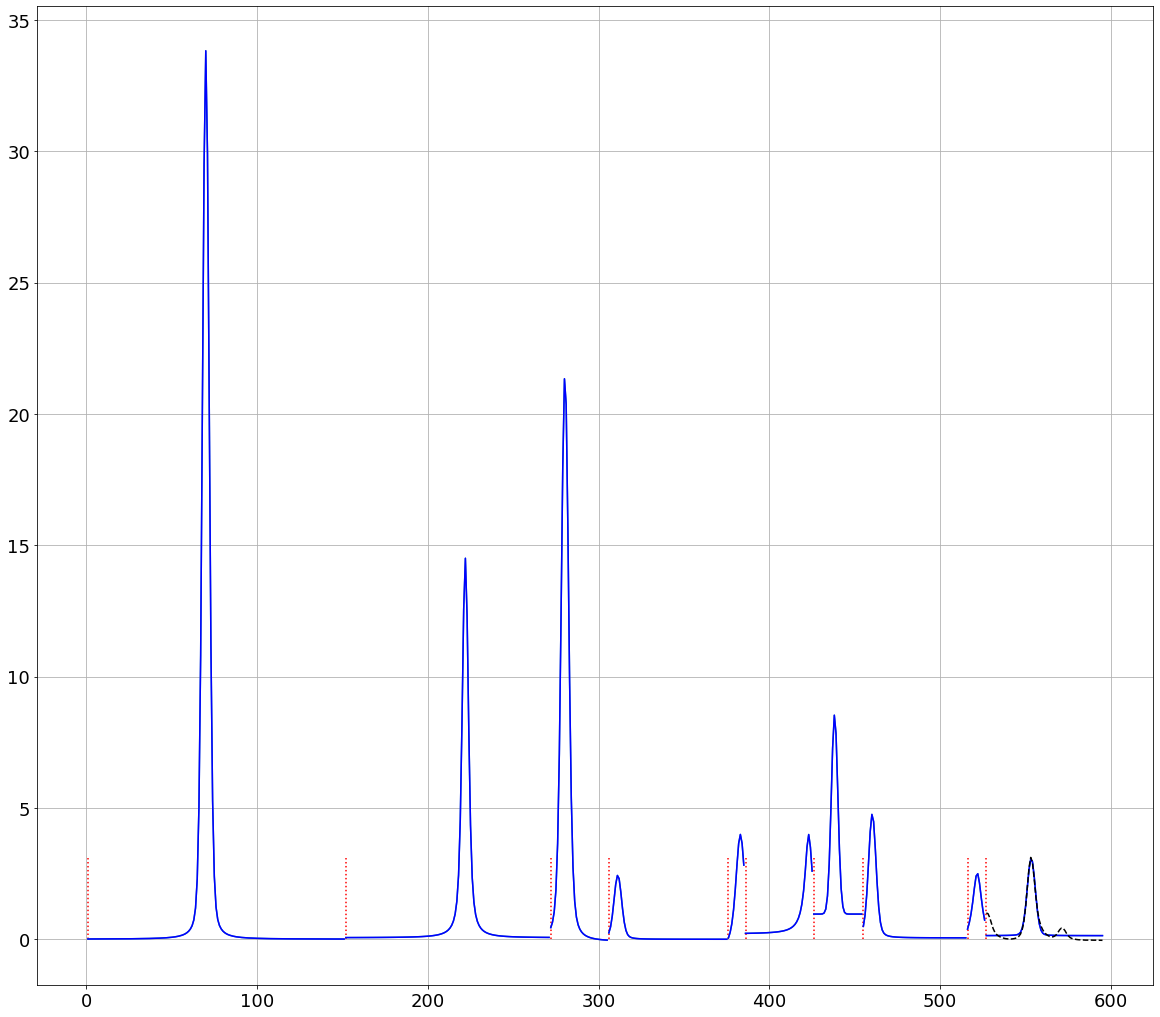

In [329]:
plotting.plot_all_fits(fsub_stop_2d, 3);


In [287]:
act_min = activations.copy()
# act_min[act_min == np.inf] = act_min.min(axis = -1)[None, ...]

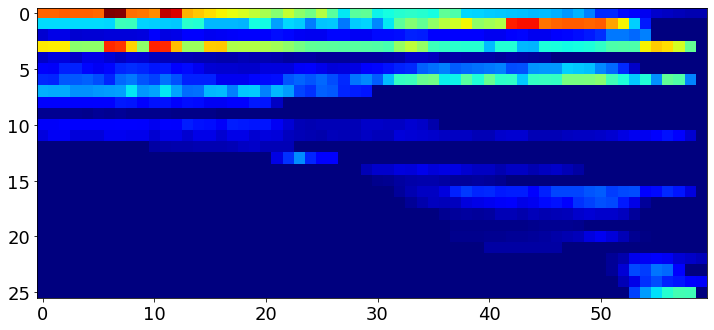

In [265]:
plt.imshow(act_min, cmap = 'jet')

In [337]:
act_min = activations.copy()
idxzero = np.where((act_min == 0))
iizero = idxzero[0]
act_min[act_min == 0] = np.inf

mins = act_min.min(axis = -1)

act_min[idxzero] = mins[iizero]

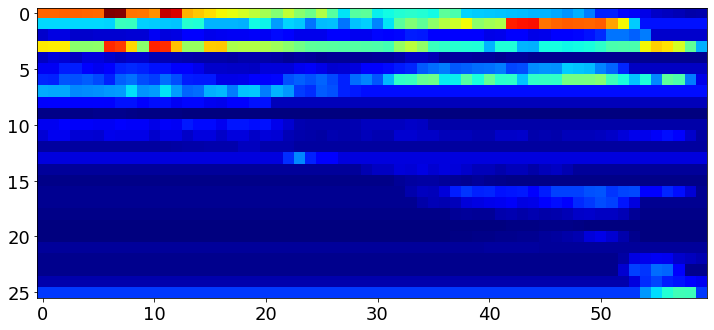

In [289]:
plt.imshow(act_min, cmap = 'jet')

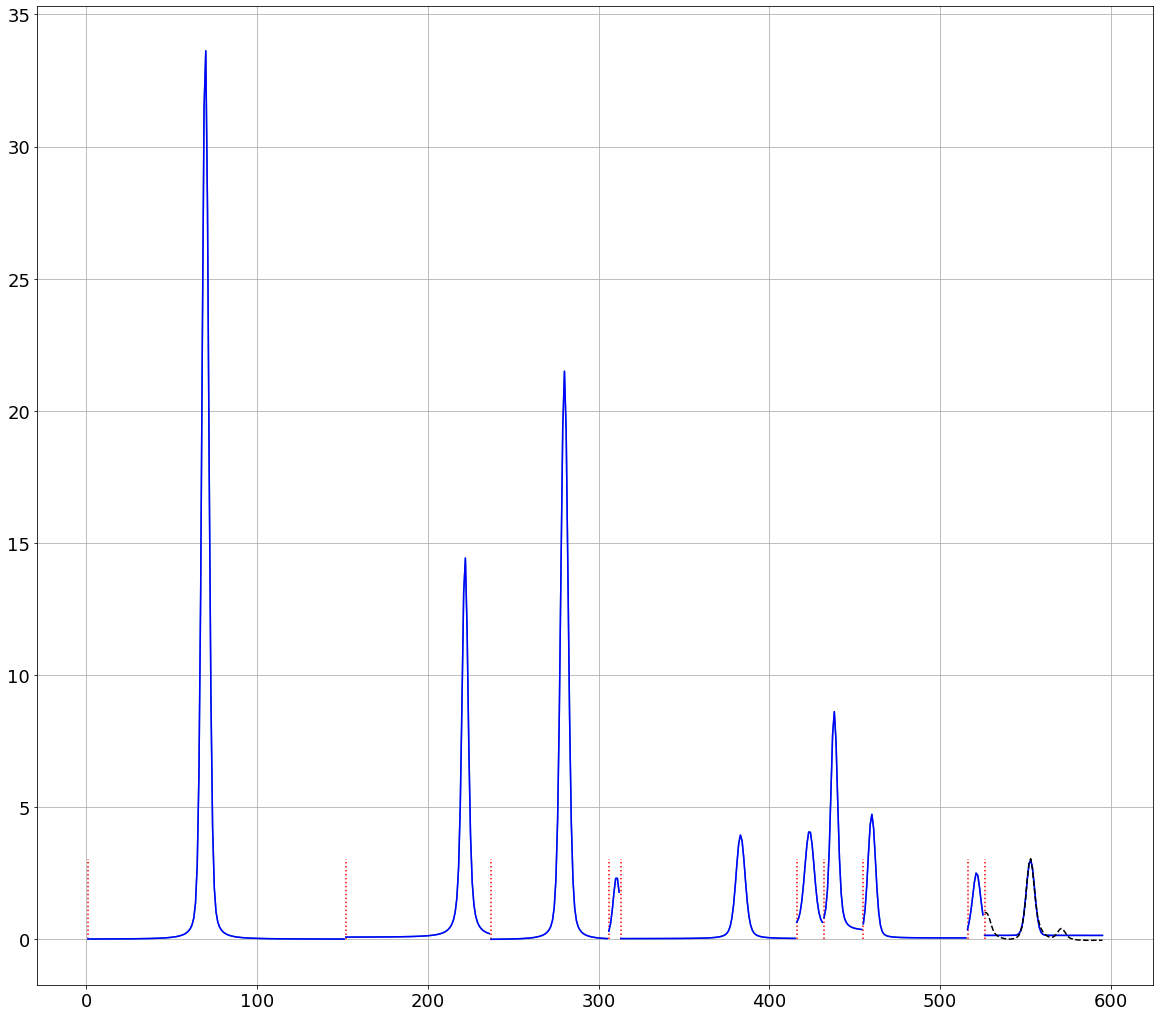

In [330]:
plotting.plot_all_fits(fsub_stop_2d, 5);

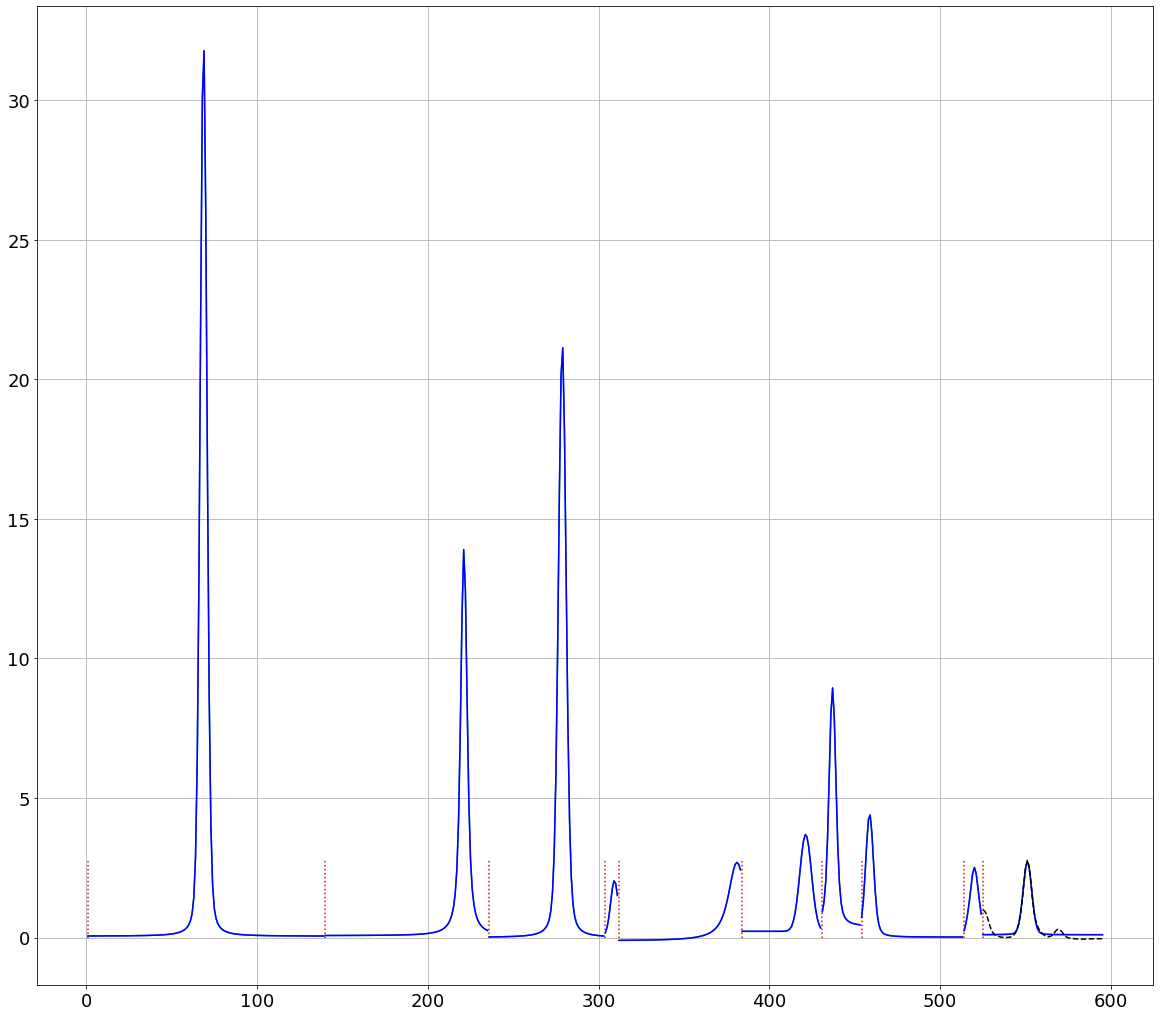

In [331]:
plotting.plot_all_fits(fsub_stop_2d, 10);


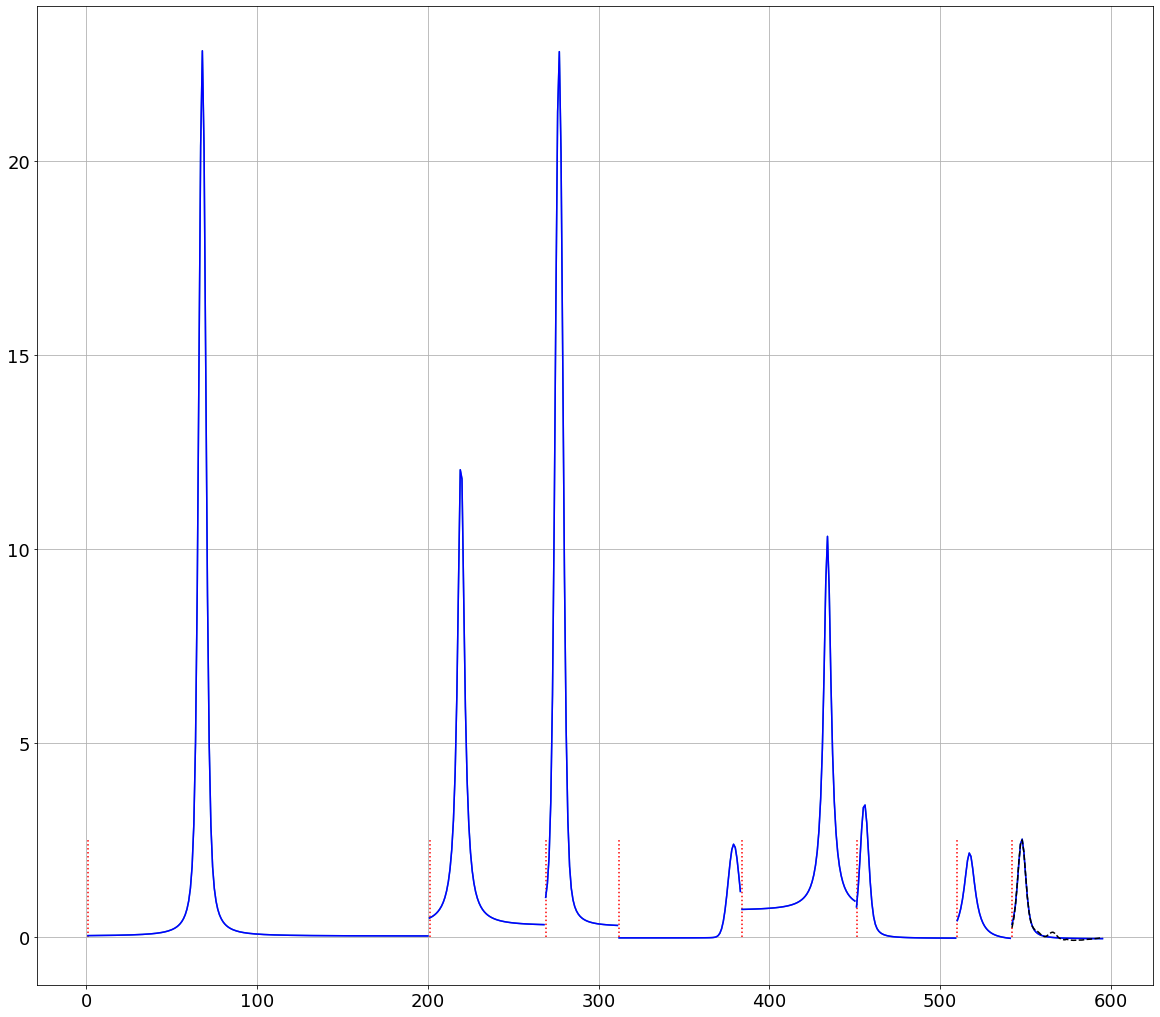

In [332]:
plotting.plot_all_fits(fsub_stop_2d, 20);


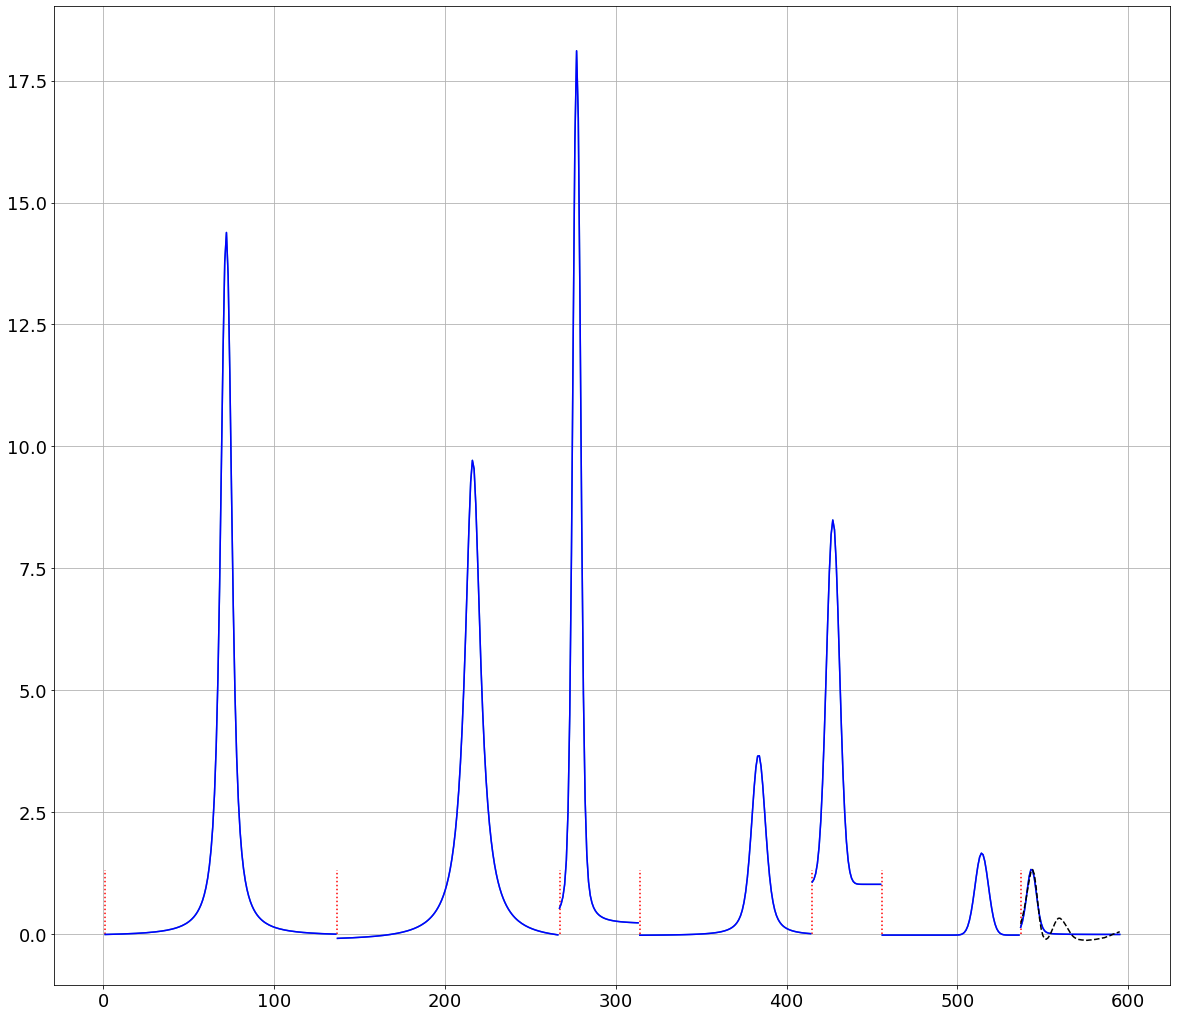

In [333]:
plotting.plot_all_fits(fsub_stop_2d, 30);


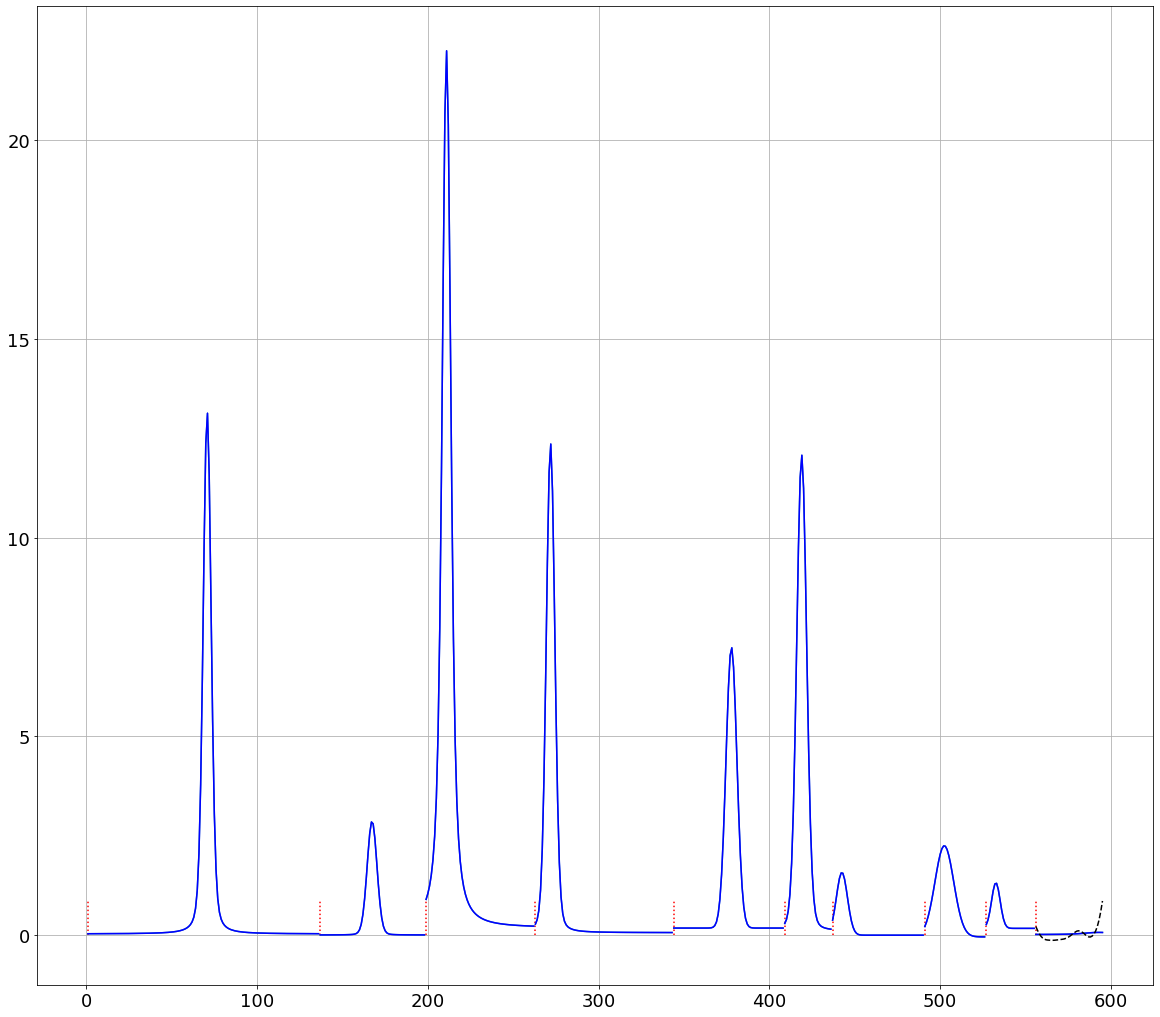

In [334]:
plotting.plot_all_fits(fsub_stop_2d, 40);


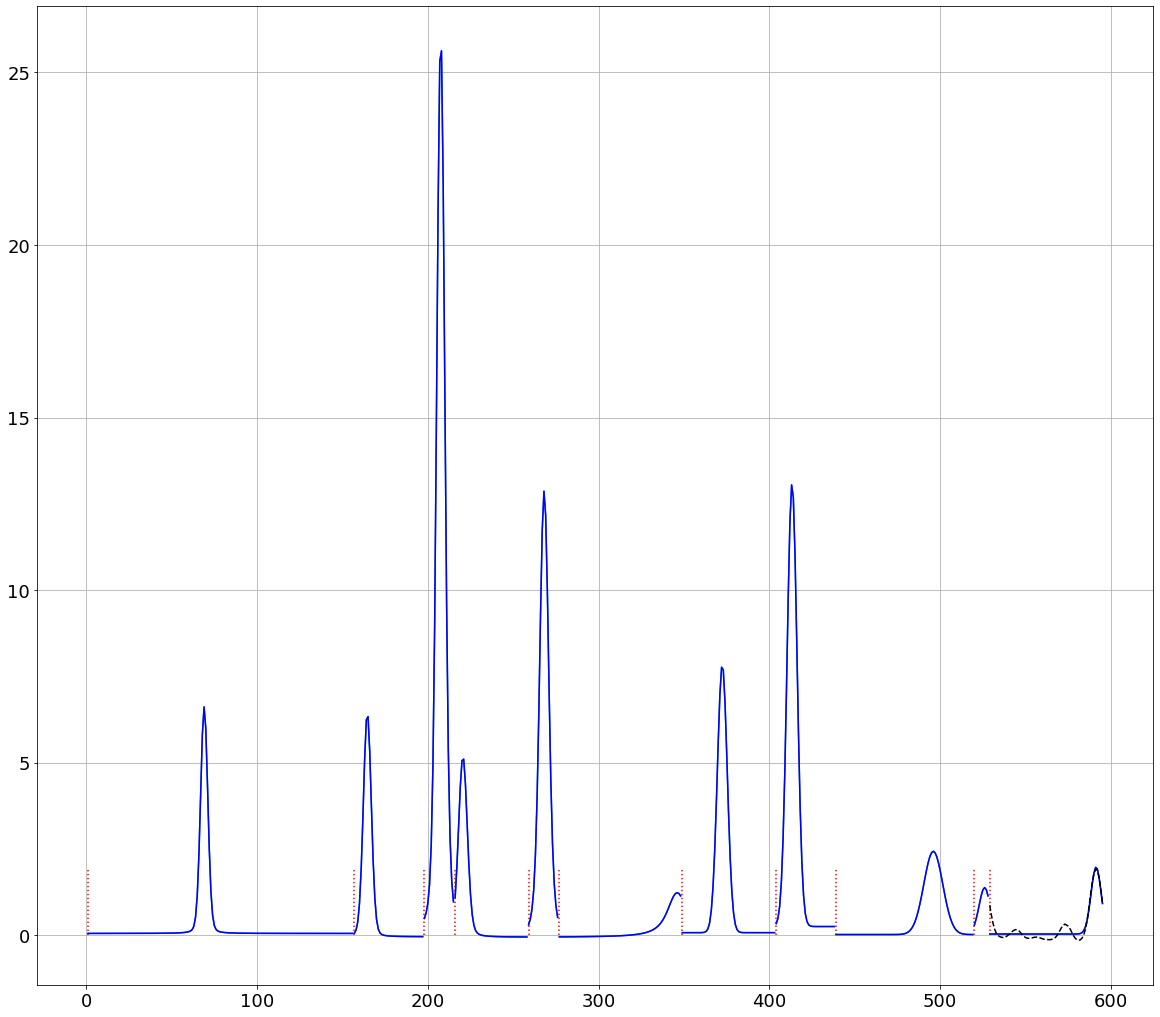

In [335]:
plotting.plot_all_fits(fsub_stop_2d, 50);


Text(0.5, 1.0, 'Cos similarity\n(background subtracted,\nfeaturized)')

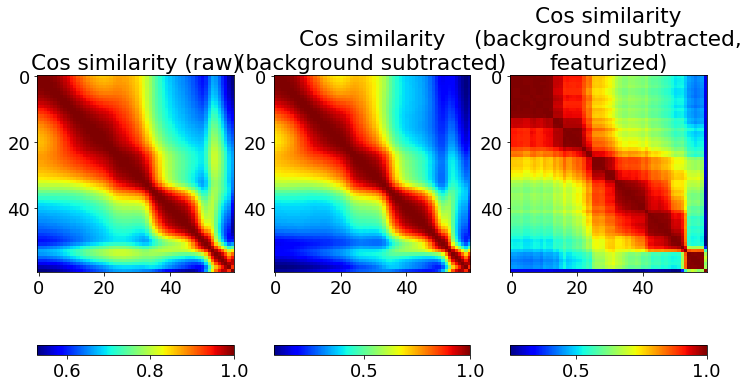

In [443]:
a, b = 1, 3

plt.subplot(a, b, 1)
plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.colorbar(orientation = 'horizontal')
plt.title('Cos similarity (raw)')

plt.subplot(a, b, 2)
plt.imshow(feat.csim_pairs(patterns - background), cmap = 'jet')
plt.colorbar(orientation = 'horizontal')
plt.title('Cos similarity\n(background subtracted)')

plt.subplot(a, b, 3)
plt.imshow(feat.csim_pairs(np.log(1 + activations_n1).T), cmap = 'jet')
plt.colorbar(orientation = 'horizontal')
plt.title('Cos similarity\n(background subtracted,\nfeaturized)')
